In [2]:
import pandas as pd

train_df = pd.read_csv('./data/train.csv')

print(f'len of train_df is {len(train_df)}')
train_df.head()

len of train_df is 17902


,ID,SMILES,label
0,116363,c1ccc(-c2ccccn2)nc1,0
1,103573,COc1ccc(-c2cc(=O)c3c(OC)c(OC)c(OC)c(OC)c3o2)cc1,0
2,104712,N#Cc1cnc2cnc(NCc3cccnc3)cc2c1Nc1ccc(F)c(Cl)c1,0
3,110269,COc1ccc2c(c1)CN(C(=O)CCl)C(c1ccccc1)C2,1
4,105481,Cc1cc2c(F)c(Oc3ncnn4cc(OC[C@@H](C)OC(=O)[C@H](...,0


In [3]:
from rdkit import Chem
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*') # 屏蔽RDKit的warning

for index, row in train_df.iterrows():
    try:
        mol = Chem.MolFromSmiles(row['SMILES'])
        new_smiles = Chem.MolToSmiles(mol)
        train_df.loc[index, 'SMILES'] = new_smiles
    except:
        # 若转化失败，则认为原始smile不合法，删除该数据
        train_df.drop(index, inplace=True)

print(f'len of train_df is {len(train_df)}')

len of train_df is 17902


In [5]:
duplicate_rows = train_df[train_df.duplicated('SMILES', keep=False)]

for smiles, group in duplicate_rows.groupby('SMILES'):
    if len(group.drop_duplicates(subset=['label'])) == 1:
        train_df.drop(index=group.index[1:], inplace=True)
    else:
        train_df.drop(index=group.index, inplace=True)

print(f'len of train_df is {len(train_df)}')

len of train_df is 8345


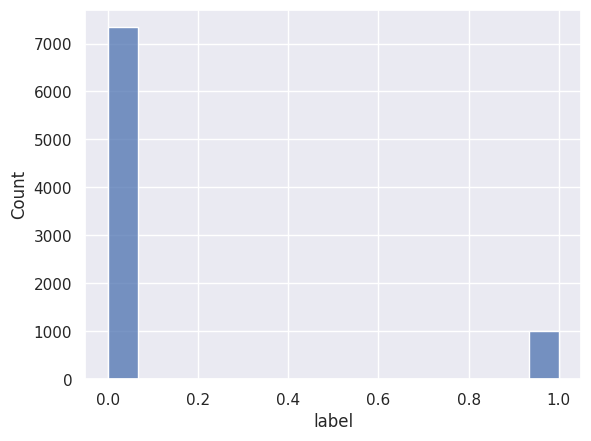

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
sns.histplot(train_df['label'])
plt.show()

In [8]:
train_df.to_csv('./data/train_preprocessed.csv', index=0)

In [1]:
import pickle as pkl
import pandas as pd

train_df = pd.read_csv('./data/train_preprocessed.csv')  # 读取预处理好的训练数据    

smiles_list = train_df["SMILES"].tolist()
pkl.dump(smiles_list, open('./work/train_smiles_list.pkl', 'wb'))

# 测试集
test_df = pd.read_csv('./data/test_nolabel.csv')
smiles_list = test_df["SMILES"].tolist()
pkl.dump(smiles_list, open('./work/test_smiles_list.pkl', 'wb'))

In [2]:
from threading import Thread, Lock
from pahelix.utils.compound_tools import mol_to_geognn_graph_data_MMFF3d
from rdkit.Chem import AllChem

mutex = Lock()  # 互斥锁，防止多个线程同时修改某一文件或某一全局变量，引发未知错误

def calculate_3D_structure_(smiles_list):
    n = len(smiles_list)
    global p
    index = 0
    while True:
        mutex.acquire()  # 获取锁
        if p >= n:
            mutex.release()
            break
        index = p        # p指针指向的位置为当前线程要处理的smiles
        smiles = smiles_list[index]
        print(index, ':', round(index / n * 100, 2), '%', smiles)
        p += 1           # 修改全局变量p
        mutex.release()  # 释放锁
        try:
            molecule = AllChem.MolFromSmiles(smiles)
            molecule_graph = mol_to_geognn_graph_data_MMFF3d(molecule)  # 根据分子力场生成3d分子图
        except:
            print("Invalid smiles!", smiles)
            mutex.acquire()
            with open('./work/invalid_smiles.txt', 'a') as f:
                # 生成失败的smiles写入txt文件保存在该目录下
                f.write(str(smiles) + '\n')
            mutex.release()
            continue

        global smiles_to_graph_dict
        mutex.acquire()   # 获取锁
        smiles_to_graph_dict[smiles] = molecule_graph
        mutex.release()   # 释放锁

for mode in ['train', 'test']:
# for mode in ['test']:
    if mode == 'train':
        smiles_list = train_df["SMILES"].tolist()
    else:
        smiles_list = test_df["SMILES"].tolist()
    global smiles_to_graph_dict
    smiles_to_graph_dict = {}
    global p              # p为全局指针，指向即将要处理的smiles
    p = 0
    thread_count = 12      # 线程数。一般根据当前运行环境下cpu的核数来设定
    threads = []
    for i in range(thread_count):
        threads.append(Thread(target=calculate_3D_structure_, args=(smiles_list, )))
    for t in threads:
        t.start()
    for t in threads:
        t.join()
    pkl.dump(smiles_to_graph_dict, open(f'./work/{mode}_smiles_to_graph_dict.pkl', 'wb'))
    print(f'{mode} is Done!')

[INFO] 2023-06-16 16:45:40,842 [mp_reader.py:   24]:	ujson not install, fail back to use json instead


0 : 0.0 % c1ccc(-c2ccccn2)nc1
1 : 0.01 % COc1ccc(-c2cc(=O)c3c(OC)c(OC)c(OC)c(OC)c3o2)cc1
2 : 0.02 % N#Cc1cnc2cnc(NCc3cccnc3)cc2c1Nc1ccc(F)c(Cl)c1
3 : 0.04 % COc1ccc2c(c1)CN(C(=O)CCl)C(c1ccccc1)C2
4 : 0.05 % Cc1cc2c(F)c(Oc3ncnn4cc(OC[C@@H](C)OC(=O)[C@H](C)N)c(C)c34)ccc2[nH]1
5 : 0.06 % C[C@]12CC/C(=N\OCCN)C[C@@H]1C(=O)C[C@@H]1[C@@H]2CC[C@]2(C)C(=O)CC[C@@H]12
6 : 0.07 % N[C@H]1CCN(O)C1=O
7 : 0.08 % CC(=O)O[C@]1(C(C)=O)CC[C@H]2[C@@H]3C=C(Cl)C4=CC(=O)CC[C@]4(C)[C@H]3CC[C@@]21C
8 : 0.1 % COCCCN1CCC(NC(=O)c2cc(Cl)c(N)c3c2OCC3)CC1
9 : 0.11 % COc1cc(/C=C2\SC(=O)NC2=O)ccc1Oc1ccc(C#N)cc1C(F)(F)F
10 : 0.12 % O=C(Nc1cccnn1)N1CCC(=Cc2cccc(Oc3ccc(C(F)(F)F)cn3)c2)CC1
11 : 0.13 % CSc1ccccc1OCC(O)CNC(C)C
12 : 0.14 % CC(C)Cn1cnc2c1c(=O)n(C)c(=O)n2C
13 : 0.16 % CCn1c(=O)[nH]c2ccccc21
14 : 0.17 % CCCCN1CCCCC1C(=O)Nc1c(C)cccc1C
15 : 0.18 % C#CC1(O)CCC2C3CCC4=CC(=O)CCC4C3CCC21C
16 : 0.19 % Cc1onc(-c2ccccc2Cl)c1C(=O)N(C)c1ccc(Cl)cc1
17 : 0.2 % COc1cccc2cc(-c3nc([C@H]4CC[C@H](C(=O)O)CC4)n4ncnc(N)c34)[nH]c12
1

133 : 1.59 % Clc1ccc(CSC(Cn2ccnc2)c2ccc(Cl)cc2Cl)cc1
134 : 1.61 % CCCN1CCC[C@H](c2cccc(O)c2)C1
135 : 1.62 % COc1cc(OCc2cccc(-c3ccccc3)c2C)cc(OC)c1CN1CCCC[C@H]1C(=O)O
136 : 1.63 % Cc1nc(CN2CC(C(=O)Nc3cncc4cc(S(C)(=O)=O)ccc34)c3cc(Cl)ccc3C2=O)c[nH]1
137 : 1.64 % CCC(C)(C)C(=O)O[C@H]1C[C@@H](C)C=C2C=C[C@H](C)[C@H](CC[C@@H]3C[C@@H](O)CC(=O)O3)[C@H]21
138 : 1.65 % Cc1c(Cl)cccc1Nc1ccccc1C(=O)O
139 : 1.67 % CCCn1c(=O)c2[nH]c(-c3ccc(OCC(=O)Nc4ccc(C#N)cc4)cc3)nc2n(CCC)c1=O
140 : 1.68 % Cc1c(Cl)cccc1S(=O)(=O)Nc1nc(CC(=O)N2CCN(C)CC2)cs1
141 : 1.69 % CC(C)Oc1ccc2c(=O)c3cc(C(=O)O)ccc3oc2c1
142 : 1.7 % CN1C(=O)CCS(=O)(=O)C1c1ccc(Cl)cc1
143 : 1.71 % O=C1OC2(c3ccccc31)c1cc(Br)c(O)c(Br)c1Oc1c2cc(Br)c(O)c1Br
144 : 1.73 % COCC(=O)Nc1c(I)c(C(=O)NC[C@@H](O)CO)c(I)c(C(=O)N(C)C[C@@H](O)CO)c1I
145 : 1.74 % NCCCCCNCC12CC3CC(CC(C3)C1)C2
146 : 1.75 % O=C(O)/C=C1/CCCc2ccccc2C1O
147 : 1.76 % CC[C@H](C)C(=O)O[C@H]1C[C@H](O)C=C2C=C[C@H](C)[C@H](CC[C@@H](O)C[C@@H](O)CC(=O)[O-])[C@H]21
148 : 1.77 % O=C(O)C=C(CC(=O)O)C

[16:45:55] UFFTYPER: Unrecognized charge state for atom: 5


215 : 2.58 % Nc1c2c(nc3c1CCC3)CCCC2
216 : 2.59 % COC1(C(=O)Nc2cncc3ccccc23)CCOc2c(F)cc(F)cc21
217 : 2.6 % Cc1ncc(COP(=O)(O)O)c(C=O)c1O
218 : 2.61 % CC(C)[C@H]1CC[C@H](C(=O)N[C@H](Cc2ccccc2)C(=O)O)CC1
219 : 2.62 % Clc1ccc2c(c1)CCc1cccnc1C2=C1CCNCC1
220 : 2.64 % CN(C)CC[C@@H](c1ccc(Cl)cc1)c1ccccn1
221 : 2.65 % CCCNC(=O)N1N=C(c2ccc(N)cc2)c2cc3c(cc2C1C)OCO3
222 : 2.66 % NC(=O)c1cn(Cc2c(F)cccc2F)nn1
223 : 2.67 % CS(=O)(=O)c1ccc(Oc2cc(F)cc(C#N)c2)c2c1[C@H](O)C(F)(F)C2
224 : 2.68 % Brc1c(Br)c(Br)c2[nH]cnc2c1Br
225 : 2.7 % CN(NC(=O)CC(=O)NN(C)C(=S)c1ccccc1)C(=S)c1ccccc1
226 : 2.71 % O=C1OC(OC(=O)c2cccnc2Nc2cccc(C(F)(F)F)c2)c2ccccc21
227 : 2.72 % CN1CCN(c2c(F)cc3c(=O)c(C(=O)O)cn(CCF)c3c2F)CC1
228 : 2.73 % COc1ccccc1N1CCN(CCN2C(=O)c3ccccc3C(C)(C)C2=O)CC1
229 : 2.74 % COc1ccc(-c2nc(C(=O)N3CCN(C)CC3)sc2-c2ccc(OC)cc2)cc1
230 : 2.76 % CN(C)Cc1c(C(=O)NCCOc2ccc(C(=O)NO)cc2)oc2ccccc12
231 : 2.77 % COc1cc(/C=C/C(=O)N2CCN(CC(=O)N3CCCC3)CC2)cc(OC)c1OC
232 : 2.78 % C=CCN1CCCC1CNC(=O)c1cc2nn[nH]c2cc1OC
233 

351 : 4.21 % CCOC(=O)[C@@H](N)CCC(=O)N[C@@H](CSCc1ccccc1)C(=O)N[C@@H](C(=O)OCC)c1ccccc1
352 : 4.22 % Cc1ccccc1C(C(=O)NC1CCCCC1)N(C(=O)Cn1ccnc1C)c1cccc(F)c1
353 : 4.23 % COc1ccc2cncc(NC(=O)[C@@]3(OC)CCOc4ccc(Cl)cc43)c2c1
354 : 4.24 % CCOc1ccc(-n2c([C@@H](C)N(Cc3cccnc3)C(=O)Cc3ccc(OC(F)(F)F)cc3)nc3ncccc3c2=O)cc1
355 : 4.25 % CCC(=O)O[C@]1(C(=O)CO)CC[C@H]2[C@@H]3CCC4=CC(=O)CC[C@]4(C)[C@H]3CC[C@@]21C
356 : 4.27 % CN(C)c1ccc(/C=C2\C(=O)Nc3ccccc32)cc1
357 : 4.28 % O=C1C=Cc2cc(Br)ccc2C1=O
358 : 4.29 % COc1ccc(CN2CCNCC2)c(OC)c1OC
359 : 4.3 % CC(=O)Nc1ccc(OC[C@](C)(O)C(=O)Nc2ccc([N+](=O)[O-])c(C(F)(F)F)c2)cc1
360 : 4.31 % COc1ccc(CN2CCN(Cc3ccccc3)CC2)cc1
361 : 4.33 % CSCC[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)CNC(=O)CNC(=O)[C@@H](N)Cc1ccc(O)cc1)C(=O)O
362 : 4.34 % O=C(Nc1cncc2ccccc12)[C@H]1COc2ccc(Cl)cc2C1
363 : 4.35 % O=C(c1cc(S(=O)(=O)Nc2ccccc2F)c(F)cc1Cl)N1CCN2CCC[C@@H]2C1
364 : 4.36 % O=C(Nc1cncc2ccccc12)C1COc2ccc(Cl)cc21
365 : 4.37 % CC(=NNC(=N)N)c1cc(NC(=O)CCCCCCCCC(=O)Nc2cc(C(C)=NNC(=N)N)cc(C

487 : 5.84 % CN(C)C
488 : 5.85 % C[C@H](Nc1ncnc2[nH]cnc12)c1cc2ccc(F)cc2nc1-c1ccccn1
489 : 5.86 % CC(C)C[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)CNC(=O)CNC(=O)[C@@H](N)Cc1ccc(O)cc1)C(=O)O
490 : 5.87 % COc1ccc2c(c1)c(CC(=O)OCC(C(=O)O)c1ccccc1)c(C)n2C(=O)c1ccc(Cl)cc1
491 : 5.88 % COC(F)(F)C(Cl)Cl
492 : 5.9 % Cc1cc2cc3c(C)cc(=O)oc3c(C)c2o1
493 : 5.91 % Nc1ccc([As](=O)(O)O)cc1
494 : 5.92 % C[C@H](NC(=O)/C(C#N)=C/c1ccc(O)c(O)c1)c1ccccc1
495 : 5.93 % CS(=O)(=O)NCC1(C(=O)Nc2cncc3ccccc23)CCOc2ccc(Cl)cc21
496 : 5.94 % N#Cc1cc(-c2n[nH]c(-c3ccncc3)n2)ccn1


[16:46:18] UFFTYPER: Unrecognized charge state for atom: 5


497 : 5.96 % O=C(Nc1cncc2ccccc12)C1CCOc2c1ccc(Cl)c2Cl
498 : 5.97 % NS(=O)(=O)c1ccc(-n2nc(C(F)(F)F)cc2-c2ccc(Cl)cc2)cc1
499 : 5.98 % O=C1c2ccccc2-c2n[nH]c3cccc1c23
500 : 5.99 % COc1ccc(C(=O)N2CCCC2=O)cc1
501 : 6.0 % COc1cccc(N(C)C(=S)Oc2ccc3c(c2)CCCC3)n1
502 : 6.02 % [NH3+][Pt-2]1([NH3+])OC(=O)C2(CCC2)C(=O)O1


[16:46:19] UFFTYPER: Unrecognized hybridization for atom: 1
[16:46:19] UFFTYPER: Unrecognized atom type: Pt+2 (1)


503 : 6.03 % Cc1cc(/C=C2\SC(=O)N(c3ccccc3)C2=O)c(C)n1-c1cccnc1
504 : 6.04 % OC[C@H]1NC[C@H](O)[C@@H](O)[C@@H]1O
505 : 6.05 % CCCc1cc(C)[nH]c(=O)c1CNC(=O)c1cc(-c2ccnc(N3CCN(C)CC3)c2)cc2c1cnn2C(C)C
506 : 6.06 % Cc1ccc2c(c1)Cc1c(C(=O)NC3CCCCC3)nn(-c3ccc(Cl)cc3Cl)c1-2
507 : 6.08 % COc1cc(C(C)=O)ccc1O
508 : 6.09 % CC(C)(C=O)Cc1cc(C(C)(C)C)c(O)c(C(C)(C)C)c1
509 : 6.1 % CN1CCN(c2ccc(OC(F)(F)F)c(Nc3ncc4c(n3)-c3c(c(C(N)=O)nn3CCO)CC4)c2)CC1
510 : 6.11 % C=C[C@H]1CN2CC[C@H]1C[C@H]2[C@H](O)c1ccnc2ccccc12
511 : 6.12 % COC(=O)c1c(NCCCc2ccccc2)c2cc(F)ccc2[nH]c1=O
512 : 6.14 % CC(C(=O)Nc1cncc2ccccc12)c1ccc(Cl)c(Cl)c1
513 : 6.15 % O=C(Cc1cccc(Cl)c1)Nc1cncc2ccc(C(=O)O)cc12
514 : 6.16 % CC(C)CN(C[C@@H](O)[C@H](Cc1ccccc1)NC(=O)O[C@H]1CCOC1)S(=O)(=O)c1ccc(N)cc1
515 : 6.17 % N#Cc1c(Oc2ccc(F)c(NC(=O)Cc3cccc(C(F)(F)F)c3)c2)ccc2nc(NC(=O)C3CC3)sc12
516 : 6.18 % Cc1ccc(Oc2nc3cc(Cl)c(-c4ccc5c(ccn5C)c4)cc3[nH]2)cc1C(=O)O
517 : 6.2 % CCOc1cc(N)c(Cl)cc1C(=O)NCC1CN(Cc2ccc(F)cc2)CCO1
518 : 6.21 % COc1cc(C)c2c(c1C=O)Oc

[16:46:20] UFFTYPER: Unrecognized atom type: Au6+3 (6)


524 : 6.28 % Cc1ccc([N+](=O)[O-])cc1S(=O)(=O)N(C)C
525 : 6.29 % NC(=O)c1cnc(N[C@@H]2CCCC[C@@H]2N)nc1Nc1cccc(-n2nccn2)c1
526 : 6.3 % CN1C(=O)C(Cc2c[nH]c3ccccc23)NC1=S
527 : 6.32 % CCCCCCCCCCCCCCCC(=O)OC(C)C
528 : 6.33 % Cn1c(Nc2ccc(C(F)(F)F)cc2)nc2cc(Oc3ccnc(-c4ncc(C(F)(F)F)[nH]4)c3)ccc21
529 : 6.34 % CC1(C)CC(O)CC(C)(C)N1O
530 : 6.35 % Cc1ccncc1NC(=O)Cc1cccc(I)c1
531 : 6.36 % O=C(Cc1ccc2[nH]c(=O)[nH]c2c1)NC1(CNC(=O)c2cnc[nH]2)CC1
532 : 6.38 % CCCC(CCC)C(=O)[O-]
533 : 6.39 % Cc1cccc2cncc(NC(=O)Cc3cccc(Cl)c3)c12
534 : 6.4 % N[C@@H](CCNCc1ccc(Cl)cc1)C(=O)N1CCCCC1
535 : 6.41 % C[C@@H]1NC(=O)c2ccc(Cl)cc2[C@@H]1C(=O)Nc1cncc2ccccc12
536 : 6.42 % Cc1ncc(CO)c(CN)c1O
537 : 6.43 % Nc1ccncc1
538 : 6.45 % O=C(NO)C1(CS(=O)(=O)c2ccc(Oc3ccc(Cl)cc3)cc2)CCOCC1
539 : 6.46 % CNc1nc(NCc2ccc(NS(C)(=O)=O)cc2Cl)cc(-c2ccccn2)n1
540 : 6.47 % COc1cc(/C=C2\CCCN([C@@H](C)c3ccc(F)cc3)C2=O)ccc1-n1cnc(C)c1
541 : 6.48 % Cc1cc(O)c2c(=O)c3c(O)cc(O)c4c5c(O)cc(O)c6c(=O)c7c(O)cc(C)c8c1c2c(c34)c(c78)c65
542 : 6.49 % Cc1noc(

[16:46:23] UFFTYPER: Unrecognized charge state for atom: 7
[16:46:23] UFFTYPER: Unrecognized atom type: Zn2+2 (7)
[16:46:23] UFFTYPER: Unrecognized charge state for atom: 7
[16:46:23] UFFTYPER: Unrecognized atom type: Zn2+2 (7)
[16:46:23] Could not triangle bounds smooth molecule.


570 : 6.83 % CN(C(=O)CN1C(=O)COc2cc(Cl)c(Cl)cc21)[C@@H](CN1CCCC1)c1ccc(-c2cccc(C(N)=O)c2)cc1
571 : 6.84 % Oc1c(Cl)cc(Cl)c2cccnc12
572 : 6.85 % COCCNCc1ccc(-c2cc3nccc(Oc4ccc(NC(=O)C5(C(=O)Nc6ccc(F)cc6)CC5)cc4F)c3s2)nc1
573 : 6.87 % COc1ccc(C2Oc3c(CC=C(C)C)c(O)cc(O)c3C(=O)C2=O)cc1
574 : 6.88 % CC[C@@H](Nc1c(Nc2cccc(C(=O)N(C)C)c2O)c(=O)c1=O)c1ccc(C)o1
575 : 6.89 % O=C(O)c1cc(-c2ccccc2)nc2ccccc12
576 : 6.9 % COC(=O)Nc1nc2ccc(C(=O)c3cccs3)cc2[nH]1
577 : 6.91 % COc1ccc(/C=C/C(=O)Nc2ccccc2C(=O)O)cc1OC
578 : 6.93 % C[C@H](N)C(=O)NCC(=O)N[C@H]1CSSC[C@@H](C(=O)O)NC(=O)[C@H](CO)NC(=O)[C@H]([C@@H](C)O)NC(=O)[C@H](Cc2ccccc2)NC(=O)[C@H]([C@@H](C)O)NC(=O)[C@H](CCCCN)NC(=O)[C@H](Cc2c[nH]c3ccccc23)NC(=O)[C@H](Cc2ccccc2)NC(=O)[C@H](Cc2ccccc2)NC(=O)[C@H](CC(N)=O)NC(=O)[C@H](CCCCN)NC1=O
579 : 6.94 % O=C(CCl)N1CCN(Cc2cc(O)cc(Cl)c2)CC1
580 : 6.95 % CCOC(=O)c1ccc(-n2cc(Cc3cnc(OCC)nc3)c(=O)nc2SCc2ccc(F)cc2)cc1
581 : 6.96 % CC(C)C[C@H](CN)CC(=O)O
582 : 6.97 % O=C(Nc1ccc([N+](=O)[O-])cc1O)Nc1ccccc1Br
583 : 6.99

687 : 8.23 % CC(C)(O)c1ccccc1CC[C@@H](SCC1(CC(=O)O)CC1)c1cccc(/C=C/c2ccc3ccc(Cl)cc3n2)c1
688 : 8.24 % O=C1NN(C(=O)Nc2ccc(Br)cc2)[C@@H](c2ccccc2)[C@@H]1c1ccccc1
689 : 8.26 % O=S(=O)(NCCCCCCc1ccccc1)c1cccc2c(Cl)cccc12
690 : 8.27 % CC(C)(C)C(O)/C=C/c1ccc2c(c1)OCO2
691 : 8.28 % COc1ccc(-c2nc(N3CCOCC3)c3sc(CN(C)c4ncc(C(=O)NO)cn4)cc3n2)cn1
692 : 8.29 % Cc1c(-c2ccc(N3CCc4cccc(C(=O)Nc5nc6ccccc6s5)c4C3)nc2C(=O)O)cnn1CC12CC3CC(CC(C3)C1)C2
693 : 8.3 % COc1ccc2cc(OCC3(C(=O)O)CN(C(=O)c4ccc(F)cc4)C3)ccc2c1
694 : 8.32 % O=C(Cc1cc(F)cc(F)c1)Nc1cncc2ccccc12
695 : 8.33 % NS(=O)(=O)c1cc(Cl)c(Cl)c(S(N)(=O)=O)c1
696 : 8.34 % FC(F)(F)c1ccc(/C=C/c2nc(COc3ccc(CCCCn4ccnn4)cc3)co2)cc1
697 : 8.35 % CC(C)(C(=O)c1cccnc1)c1cccnc1
698 : 8.36 % CC(C)(C)NC[C@@H](O)COc1nsnc1N1CCOCC1
699 : 8.38 % O=c1oc(Nc2ccccc2)nc2ccccc12
700 : 8.39 % N=C(NCCCCCCNC(=N)NC(=N)Nc1ccc(Cl)cc1)NC(=N)Nc1ccc(Cl)cc1
701 : 8.4 % O=C(NNc1nc2cc(F)ccc2n2cccc12)c1cnccn1
702 : 8.41 % O=C1[C@@H]2[C@H]3CC[C@H](C3)[C@@H]2C(=O)N1CCCCN1CCN(c2ncccn2)CC1
7

814 : 9.75 % Cc1sc2c(c1C)C(c1ccc(Cl)cc1)=N[C@@H](CC(N)=O)c1nnc(C)n1-2
815 : 9.77 % CN1[C@@H]2CC[C@@H]1CC(OC(c1ccccc1)c1ccccc1)C2
816 : 9.78 % CC(C)COCC(CN(Cc1ccccc1)c1ccccc1)N1CCCC1
817 : 9.79 % CCOc1ccc(C(=O)OCCN(C)C)cc1
818 : 9.8 % O=C(Cc1cc(Cl)cc(-c2nnc[nH]2)c1)Nc1cncc2ccccc12
819 : 9.81 % Oc1cc(O)c2cc(O)c(-c3cc(O)c(O)c(O)c3)[o+]c2c1
820 : 9.83 % CC(=O)c1ccc(NS(C)(=O)=O)c(Oc2ccc(F)cc2F)c1
821 : 9.84 % CC1=C(/C=C/C(C)=C/C=C/C(C)=C/C=O)C(C)(C)CCC1
822 : 9.85 % CCCCC1(COC(=O)CCC(=O)O)C(=O)N(c2ccccc2)N(c2ccccc2)C1=O
823 : 9.86 % Cc1cc(NS(=O)(=O)c2ccc(NC(=O)Cc3ccc(Cl)c(Cl)c3)cc2)no1
824 : 9.87 % COc1ccccc1-c1c[nH]c2ncc(-c3cncc(C(=O)N(C)C)c3)cc12
825 : 9.89 % Oc1cc(-c2ccccc2)[o+]c2c1ccc1ccccc12
826 : 9.9 % CC(C)(O)CC(=O)O
827 : 9.91 % COc1ccc(-n2c(C)c([N+](=O)[O-])c3ccc(O)cc32)cc1
828 : 9.92 % CN(C)[C@]1(c2ccccc2)CC[C@]2(CC1)OCCc1c3cc(F)ccc3[nH]c12
829 : 9.93 % CS(=O)(=O)c1cccc(CNc2nc(Nc3ccc4c(c3)CCC(=O)N4)ncc2C(F)(F)F)c1
830 : 9.95 % C/C=C1\C(=O)C[C@H]2[C@@H]3CCC4=CC(=O)CC[C@]4(C)[C@H]3C

[16:46:52] UFFTYPER: Unrecognized atom type: Se2+2 (8)
[16:46:52] UFFTYPER: Unrecognized atom type: Se2+2 (8)


847 : 10.15 % O=C(NCCCCCCNC(=O)ON=C1CCCCC1)ON=C1CCCCC1
848 : 10.16 % C[N+]1(C)CCC(=C(c2ccccc2)c2ccccc2)CC1
849 : 10.17 % CN(Cc1ccccc1)C(=O)[C@H](Cc1ccc2ccccc2c1)NC(=O)[C@@H]1CCCN1C(=O)Nc1ccccc1[N+](=O)[O-]
850 : 10.19 % N#CCc1ccccc1C#Cc1ccc(CCC(=O)O)c(F)c1
851 : 10.2 % COC(=O)/C=C/c1cccc(N(Cc2ccc(-c3ccc(N(C)C)cc3)cc2)C(=O)C2CCCCC2)c1
852 : 10.21 % COc1ccccc1OCC(O)COC(N)=O
853 : 10.22 % C[C@]12CC[C@@H]3c4ccc(O)cc4CC[C@H]3[C@@H]1C[C@@H](O)[C@@H]2O
854 : 10.23 % Cc1c[nH]c(-c2cnc(NCCNc3ccc(C#N)cn3)nc2-c2ccc(Cl)cc2Cl)n1
855 : 10.25 % N#Cc1cccc(C(=O)Nc2cc(-c3ccccc3)nn2-c2ccccc2)c1
856 : 10.26 % COc1cc2nc(N3CCN(C(=O)C4COc5ccccc5O4)CC3)nc(N)c2cc1OC
857 : 10.27 % COc1cc2c(N3CCN(C(=O)Nc4ccc(OC(C)C)cc4)CC3)ncnc2cc1OCCCN1CCCCC1
858 : 10.28 % S=c1[nH]cnc2nc[nH]c12
859 : 10.29 % NC(=S)N/N=C/c1ncccc1N
860 : 10.31 % CC(C)[C@H](C(=O)Nc1ccc(C(=O)NO)cc1)c1ccccc1
861 : 10.32 % O=C(Nc1cncc2ccccc12)N(CCC1CCCCC1)c1cccc(Cl)c1
862 : 10.33 % CCn1c(N)c(C(=O)NC)c(=O)c2ccc(C#C[C@@](C)(O)COC)nc21
863 : 10.34 % O=C(

[16:47:02] UFFTYPER: Unrecognized charge state for atom: 21


962 : 11.53 % Cc1cc(C(C)(C)CC(C)(C)C)ccc1OCCOCC[N+](C)(C)Cc1ccccc1
963 : 11.54 % Oc1cc2c(cc1O)[C@@H]1c3ccc(O)c(O)c3OC[C@]1(O)C2
964 : 11.55 % Nc1ccccc1NC(=O)c1ccc(CNc2nccc(-c3cccnc3)n2)cc1
965 : 11.56 % O=C(Nc1cc(-c2ccccc2)nn1-c1ccccc1F)c1ccc([N+](=O)[O-])cc1
966 : 11.58 % CCC(C)(C)C(=O)C(=O)N1CCC[C@H]1C(=O)OCCCc1cccnc1
967 : 11.59 % NC[C@H]1O[C@H](O[C@H]2[C@H](O)[C@@H](O[C@H]3O[C@H](CO)[C@@H](O)[C@H](N)[C@H]3O)[C@H](N)C[C@@H]2N)[C@H](N)[C@@H](O)[C@@H]1O
968 : 11.6 % CCNc1ncc(C#N)cc1CN1CCN(C(=O)CCl)CC1
969 : 11.61 % CC(=O)N[C@@H](CC(C)C)C(=O)O
970 : 11.62 % CCCc1cc2c(N3CCN(C4=NCC(C)(C)S4)CC3)ncnc2s1
971 : 11.64 % O=C(O)c1ccc(N2C(=O)/C(=C/c3ccc(-c4ccc([N+](=O)[O-])cc4)o3)C=C2c2ccccc2)cc1
972 : 11.65 % CC[n+]1c(-c2ccccc2)c2cc(N)ccc2c2ccc(N)cc21
973 : 11.66 % COc1ccc2c(c1)c(CC(=O)N1CCOCC1)c(C)n2C(=O)c1ccc(Cl)cc1
974 : 11.67 % O=C(N[C@H](CO)[C@H](O)c1ccc([N+](=O)[O-])cc1)C(Cl)Cl
975 : 11.68 % CC(C)NCCCn1c(Sc2cc3c(cc2I)OCO3)nc2c(N)ncnc21
976 : 11.7 % CO[C@H]1CC=C2CCN3CCC4=C(CC(=O)OC4)[C@]23

1086 : 13.01 % CC(=O)c1ccc2c(c1)[C@H](NC(=O)c1ccc(F)c(Cl)c1)[C@H](O)C(C)(C)O2
1087 : 13.03 % COC(=O)C1=C(C)NC(C)=C(C(=O)O[C@H]2CCN(Cc3ccccc3)C2)[C@H]1c1cccc([N+](=O)[O-])c1
1088 : 13.04 % COC(=O)C1=C(C)NC(C)=C([N+](=O)[O-])C1c1ccccc1C(F)(F)F
1089 : 13.05 % CC(=O)NC[C@H]1CN(c2ccc(N3CCSCC3)c(F)c2)C(=O)O1
1090 : 13.06 % CC(C)(O)c1ccccc1CC[C@@H](SCC1(CC(=O)[O-])CC1)c1cccc(/C=C/c2ccc3ccc(Cl)cc3n2)c1
1091 : 13.07 % C[C@]12CC[C@@H]3c4ccc(OC(=O)N(CCCl)CCCl)cc4CC[C@H]3[C@@H]1CC[C@@H]2OP(=O)(O)O
1092 : 13.09 % COc1cc2c(cc1Cc1cccc(Cl)c1F)c(=O)c(C(=O)O)cn2[C@H](CO)C(C)C
1093 : 13.1 % CC(C)(C)OC(=O)c1ncn2c1[C@@H]1CCCN1C(=O)c1c(Br)cccc1-2
1094 : 13.11 % CO[C@@]1(C(=O)Nc2cncc3ccccc23)CCOc2ccc(Cl)cc21
1095 : 13.12 % CCCn1c(=O)c(C)cn2nc(N)nc12
1096 : 13.13 % COc1ccc(-c2oc3cc(OC)ccc3c2C(=O)c2ccc(C#N)cc2)cc1
1097 : 13.15 % Cc1cc(C(F)(F)F)nc2n[nH]c(NC(=O)Cc3cccc(Cl)c3)c12
1098 : 13.16 % NCC(=O)Nc1ccc(-n2nc(C(F)(F)F)cc2-c2ccc3c(ccc4ccccc43)c2)cc1
1099 : 13.17 % O=C(NO)c1ccc(O)c(O)c1
1100 : 13.18 % COc1cc(C

[16:47:27] UFFTYPER: Warning: hybridization set to SP3 for atom 14
[16:47:27] UFFTYPER: Warning: hybridization set to SP3 for atom 27
[16:47:27] UFFTYPER: Warning: hybridization set to SP3 for atom 36
[16:47:27] UFFTYPER: Warning: hybridization set to SP3 for atom 45
[16:47:27] UFFTYPER: Warning: hybridization set to SP3 for atom 54
[16:47:27] UFFTYPER: Warning: hybridization set to SP3 for atom 63
[16:47:27] UFFTYPER: Warning: hybridization set to SP3 for atom 72
[16:47:27] UFFTYPER: Warning: hybridization set to SP3 for atom 76


1184 : 14.19 % C#C[C@]1(O)CC[C@H]2[C@@H]3CCC4=CC(=O)CC[C@]4(C)[C@H]3CC[C@@]21C
1185 : 14.2 % Cc1nc(NC(=O)N2CCC[C@H]2C(N)=O)sc1-c1ccnc(C(C)(C)C(F)(F)F)c1
1186 : 14.21 % O=S(=O)(O)c1cc(O)ccc1O
1187 : 14.22 % O=c1ccn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)[nH]1
1188 : 14.24 % Oc1c(Br)cc(Br)c2cccnc12
1189 : 14.25 % CCCOc1ccc(Br)cc1-c1cc(-c2ccc(Cl)cc2)[nH]c1-c1ccncc1
1190 : 14.26 % O=C(Nc1cccc(C(F)(F)F)c1)Nc1cc(S(=O)(=O)NC2CC2)ccc1-c1ccsc1
1191 : 14.27 % CN(C(=O)Cc1ccc(Cl)c(Cl)c1)[C@H]1CCCC[C@@H]1N1CCCC1
1192 : 14.28 % COc1ccc2c(C(=S)N(C)CC(=O)O)cccc2c1C(F)(F)F
1193 : 14.3 % COC(=O)Nc1nc2cc(SC(C)C)ccc2[nH]1
1194 : 14.31 % N[C@@H](C(=O)N[C@@H]1C(=O)N2C(C(=O)O)=C(Cl)CC[C@H]12)c1ccccc1
1195 : 14.32 % CC(=O)NCCC(=O)N[C@@H](Cc1cnc[nH]1)C(=O)O
1196 : 14.33 % OCCN1C[C@@H](O)[C@@H](O)C(O)C1CO
1197 : 14.34 % Cc1ccc(CNc2ncnc3ccc(-c4ccc(CO)o4)cc23)o1
1198 : 14.36 % Cc1cccc(N2CC(CO)OC2=O)c1
1199 : 14.37 % Cc1c(N(C)C)c(=O)n(-c2ccccc2)n1C
1200 : 14.38 % C=CCNc1c(O)cc2c(O)c1C[C@@H](C)C[C@H](OC)[C@H](O)[C@

1309 : 15.69 % Cc1cc(C)c(S(=O)(=O)N2CCCC2=O)c(C)c1
1310 : 15.7 % Oc1ccc(Cl)cc1Cc1cc(Cl)ccc1O
1311 : 15.71 % NCCCC[C@H](NC(=O)[C@@H](Cc1cc(Br)c(O)c(Br)c1)NC(=O)N1CCC(N2Cc3ccccc3NC2=O)CC1)C(=O)N1CCN(c2ccncc2)CC1
1312 : 15.72 % CCCCCCNC(=O)Nc1ccc(S(=O)(=O)Nc2ccc(CCNC[C@H](O)COc3ccc(O)cc3)cc2)cc1
1313 : 15.73 % C[C@H](N[C@@H](CCc1ccccc1)C(=O)O)C(=O)N1CCC[C@H]1C(=O)O
1314 : 15.75 % Cc1ccc2nc(NCCN)c3ncc(C)n3c2c1
1315 : 15.76 % Cc1ccc2[nH]c(SCc3ccccn3)nc2c1
1316 : 15.77 % OC(CCN1CCCCC1)(c1ccccc1)C1CC2C=CC1C2
1317 : 15.78 % CCCc1c(OCCCOc2ccc(OCC(=O)O)cc2)ccc(C(C)=O)c1O
1318 : 15.79 % O=C1N=C(O)NC1(c1ccccc1)c1ccccc1
1319 : 15.81 % C[n+]1ccccc1C=NO
1320 : 15.82 % O=C(O)[C@@H]1C[C@@H](C2CCCCC2)CN1C(=O)CP(=O)(O)CCCCc1ccccc1
1321 : 15.83 % O=C(Nc1cncc2ccccc12)C1CCN(Cc2ncc[nH]2)c2ccc(Cl)cc21
1322 : 15.84 % O=C(NC[C@H]1CN(c2ccc(N3CCOCC3=O)cc2)C(=O)O1)c1ccc(Cl)s1
1323 : 15.85 % C/C(=N\NC(=O)[C@@H]1C(=O)NC[C@H]1c1ccccc1)c1cccc(Br)c1
1324 : 15.87 % CCCCCOc1c(OC)ccc2cc(C(=O)NCc3ccc4c(c3)OCO4)c(=O)[nH]c12

[16:47:54] UFFTYPER: Unrecognized atom type: S_6+6 (10)


1395 : 16.72 % CN(C)C(=O)COC(=O)Cc1ccc(OC(=O)c2ccc(NC(=N)N)cc2)cc1
1396 : 16.73 % O=C1NC(=O)/C(=C\c2cccc(C(F)(F)F)c2)S1
1397 : 16.74 % CN1CCCC(n2nc(Cc3ccc(Cl)cc3)c3ccccc3c2=O)CC1
1398 : 16.75 % Fc1ccc(C(OCCN2CCN(CCCc3ccccc3)CC2)c2ccc(F)cc2)cc1
1399 : 16.76 % CC(C)[C@@H](C(=O)Nc1nccs1)c1ccc(Cl)cc1
1400 : 16.78 % O=C(/C=C/c1ccc(O)c(O)c1)O[C@@H]1[C@H](O)C[C@@](O)(C(=O)O)C[C@H]1OC(=O)/C=C/c1ccc(O)c(O)c1
1401 : 16.79 % O=C(O)C(Cc1ccccc1)CN(O)C(=O)Cc1ccccc1
1402 : 16.8 % Cn1c(=O)c(F)c(Nc2ccc(I)cc2F)c2c(=O)n(C[C@@H](O)CO)cnc21
1403 : 16.81 % CC(CN(C)C)CN1c2ccccc2CCc2ccccc21
1404 : 16.82 % CCc1c(-c2ccc3[nH]ncc3c2)cnc(N)c1-c1ccc(O)cc1
1405 : 16.84 % CCC(=O)N1CCC(NC(=O)Nc2ccc(OC(F)(F)F)cc2)CC1
1406 : 16.85 % Clc1ccc(N2CCN(Cc3c[nH]c4ncccc34)CC2)cc1
1407 : 16.86 % CCc1c(C)[nH]c2c1C(=O)C(CN1CCOCC1)CC2
1408 : 16.87 % OC[C@H]1O[C@@H](O)[C@@H](F)[C@@H](O)[C@@H]1O
1409 : 16.88 % Cc1nc(C#Cc2ccnc(Cl)c2)c(C)n1-c1ccc(OC(F)(F)F)cc1
1410 : 16.9 % O=C(O)COc1ccc(/C=N/NC(=O)c2ccc(-c3csc(Nc4ccc(Cl)cc4)n3)cc2)cc1

1518 : 18.19 % COc1cc(-n2c(=S)[nH]c3ccccc3c2=O)c(Cl)cc1Cl
1519 : 18.2 % O=C1CCCC2C3CC(CN12)[C@@H]1CCCCN1C3
1520 : 18.21 % CC(C)(Oc1ccc(C(=O)c2ccc(Cl)cc2)cc1)C(=O)O
1521 : 18.23 % CC(C)(O)CS(=O)(=O)Nc1ccc2c(c1)CCN(C(=O)COc1cccnc1)C2
1522 : 18.24 % CC(=O)OCC(=O)[C@H]1CC[C@H]2[C@@H]3CCC4=CC(=O)CC[C@]4(C)[C@H]3CC[C@]12C
1523 : 18.25 % O=c1cc(-c2ccc(O)c(O)c2)oc2cc(O[C@@H]3O[C@H](CO)[C@@H](O)[C@H](O)[C@H]3O)cc(O)c12
1524 : 18.26 % CNC1CCCN(c2c(F)cc3c(=O)c(C(=O)O)cn(C4CC4)c3c2OC)C1
1525 : 18.27 % C[C@]12CC[C@H](O)CC1=CC[C@@H]1[C@@H]2CC[C@]2(C)C(=O)CC[C@@H]12
1526 : 18.29 % O=C(Nc1ccc(Oc2ccc(Cl)cn2)c(Cl)c1)c1ccccn1
1527 : 18.3 % N#Cc1c(O)c2c(-c3ccc(-c4ccccc4O)cc3)csc2[nH]c1=O
1528 : 18.31 % CC(C)[C@H]1C(=O)N[C@@H](CCCNC(=N)N)C(=O)NCC(=O)N[C@@H](CC(=O)O)C(=O)N[C@H](Cc2ccccc2)C(=O)N1C
1529 : 18.32 % FC(F)(F)c1cc(NC(=S)Nc2ccc(Br)cc2-c2nnn[nH]2)cc(C(F)(F)F)c1
1530 : 18.33 % O=C(Nc1cccc(Cl)c1)Nc1ncc(CCNc2ncnc3ccsc23)s1
1531 : 18.35 % NC(=O)Nc1cc(-c2cccc(F)c2)sc1C(=O)N[C@H]1CCCNC1
1532 : 18.36 % CCc

[16:48:17] UFFTYPER: Unrecognized atom type: Zn1+2 (10)


1565 : 18.75 % Clc1cccc(Cl)c1CSc1nnc(-c2cnccn2)s1
1566 : 18.77 % NC(=O)C[S@@+]([O-])C(c1ccccc1)c1ccccc1
1567 : 18.78 % CS(=O)(=O)Nc1ccc2c(NC(=O)Cc3cccc(Cl)c3)cncc2c1


[16:48:18] UFFTYPER: Unrecognized charge state for atom: 4


1568 : 18.79 % COc1cc(OC)c2c(=O)nc(-c3cc(C)c(OCCO)c(C)c3)[nH]c2c1
1569 : 18.8 % Cc1c(C)c2c(c(C)c1O)CCC(C)(C(=O)O)O2
1570 : 18.81 % CCC(C)n1ncn(-c2ccc(N3CCN(c4ccc(OCC5COC(Cn6cncn6)(c6ccc(Cl)cc6Cl)O5)cc4)CC3)cc2)c1=O
1571 : 18.83 % COC(C)(C)CS(=O)(=O)N1Cc2ccc(Cl)cc2C(C(=O)Nc2cncc3ccccc23)C1
1572 : 18.84 % C=CC(=O)NCCC(=O)N(Cc1ccccc1)Cc1nc2ccccc2c(=O)[nH]1
1573 : 18.85 % CNC(=O)[C@@H](NC(=O)[C@H](CC(C)C)[C@H](O)C(=O)NO)C(C)(C)C
1574 : 18.86 % O=C1CN2C(=N1)N(Cc1ccccc1)c1ccccc12
1575 : 18.87 % FC(F)(F)c1ccc(CNc2ccc(Cc3c[nH]c4ncc(Cl)cc34)cn2)cn1
1576 : 18.89 % Oc1c(I)cc(Cl)c2cccnc12
1577 : 18.9 % CC(C)(C)NCc1ccc(Nc2ccnc3cc(Cl)ccc23)cc1O
1578 : 18.91 % CCNC(=O)CCC/C=C\C[C@@H]1[C@@H](/C=C/C(O)CCc2ccccc2)[C@H](O)C[C@@H]1O
1579 : 18.92 % O=C1CCc2cc(OCCCCc3nnnn3C3CCCCC3)ccc2N1
1580 : 18.93 % O=C(Cc1cccc(Cl)c1)NC1COCc2ccccc21
1581 : 18.95 % O=C(Cc1c[nH]c2cc(Cl)ccc12)Nc1cccc2[nH]c(=O)[nH]c12
1582 : 18.96 % CC(C)Oc1ccc(-c2nc(-c3cccc4c3CC[C@@H]4NCCO)no2)cc1C#N
1583 : 18.97 % COC(=O)[C@@H](N)Cc1ccc(O)

[16:48:19] UFFTYPER: Unrecognized charge state for atom: 1


1587 : 19.02 % COc1cc2c(O)c3c(c(-c4ccc5c(c4)OCO5)c2cc1OC)C(=O)OC3
1588 : 19.03 % Nc1nc(/C(=C/CC(=O)O)C(=O)N[C@@H]2C(=O)N3C(C(=O)O)=CCS[C@H]23)cs1
1589 : 19.04 % O=C(O)CNC(=O)C(CS)Cc1ccccc1
1590 : 19.05 % CC(=O)O[Hg]c1ccccc1
1591 : 19.07 % COc1cc2c(cc1OC)CN(C(=O)/C=C/c1c(-c3ccccc3)n(C)c3ncccc13)CC2
1592 : 19.08 % C[C@@H](O)[C@H]1C(=O)N2C(C(=O)O)=C(SCCNC=N)C[C@H]12
1593 : 19.09 % O=C1NC2(CCOc3ccc(Cl)cc32)C(=O)N1c1cncc2ccccc12
1594 : 19.1 % CCCCCCCC(=O)N[C@H](CN1CCCC1)[C@H](O)c1ccc2c(c1)OCCO2
1595 : 19.11 % CCN(CC)CCOC(=O)c1ccc(N)cc1Cl
1596 : 19.13 % N#Cc1c(NS(=O)(=O)c2ccccc2)n(Cc2ccccc2)c2nc3ccccc3nc12
1597 : 19.14 % COc1cccc(N2CCN(C3=Nc4c(F)cccc4[C@H](CC(=O)O)N3c3cc(C(F)(F)F)ccc3OC)CC2)c1
1598 : 19.15 % CCN(c1ccccc1)c1c/c(=N/C)n(C)c(C)n1
1599 : 19.16 % CC(=O)c1ccc2c(c1)N(CCCN(C)C)c1ccccc1S2
1600 : 19.17 % C[N+](C)(C)CCCCCNCC12CC3CC(CC(C3)C1)C2
1601 : 19.19 % O=C(O)COc1cccc(CN(Cc2ccc(-n3cccn3)cc2)S(=O)(=O)c2cccnc2)c1
1602 : 19.2 % COc1cc(C[C@H](C)[C@H](C)Cc2ccc3c(c2)OCO3)ccc1O
1603 : 19.

[16:48:22] UFFTYPER: Unrecognized atom type: Ag6+1 (9)


1608 : 19.27 % Cc1cc2nc3ccc(N(C)C)cc3[s+]c2cc1N
1609 : 19.28 % COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1NC(=O)/C=C/CN1CCCCC1
1610 : 19.29 % CN1CCCC1c1cccnc1
1611 : 19.3 % Cc1onc(O)c1C[C@H](N)C(=O)O
1612 : 19.32 % CC[C@H]1OC(=O)[C@H](C)[C@@H](O[C@H]2C[C@@](C)(OC)[C@@H](O)[C@H](C)O2)[C@H](C)[C@@H](O[C@@H]2O[C@H](C)C[C@H](N(C)C)[C@H]2O)[C@](C)(OC)C[C@@H](C)C(=O)[C@H](C)[C@@H](O)[C@]1(C)O
1613 : 19.33 % CN(C)CC(=O)Nc1ccc2[nH]c(=O)c3ccccc3c2c1
1614 : 19.34 % Nc1nc(NC[C@H]2CC[C@H](CNS(=O)(=O)c3cccc4ccccc34)CC2)nc2ccccc12
1615 : 19.35 % N#Cc1cc2cc(CN3CCC(Nc4ncnc5sc(CC(F)(F)F)cc45)CC3)ccc2[nH]1
1616 : 19.36 % NCc1ccc(-c2cccnc2)o1
1617 : 19.38 % Cc1onc(-c2c(F)cccc2Cl)c1C(=O)N[C@@H]1C(=O)N2[C@@H]1SC(C)(C)[C@@H]2C(=O)[O-]
1618 : 19.39 % CN1CCc2cccc3c2[C@H]1Cc1ccc(O)c(O)c1-3
1619 : 19.4 % CC(C)CC(N(C)C)C1(c2ccc(Cl)cc2)CCC1
1620 : 19.41 % COc1cc2cc(c1Cl)N(C)C(=O)C[C@H](OC(=O)C(C)C)[C@]1(C)O[C@H]1[C@H](C)[C@@H]1C[C@@](O)(NC(=O)O1)[C@H](OC)/C=C/C=C(\C)C2
1621 : 19.42 % O=C(O)c1cccc(-c2noc(-c3ccccc3F)n2)c1
1

1731 : 20.74 % CN(C)CCC(c1ccc(Br)cc1)c1ccccn1
1732 : 20.75 % CNC(=O)c1ccc(Oc2ccc3c(c2)CCN(C2CCC2)CC3)nc1
1733 : 20.77 % c1ccc(-c2n[nH]cc2-c2ccnc3ccccc23)nc1
1734 : 20.78 % Cc1cc(O)c(-c2ccc([C@@H](C)CN)cc2)c2c1[nH]c(=O)c1sccc12
1735 : 20.79 % N#Cc1ccc2[nH]c(O)c(-c3ccc(CN4CCOCC4)cn3)c2c1
1736 : 20.8 % N[C@@H](Cc1cc(I)c(Oc2ccc(O)c(I)c2)c(I)c1)C(=O)O
1737 : 20.81 % CNC(=O)CN1CC(C)(C(=O)Nc2cncc3ccccc23)c2cc(Cl)ccc2C1=O
1738 : 20.83 % O=C(Nc1cncc2ccncc12)[C@@H]1CCOc2cc(F)c(Cl)cc21
1739 : 20.84 % CCC[C@@H]1CC(=O)N([C@@H](CC)C(N)=O)C1
1740 : 20.85 % COc1cccc([C@]2(O)CCCC[C@H]2CN(C)C)c1
1741 : 20.86 % Oc1ccc2ccccc2c1Cc1c(O)ccc2ccccc12
1742 : 20.87 % OCCN1CCN(CCCN2c3ccccc3Sc3ccc(Cl)cc32)CC1
1743 : 20.89 % C[N+]1(C)[C@@H]2C[C@@H](OC(=O)[C@H](CO)c3ccccc3)C[C@H]1[C@@H]1O[C@@H]12
1744 : 20.9 % O=C(Cc1ccc(Cl)c(Cl)c1)Nc1cncc2cnccc12
1745 : 20.91 % C#Cc1cccc2c1c(C(=O)c1ccc(Cn3c(C)nc4cnccc43)c(F)c1)cn2C(=O)N(C)C
1746 : 20.92 % CC(C)C[C@@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O
1747 : 20.93 % Nc1c2c(nc3ccc

[16:48:42] UFFTYPER: Unrecognized charge state for atom: 17


1770 : 21.21 % CCN(CC)Cc1ccc2cc(COC(=O)Nc3ccc(C(=O)NO)cc3)ccc2c1
1771 : 21.22 % O=C(OC(C(F)(F)F)C(F)(F)F)N1CCC(C(O)(c2ccc3c(c2)OCO3)c2ccc3c(c2)OCO3)CC1
1772 : 21.23 % Nc1cc(Cl)c(N=C2NCCN2)c(Cl)c1
1773 : 21.25 % Cn1c(NCCN(CCO)CCCc2ccc([N+](=O)[O-])cc2)cc(=O)n(C)c1=O
1774 : 21.26 % CCN(Cc1ccc(F)cc1)c1cc(Cl)cc(CC(=O)Nc2cncc3ccccc23)c1
1775 : 21.27 % C/C(=C(/CCOP(=O)(O)O)SC(=O)c1ccccc1)N(C=O)Cc1cnc(C)nc1N
1776 : 21.28 % COc1ccc(CCNC(=O)c2ccc(C)s2)cc1OC
1777 : 21.29 % O=C(O)/C=C1\CCCc2ccccc2C1O
1778 : 21.31 % OCc1cccnc1
1779 : 21.32 % c1ccc2c(c1)cc1ccc3cccc4ccc2c1c34
1780 : 21.33 % C[C@@H]1CC2C3CCC4=CC(=O)C=C[C@]4(C)[C@@]3(F)[C@@H](O)C[C@]2(C)[C@@]1(O)C(=O)COP(=O)(O)O
1781 : 21.34 % COc1ccc(Cc2nccc3cc(OC)c(OC)cc23)cc1OC
1782 : 21.35 % CCC(C)C1OC2(CCC1C)CC1CC(C/C=C(\C)C(OC3CC(OC)C(OC4CC(OC)C(O)C(C)O4)C(C)O3)C(C)/C=C/C=C3\COC4C(O)C(C)=CC(C(=O)O1)C34O)O2
1783 : 21.37 % CC(C)(C)C(=O)C(Oc1ccc(Cl)cc1)n1cncn1
1784 : 21.38 % CN1CCCC(CN2c3ccccc3Sc3ccccc32)C1
1785 : 21.39 % Cc1ccncc1N1CCN(c2cccc(Cl)c

1896 : 22.72 % Nc1nn(C(=O)C2CCOc3ccc(Cl)cc32)c2cc(F)ccc12
1897 : 22.73 % Nc1ccc(/C=C/C(=O)NCc2cc3cc(-c4ccc(C(=O)N5CCC(F)(F)CC5)cc4)cc(-c4ccc(F)cc4)c3o2)cn1
1898 : 22.74 % O=C(O)CCN(O)C(=O)CCCCCCCCC1CC1
1899 : 22.76 % COCc1nnc(N2CC(Oc3ccc(F)cc3Cl)C2)n1-c1ccc(OC)nc1
1900 : 22.77 % Cc1cnc(-c2ccccc2C(C)C)nc1NCc1ccc(-n2ccnn2)cc1
1901 : 22.78 % CC(C)C[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)c1cnccn1)B(O)O
1902 : 22.79 % COc1cc(OC2CCN(C)CC2)ccc1Nc1ncc2c(n1)n(C1CCCC1)c(=O)n2C
1903 : 22.8 % CN(C)c1ccc(/C=C2/SC(=O)NC2=O)cc1
1904 : 22.82 % COCCS(=O)(=O)N1Cc2ccc(Cl)cc2C(C(=O)Nc2cncc3ccccc23)C1
1905 : 22.83 % Cc1ccncc1NC(=O)CCc1cccc(Cl)c1
1906 : 22.84 % COc1ccc(C[C@H]2NC[C@H](O)[C@H]2OC(C)=O)cc1
1907 : 22.85 % O=C(O)CCn1c2c(c3ccccc31)C[C@H](NS(=O)(=O)c1ccc(F)cc1)CC2
1908 : 22.86 % CC12CCC(CC1)C(C)(C)O2
1909 : 22.88 % c1ccc(CNCc2ccc(CN3CCCNCCNCCCNCC3)cc2)nc1
1910 : 22.89 % CN1CCN(CCCN2c3ccccc3Sc3ccc(S(=O)(=O)N(C)C)cc32)CC1
1911 : 22.9 % CON(C)C(=O)[C@H](O)[C@H](Cc1ccccc1)NC(=O)c1cc2cc(Cl)ccc2[nH]1
1912 : 2

2024 : 24.25 % NCC[C@@H](Oc1ccc(C(F)(F)F)cc1)c1ccccc1
2025 : 24.27 % COc1cc(N2CCC(N3CCN(C)CC3)CC2)ccc1Nc1ncc(Cl)c(Nc2ccccc2S(=O)(=O)C(C)C)n1
2026 : 24.28 % O=c1[nH]c2ccccc2n1CCN1CCN(c2cccc(C(F)(F)F)c2)CC1
2027 : 24.29 % CCN1CCN(c2ccc(C(C)(C)NC(=O)c3cc4[nH]c5ccccc5c(=O)c4cc3F)cn2)CC1
2028 : 24.3 % CCN(CC)CCOCCOC(=O)C1(c2ccccc2)CCCC1
2029 : 24.31 % COc1cc2ncnc(Nc3ccc(O)c(Br)c3)c2cc1OC
2030 : 24.33 % CCCCOC(=O)c1ccccc1Nc1cccc(C(F)(F)F)c1
2031 : 24.34 % CC1(C)S[C@@H]2[C@H](NC(=O)Cc3ccccc3)C(=O)N2[C@H]1C(=O)O
2032 : 24.35 % NC(=O)c1cccc2cn(-c3ccc([C@@H]4CCCNC4)cc3)nc12
2033 : 24.36 % O=C(NCC1CCCCC1)[C@@H]1CN(C(=O)CCl)CCN1S(=O)(=O)c1ccsc1
2034 : 24.37 % CN1CCC(=C2c3ccccc3C=Cc3ccccc32)CC1
2035 : 24.39 % NC(=O)CN1CCCC1=O
2036 : 24.4 % COc1ccc(C(C)(C)C)cc1CN[C@H]1C2CCN(CC2)[C@H]1C(c1ccccc1)c1ccccc1
2037 : 24.41 % O=C(O)C1CN(Cc2ccc(-c3nc4cc(Cc5ccccc5F)ccc4s3)c(F)c2)C1
2038 : 24.42 % CNC(=O)c1ccc(C)c(-n2c(C)cc(OCc3ccc(F)cc3F)c(Br)c2=O)c1
2039 : 24.43 % CN(C)c1cccc(Oc2cnc(Nc3cccc(O)c3)nc2)c1
2040 

[16:49:17] UFFTYPER: Unrecognized atom type: Au6+3 (6)


2103 : 25.2 % COC1(C(=O)Nc2cncc3ccc(NS(C)(=O)=O)cc23)CCOc2ccc(Cl)cc21
2104 : 25.21 % CCCCCCCC/C=C/CCCCCCCC(=O)O
2105 : 25.22 % CCC(C)(Oc1ccc(C2(c3ccc(OC(C)(CC)C(=O)O)cc3)CCCCC2)cc1)C(=O)O
2106 : 25.24 % C#Cc1cccc(Nc2ncnc3cc4c(cc23)OCCOCCOCCO4)c1
2107 : 25.25 % COC(=O)N[C@H](C(=O)N1CCC[C@H]1C(=O)Nc1ccc([C@@H]2CC[C@@H](c3ccc(NC(=O)[C@@H]4CCCN4C(=O)[C@@H](NC(=O)OC)C(C)C)cc3)N2c2ccc(C(C)(C)C)cc2)cc1)C(C)C
2108 : 25.26 % CC(=O)Nc1nc2c(Oc3cc(-c4ccc(C(F)(F)F)cc4)ncn3)cccc2s1
2109 : 25.27 % O=C(Cn1nnc2ccccc21)N(Cc1ccccn1)c1cnc(-c2ccccc2)nc1
2110 : 25.28 % CCc1nn(CCCN2CCN(c3cccc(Cl)c3)CC2)c(=O)n1CCOc1ccccc1
2111 : 25.3 % Cc1ccccc1N1C(=O)c2cc(S(N)(=O)=O)c(Cl)cc2NC1C
2112 : 25.31 % Cc1nn(C)c(COc2ccc(N3CCN(S(=O)(=O)N(C)C)CC3)cc2)c1-c1cccc2c(CCCOc3cccc4ccccc34)c(C(=O)O)n(CCN3CCOCC3)c12
2113 : 25.32 % NCCCCNCCCN
2114 : 25.33 % Cc1cc(C)nc(NS(=O)(=O)c2ccc(NC(=S)NC(=O)COc3ccc(Br)cc3Cl)cc2)n1
2115 : 25.34 % CC1=C(CCC(=O)O)c2cc3[nH]c(cc4nc(cc5[nH]c(cc1n2)c(C)c5C(C)O)C(C)=C4C(C)O)c(C)c3CCC(=O)O
2116 : 25.

2232 : 26.75 % Cn1ncnc1[C@H]1c2n[nH]c(=O)c3cc(F)cc(c23)N[C@@H]1c1ccc(F)cc1
2233 : 26.76 % CC(C)(O)CC[C@@H](O)[C@](C)(O)[C@@H]1CC[C@@]2(O)C3=CC(=O)[C@@H]4C[C@@H](O)[C@@H](O)C[C@]4(C)[C@@H]3CC[C@]12C
2234 : 26.77 % CCC(=O)[C@@]1(C)[C@H](C)C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C@H]3[C@@H](O)C[C@@]21C
2235 : 26.78 % N#Cc1c[nH]c2c(C(=O)N3CCN(CCc4ccc(F)cc4)CC3)cccc12
2236 : 26.79 % CCCCC1=NC2(CCCC2)C(=O)N1Cc1ccc(-c2ccccc2S(=O)(=O)Nc2noc(C)c2C)c(COCC)c1
2237 : 26.81 % Cc1ccc(C(=O)c2cc(O)c(O)c([N+](=O)[O-])c2)cc1
2238 : 26.82 % Cc1c(C)c2c(c(C)c1OC(=O)CCC(=O)OCCO)CCC(C)(CCCC(C)CCCC(C)CCCC(C)C)O2
2239 : 26.83 % COc1ccc(C(=O)N2CCN(C(=O)/C=C/c3ccc(Br)cc3)CC2)cc1
2240 : 26.84 % O=P(O)(O)C(O)(Cc1cnc2ccccn12)P(=O)(O)O
2241 : 26.85 % O=C(CCl)NC(CO)c1cccc(Cl)c1
2242 : 26.87 % CCCCCCOc1ccccc1C(N)=O
2243 : 26.88 % C[C@]12CCC3[C@@H](CC[C@]4(O)C[C@@H](O)CC[C@]34C=O)[C@@]1(O)CC[C@@H]2C1=CC(=O)OC1
2244 : 26.89 % CS(=O)(=O)c1ccc2c(NC(=O)C3CN(CC(=O)NCC(F)(F)F)C(=O)c4ccc(Cl)cc43)cncc2c1
2245 : 26.9 % CNNCc1ccc(C

2361 : 28.29 % Cc1oc(C(=O)O)cc1CSCc1cc(C(=O)O)c(C)o1
2362 : 28.3 % C[C@]12CC[C@H](O)CC1=CC[C@@H]1[C@@H]2CC[C@]2(C)C(c3cccnc3)=CC[C@@H]12
2363 : 28.32 % Oc1ccc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc3)[nH]2)cc1
2364 : 28.33 % N[C@@H](Cc1cc(I)c(Oc2ccc(O)c(I)c2)c(I)c1)C(=O)[O-]
2365 : 28.34 % Nc1c(C(=O)NCc2ccco2)c2nc3ccccc3nc2n1CCN1CCCCC1
2366 : 28.35 % CN1c2c(oc(=O)n(-c3ccccn3)c2=O)-c2ccccc2S1(=O)=O
2367 : 28.36 % N#CC[C@@H](C1CCCC1)n1cc(-c2ncnc3[nH]ccc23)cn1
2368 : 28.38 % C[C@]12C=CC(=O)C=C1CC[C@@H]1[C@@H]2[C@@H](O)C[C@@]2(C)[C@H]1CC[C@]2(O)C(=O)COP(=O)([O-])[O-]
2369 : 28.39 % CN(C)CCC=C1c2ccccc2CCc2ccccc21
2370 : 28.4 % CCO[C@H]1O[C@@H]2O[C@@]3(C)CC[C@H]4[C@H](C)CC[C@@H]([C@H]1C)[C@@]24OO3
2371 : 28.41 % CCCC(=O)Nc1ncnc2c1ncn2[C@@H]1O[C@@H]2COP(=O)([O-])O[C@H]2[C@H]1OC(=O)CCC
2372 : 28.42 % CC(C)=CCC/C(C)=C/CC/C(C)=C/CSc1ccccc1C(=O)O
2373 : 28.44 % N=C(NCc1ccccc1)NC(=O)c1nc(Cl)c(N)nc1N
2374 : 28.45 % CC1(C)OB(c2cnc(C#N)nc2)OC1(C)C
2375 : 28.46 % COc1ccc(CCc2nc3cc(-c4c(C)noc4C)ccc3n2C[C@H](C)N2

2494 : 29.89 % O=C(NC(Cc1cc(=O)[nH]c2ccccc12)C(=O)O)c1ccc(Cl)cc1
2495 : 29.9 % N#CC(Cc1ccc(O)cc1)c1ccc(O)cc1
2496 : 29.91 % COc1ccc2nc(SCc3ncc(C)c(OC)c3C)[nH]c2c1
2497 : 29.92 % CC(C)(C)c1ccc(C(=O)Nc2cn3cc(-n4ccnc4)ccc3n2)cc1
2498 : 29.93 % O=C(O)CNC(=O)c1c(O)c2ccccc2n(Cc2ccccc2)c1=O
2499 : 29.95 % CNC1(C)C2CCC(C2)C1(C)C
2500 : 29.96 % O=C1N[C@]2(CCOc3ccc(Cl)cc32)C(=O)N1c1cncc2ccccc12
2501 : 29.97 % CCCCN(CCCC)CC(O)c1cc(Cl)cc2c1-c1ccc(Cl)cc1/C2=C/c1ccc(Cl)cc1
2502 : 29.98 % O=C1N(c2ccccc2)c2ccccc2C1(Cc1ccncc1)Cc1ccncc1
2503 : 29.99 % CC1(C)Cc2c(sc(NC(=S)NC(=O)c3ccccc3)c2C(=O)O)CO1
2504 : 30.01 % CCCN[C@@H]1CCc2c(OC)cccc2[C@@H]1C
2505 : 30.02 % COc1ccc([C@@H]2Sc3ccccc3N(CCN(C)C)C(=O)[C@@H]2OC(C)=O)cc1
2506 : 30.03 % O=C(NCC1(N2CCN(c3ccccc3)CC2)CCOCC1)c1cccnc1Sc1ccccc1
2507 : 30.04 % c1ccc(-c2n[nH]c3c2oc2ccccc23)cc1
2508 : 30.05 % COc1c(OCCCN2CCOCC2)ccc2c1N=C(NC(=O)c1cnc(N)nc1)N1CCN=C21
2509 : 30.07 % CC(=O)NC1=NN(C(C)=O)C(C)(c2ccccc2)S1
2510 : 30.08 % Cc1ccc2c(c1)C(=O)[C@]1(O)CCN(c3cccc

2624 : 31.44 % CCc1oc2ccccc2c1C(=O)c1ccc(OCC(=O)O)cc1
2625 : 31.46 % Nc1nc(NCCc2ccc(O)cc2)nc2nc(-c3ccco3)nn12
2626 : 31.47 % CCCOc1ccc2c(c1)CC[C@@H]1[C@@H]2CC[C@]2(C)[C@@H](OC)CC[C@@H]12
2627 : 31.48 % CC(C)(C)c1ccc(S(=O)(=O)Nc2ccc(Cl)cc2C(=O)c2cc[n+]([O-])cc2)cc1
2628 : 31.49 % O=C1CC[C@@H](C(=O)O)N1
2629 : 31.5 % COc1cc(C(=O)NC2CCCNC2)cc(OC)c1OC
2630 : 31.52 % CC(C)c1onc(-c2c(Cl)cccc2Cl)c1COc1ccc(/C=C/c2cccc(C(=O)O)c2)c(Cl)c1
2631 : 31.53 % OCCCNc1ccccc1
2632 : 31.54 % O=C(O)c1c2ccccc2cc2ccccc12
2633 : 31.55 % CN(C)CCC(O)(c1ccccc1)c1ccccc1Cl
2634 : 31.56 % CCn1c(-c2nonc2N)nc2c(C#CC(C)(C)O)ncc(OC[C@H]3CCCNC3)c21
2635 : 31.58 % Cc1cccc2cncc(N3CCC4(CCOc5ccc(Cl)cc54)C3)c12
2636 : 31.59 % O=C(CN1CC(C(=O)Nc2cncc3ccccc23)c2cc(Cl)ccc2C1=O)NC1COC1
2637 : 31.6 % Clc1ccc2c(c1)N=C(N1CCNCC1)c1ccccc1N2
2638 : 31.61 % CCCC[C@H]1OC(=O)c2ccccc21
2639 : 31.62 % O=C([O-])[C@H](O)[C@@H](O)C(=O)O
2640 : 31.64 % CCC(=O)O[C@@H]1CC(=O)O[C@H](C)C/C=C/C=C/[C@H](OC(C)=O)[C@H](C)C[C@H](CC=O)[C@H](O[C@@H]2O[C@H]

2752 : 32.98 % O=C1[C@@H](Cc2ccc(O)cc2)N2C(=O)CCN(C(=O)NCc3ccccc3)[C@H]2CN1Cc1cccc2ccccc12
2753 : 32.99 % O=C1NCCCc2c1oc1ccc(O)cc21
2754 : 33.0 % CCN1CCN(c2ccc(Nc3cc(N(C)C(=O)Nc4c(Cl)c(OC)cc(OC)c4Cl)ncn3)cc2)CC1
2755 : 33.01 % CN1CCC(c2c[nH]c3ccc(O)cc23)CC1
2756 : 33.03 % O=S(=O)(N[C@H]1CC[C@@](c2cc(F)ccc2F)(S(=O)(=O)c2ccc(Cl)cc2)CC1)C(F)(F)F
2757 : 33.04 % Cc1ccc2c(N3CCN(CCc4cccc(N5CCNC5=O)c4)CC3)cccc2n1
2758 : 33.05 % CO[C@@H]1[C@@H](O[C@@H]2O[C@H](C)[C@@H](O[C@H]3C[C@@](C)(O)[C@@H](OC(=O)CC(C)C)[C@H](C)O3)[C@H](N(C)C)[C@H]2O)[C@@H](CC=O)C[C@@H](C)[C@@H](O)/C=C/C=C/C[C@@H](C)OC(=O)C[C@H]1OC(C)=O
2759 : 33.06 % N#Cc1cnn(C(=O)c2cccs2)c1C1CC1
2760 : 33.07 % CCCCCN(CCCOC)C(=O)[C@@H](CCC(=O)O)NC(=O)c1ccc(Cl)c(Cl)c1
2761 : 33.09 % C[C@@H]1COC(Nc2ccc3ncnc(Nc4ccc(OCc5nccs5)c(Cl)c4)c3c2)=N1
2762 : 33.1 % CN(C)Cc1ccc(-c2nc3cccc4c3n2CCNC4=O)cc1
2763 : 33.11 % Cc1ccc(C(=O)NCCCCCC(=O)Nc2ccccc2N)cc1
2764 : 33.12 % Cc1cc2c(OCC(CNC(C)(C)C)OC(=O)c3ccccc3)cccc2[nH]1
2765 : 33.13 % CS(=O)(=O)Nc1cc2occ(

[16:50:27] UFFTYPER: Unrecognized charge state for atom: 2


2818 : 33.77 % CN1CCN(c2ccc3nc(-c4c(N)c5c(F)cccc5[nH]c4=O)[nH]c3c2)CC1
2819 : 33.78 % O=C(O[C@H]1C[N+]2(CCCOc3ccccc3)CCC1CC2)C(O)(c1cccs1)c1cccs1
2820 : 33.79 % CCCC(=O)Nc1ncnc2c1ncn2[C@@H]1O[C@@H]2COP(=O)(O)O[C@H]2[C@H]1OC(=O)CCC
2821 : 33.8 % COCCCNCC1(C(=O)Nc2cncc3ccccc23)CCOc2ccc(Cl)cc21
2822 : 33.82 % N=C(N)N
2823 : 33.83 % Fc1ccc(CNc2ncnc3ccc(F)cc23)cc1
2824 : 33.84 % CC(=O)c1ccc2c(c1)[C@@H]1C=CC[C@@H]1[C@H](c1cc3c(cc1Br)OCO3)N2
2825 : 33.85 % N#Cc1ccc([C@H]2CCc3cncn32)c(F)c1
2826 : 33.86 % O=C(NC[C@H](O)CO)c1ccncc1Nc1ccc(I)cc1F
2827 : 33.88 % CC(=O)Oc1c(C)c(C)c2c(c1C)CC[C@@](C)(CCC[C@H](C)CCC[C@H](C)CCCC(C)C)O2
2828 : 33.89 % O=C(c1cc(C2CC2)on1)N(C1CCCCC1)C1CCCCC1
2829 : 33.9 % CCN(CC)CCOC(=O)C1(c2ccccc2)CCCC1
2830 : 33.91 % COc1ccc2[nH]cc(C3=CCNCC3)c2c1
2831 : 33.92 % O=C(O)C(=O)CBr
2832 : 33.94 % O=P(O)(O)F
2833 : 33.95 % O=C(NNC(=O)c1ccc(CNS(=O)(=O)c2ccc(F)c(Cl)c2)cc1)c1ccccc1
2834 : 33.96 % CCCCCCCCCCCCCC(=O)[O-]
2835 : 33.97 % CCCOC(=O)c1ccc(O)cc1
2836 : 33.98 % NC(=O)[C@H]

[16:50:39] UFFTYPER: Unrecognized charge state for atom: 23


2923 : 35.03 % CCOC(=O)c1ccc(NC(=O)CC2SC(=O)N(c3ccccc3)C2=O)cc1
2924 : 35.04 % COc1ccc(CCc2cc(OC)c(OC)c(OC)c2)cc1O
2925 : 35.05 % CCCCCCCCCCCCCCCC(=O)OC[C@H](CO[P@](=O)([O-])OCC[N+](C)(C)C)OC(=O)CCCCCCCCCCCCCCC
2926 : 35.06 % Cc1cc(Nc2ccc(NC(=O)c3ccc(Nc4ccnc5ccccc45)cc3)cc2)nc(N)n1
2927 : 35.07 % O=C[C@H](C[C@@H]1CCNC1=O)NC(=O)[C@@H]1[C@H]2CCC[C@H]2CN1C(=O)CCc1cc(F)cc(F)c1
2928 : 35.09 % Cc1cccc(C#Cc2ccccc2)n1
2929 : 35.1 % CC(=O)N(OCc1ccccc1)[C@@H]1c2cc(C#N)ccc2OC(C)(C)[C@H]1O
2930 : 35.11 % CN(CC(=O)N(Cc1ccc(C2CCCCC2)cc1)c1ccc(C(=O)O)cc1)S(=O)(=O)c1c(F)c(F)c(F)c(F)c1F
2931 : 35.12 % CCC(=O)NS(=O)(=O)c1ccc(-c2c(-c3ccccc3)noc2C)cc1
2932 : 35.13 % NCCS
2933 : 35.15 % CC(NC(=O)c1nccc2cccnc12)c1ccc2[nH]c(=O)oc2c1
2934 : 35.16 % CNCCc1cnc[nH]1
2935 : 35.17 % CCCc1cc(=O)[nH]c(=S)[nH]1
2936 : 35.18 % Cn1ccc(CN2Cc3ccc(Cl)cc3C(C(=O)Nc3cncc4ccc(F)cc34)C2)n1
2937 : 35.19 % COc1c(C)cnc(Cn2cnc3c(Cl)nc(N)nc32)c1C
2938 : 35.21 % Nc1nc(Nc2ccc3c(c2)CC[C@@H](N2CCCC2)CC3)nn1-c1cc2c(nn1)-c1ccccc1CCC2
293

3047 : 36.51 % Fc1ccc(C(OCCN2CCN(C/C=C/c3ccccc3)CC2)c2ccc(F)cc2)cc1
3048 : 36.52 % CN(C)CC(O)Cn1c2ccc(Br)cc2c2cc(Br)ccc21
3049 : 36.54 % CCN(CC)CC1CCCCN1CC(=O)N1c2ccccc2C(=O)Nc2cccnc21
3050 : 36.55 % O=C(Nc1nncn1C1CC1)C1CCS(=O)(=O)c2ccccc21
3051 : 36.56 % COc1nc2ccc(Br)cc2cc1[C@@H](c1ccccc1)[C@@](O)(CCN(C)C)c1cccc2ccccc12
3052 : 36.57 % CCCCCCCC/C=C\CCCCCCCC(=O)OC(CO)CO
3053 : 36.58 % CC[C@@H](C)Nc1cc(C(=O)NC2CC3CCC(C2)N3c2ccc(C(=O)C3CC3)cn2)c(C)cc1C(N)=O
3054 : 36.6 % NCCCCNS(=O)(=O)c1ccc2c(Cl)cccc2c1
3055 : 36.61 % NC(N)=NCCC[C@H](NC(=O)c1sccc1NS(=O)(=O)c1cccc2nsnc12)C(=O)O
3056 : 36.62 % N#CC1(CS(=O)(=O)N2Cc3ccc(Cl)cc3C3(CCN(c4cncc5c4CCCC5)C3=O)C2)CC1
3057 : 36.63 % COc1cc(OC)cc(-c2ccc3c(-c4ccc(F)cc4)n[nH]c3n2)c1
3058 : 36.64 % O=C(Nc1cncc2ccncc12)C1CCOc2cc(F)c(Cl)cc21
3059 : 36.66 % Cn1nc(C(C)(C)C)cc1C(=O)N[C@@H](Cc1cccc(Cl)c1)C(=O)NCC#N
3060 : 36.67 % CC(=O)N[C@@H](Cc1ccccc1)C(=O)O
3061 : 36.68 % CN1CCN(c2ccc(F)cc2C(=O)N2CCC(C3CCNC3)CC2)CC1
3062 : 36.69 % CN(C)c1ccc(CCC(=O)N2C[C@@

[16:51:15] UFFTYPER: Unrecognized charge state for atom: 4


3113 : 37.3 % CCCCCCCCCC(=O)OCCN1CCN(CCCN2c3ccccc3Sc3ccc(C(F)(F)F)cc32)CC1
3114 : 37.32 % c1cnc(N2CCN(Cc3ccc4c(c3)OCO4)CC2)nc1
3115 : 37.33 % N#CCc1ccccn1
3116 : 37.34 % CC1(C(=O)Nc2cncc3cc(S(C)(=O)=O)ccc23)CNS(=O)(=O)c2ccc(Cl)cc21
3117 : 37.35 % O=C(Cc1ccccc1)Nc1nc2ccc(Cl)cc2c2nc(-c3ccco3)nn12
3118 : 37.36 % Oc1ccc(-c2c(-c3ccccc3)nn3c(C(F)(F)F)cc(C(F)(F)F)nc23)cc1
3119 : 37.38 % Cc1nnc(-c2ccc(N3CCC(Oc4cc(F)ccc4Cl)CC3)nn2)o1
3120 : 37.39 % Cc1cc(C)c(/C=C2\C(=O)Nc3ccccc32)[nH]1
3121 : 37.4 % C[C@@H]1CC[C@H]2[C@@H](C)C(=O)O[C@@H]3O[C@@]4(C)CC[C@@H]1[C@]32OO4
3122 : 37.41 % CN1[C@@H]2CC[C@H]1C[C@@H](OC(=O)c1cc(Cl)cc(Cl)c1)C2
3123 : 37.42 % CCOC(=O)c1c(N)sc(-c2ccccc2)c1C
3124 : 37.44 % CC1c2ccsc2CCN1C(=O)Cn1nnc2ccccc21
3125 : 37.45 % COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1
3126 : 37.46 % CNC(=O)[C@@H](Cc1ccccc1)N(C)C(=O)[C@@H](Cc1ccc2ccccc2c1)N(C)C(=O)/C=C/CC(C)(C)N
3127 : 37.47 % N[C@@H]1CCCCN(c2c(F)cc3c(=O)c(C(=O)O)cn(C4CC4)c3c2Cl)C1
3128 : 37.48 % O=C(CCl)N1CCN(S(=O)(=O)c2ccsc2)[C@H](

[16:51:20] UFFTYPER: Unrecognized atom type: S_6+6 (9)


3142 : 37.65 % N#Cc1cc2nc(O)c(O)nc2cc1[N+](=O)[O-]
3143 : 37.66 % O=C(Nc1ccccc1F)N[C@H]1N=C(c2ccccc2)c2ccccc2NC1=O
3144 : 37.68 % C[C@](O)(COc1ccc(C#N)cc1)C(=O)Nc1ccc(C#N)c(C(F)(F)F)c1
3145 : 37.69 % O=c1[nH]cnc2c1ncn2[C@H]1CC[C@@H](CO)O1
3146 : 37.7 % C[C@H]1CO[C@@H]2Cn3cc(C(=O)NCc4ccc(F)cc4F)c(=O)c(O)c3C(=O)N12
3147 : 37.71 % COc1ccc(OC)c(CN(C(C)=O)c2cc(F)ccc2Oc2ccccc2)c1
3148 : 37.72 % Cc1ccc(N(Cc2cccc(Cl)c2)C(=O)Cn2nnc3ccccc32)cc1
3149 : 37.74 % C[C@@]1(O)[C@H](O)[C@@H](CO)O[C@H]1n1ccc(N)nc1=O
3150 : 37.75 % O=C(Nc1cc2cc[nH]c2cn1)c1ccccc1
3151 : 37.76 % NC(=O)[C@H]1CCCc2c1[nH]c1ccc(Cl)cc21
3152 : 37.77 % C[N+](C)(C)CCCCCCCCCC[N+](C)(C)C
3153 : 37.78 % CC12CCC3C(=CCc4cc(O)ccc43)C1CCC2=O
3154 : 37.8 % COc1cc([C@H]2Oc3cc([C@H]4Oc5cc(O)cc(O)c5C(=O)[C@@H]4O)ccc3O[C@@H]2CO)ccc1O
3155 : 37.81 % CCN1CCN(C(c2ccc(C(F)(F)F)cc2)c2ccc3cccnc3c2O)CC1
3156 : 37.82 % C[C@H]1O[C@@H](O[C@H]2[C@@H](O)C[C@H](O[C@H]3[C@@H](O)C[C@H](O[C@H]4CC[C@@]5(C)[C@H](CC[C@@H]6[C@@H]5CC[C@]5(C)[C@@H](C7=CC(=O)OC7)CC

3267 : 39.15 % COc1ccc(NS(=O)(=O)c2sc3ccc(Cl)cc3c2C)cc1N1CCNCC1
3268 : 39.16 % N#CC1(CS(=O)(=O)N2Cc3ccc(Cl)cc3C(C(=O)Nc3cncc4ccccc34)C2)CCC1
3269 : 39.17 % CN(C)C(=O)Nc1ccc(Cl)c(Cl)c1
3270 : 39.19 % Clc1ccc([C@@H](c2ccccc2Cl)C(Cl)Cl)cc1
3271 : 39.2 % CC1(C)CNc2cc(NC(=O)c3cccnc3NCc3ccncc3)ccc21
3272 : 39.21 % O=C(C1CCCCC1)N1CC(=O)N2CCc3ccccc3[C@H]2C1
3273 : 39.22 % O=C(Nc1cccnc1)N(CCC1CCCCC1)c1cccc(Cl)c1
3274 : 39.23 % N#Cc1ncccn1
3275 : 39.25 % C[C@]12CC[C@@H]3c4ccc(O)cc4CC[C@H]3[C@@H]1CCC2=O
3276 : 39.26 % CN(C)CCNc1nc2cc(O)ccc2c2c1C(=O)c1ccccc1-2
3277 : 39.27 % CNC(=O)Oc1ccc2c(c1)C1(C)CCN(C)C1N2C
3278 : 39.28 % CN=C(N)NC(=O)Nc1c(C)cccc1C
3279 : 39.29 % COCc1c(-c2ccc(NC(=O)Nc3cc(C(F)(F)F)ccc3F)c(F)c2)c2c(N)ncnn2c1CN1CCOCC1
3280 : 39.3 % CNC(=O)CN1Cc2ccc(Cl)cc2C2(CCN(c3cncc4cccc(Cl)c34)C2=O)C1
3281 : 39.32 % NC(=O)N1C(=O)/C(=C(\O)c2cccs2)c2cc(Cl)ccc21
3282 : 39.33 % COc1cc(OC)c(C(=O)CCCCN2CCC3(CC2)NC(=O)NC3=O)cc1NS(=O)(=O)c1ccc(C(F)(F)F)cc1
3283 : 39.34 % CCN1C(C)(C)CC(Oc2ccc(C(=O)Nc3c

3397 : 40.71 % CC(C)C[C@H](NP(=O)([O-])O[C@@H]1O[C@@H](C)[C@H](O)[C@@H](O)[C@H]1O)C(=O)N[C@@H](Cc1c[nH]c2ccccc12)C(=O)[O-]
3398 : 40.72 % CN(C)CCc1c[nH]c2ccc(CC3COC(=O)N3)cc12
3399 : 40.73 % CCn1c2ccccc2c2cc(CNC)ccc21
3400 : 40.74 % Cn1ccc(C(=O)NC[C@@H]2CCCO2)n1
3401 : 40.75 % CC(C)(C)NC(=O)[C@H]1CC[C@H]2[C@@H]3CC[C@H]4NC(=O)C=C[C@]4(C)[C@H]3CC[C@]12C
3402 : 40.77 % Cc1nc2ccc(NCc3cnc4ccccn34)cn2n1
3403 : 40.78 % C[C@@H]1[C@H](O)[C@@H](C)/C=C/C=C/CC/C=C/C=C/C=C/C=C/[C@H](O[C@@H]2O[C@H](C)[C@@H](O)[C@H](N)[C@@H]2O)C[C@@H]2O[C@](O)(C[C@@H](O)[C@H](O)CC[C@@H](O)C[C@@H](O)C[C@@H](O)CC(=O)O[C@H]1C)C[C@H](O)[C@H]2C(=O)O
3404 : 40.79 % Cc1cnc(CNC(=O)c2c(=O)c3ccc(N4CCCN(C)CC4)nc3n3c2sc2ccccc23)cn1
3405 : 40.8 % Cc1[nH]c(/C=C2\C(=O)Nc3ccc(F)cc32)c(C)c1C(=O)NCCN1CCCC1
3406 : 40.81 % NS(=O)(=O)c1ccc(C(=O)O)cc1
3407 : 40.83 % O=C(O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
3408 : 40.84 % Cc1cc(NS(=O)(=O)c2ccc(N)cc2)no1
3409 : 40.85 % CCOC(=O)c1c(C)n(C)c2ccc(O)cc12
3410 : 40.86 % Clc1ccc2c(

3522 : 42.2 % CN1C2CCC1CC(OC(c1ccccc1)c1ccc(Cl)cc1)C2
3523 : 42.22 % N#Cc1c(N)nc(SCc2ncc[nH]2)c(C#N)c1-c1ccc(O)cc1
3524 : 42.23 % COC(=O)[C@H]1[C@H]2C[C@@H]3c4[nH]c5cc(OC)ccc5c4CCN3C[C@H]2C[C@@H](OC(=O)c2cc(OC)c(OC)c(OC)c2)[C@@H]1OC
3525 : 42.24 % CCC(=O)N(c1ccccc1)C1(COC)CCN(CCc2cccs2)CC1
3526 : 42.25 % C[C@H](NC(=O)Cc1cc(F)cc(F)c1)C(=O)N[C@@H]1C(=O)N(C)c2ccccc2-c2ccccc21
3527 : 42.26 % N#CC1(CS(=O)(=O)N2Cc3ccc(Cl)cc3C3(CCN(c4cncc5ccccc45)C3=O)C2)CCOCC1
3528 : 42.28 % O=C(O)c1ccc(N=Nc2ccc(O)cc2)cc1
3529 : 42.29 % CC(C)SC(=N)N
3530 : 42.3 % CC(=O)OC/C=C(C)/C=C/C=C(C)/C=C/C1=C(C)CCCC1(C)C
3531 : 42.31 % CN[C@@H]1CCc2[nH]c3ccc(C(N)=O)cc3c2C1
3532 : 42.32 % CN(C(=O)Cc1ccc(Cl)c(Cl)c1)[C@H](CN1CCCC1)c1ccccc1
3533 : 42.34 % N#Cc1ccnc(N2C(=O)CC[C@H]2C(=O)N(c2cncc(F)c2)[C@H](C(=O)NC2CC(F)(F)C2)c2ccccc2Cl)c1
3534 : 42.35 % Cc1ncc([N+](=O)[O-])n1CC(C)O
3535 : 42.36 % C#C[C@]1(OC(C)=O)CC[C@H]2[C@@H]3CCC4=C[C@@H](OC(C)=O)CC[C@@H]4[C@H]3CC[C@@]21C
3536 : 42.37 % NCCCCCN
3537 : 42.38 % c1cncc(CN2CCC

[16:52:24] UFFTYPER: Unrecognized charge state for atom: 15


3577 : 42.86 % CN(C)C(=O)Nc1cccc(-c2ccc(N(C)C)cc2)c1
3578 : 42.88 % CCCCNc1cc(C(=O)O)cc(S(N)(=O)=O)c1Oc1ccccc1
3579 : 42.89 % Nc1nc(-c2ccccc2)c(Br)c(=O)[nH]1
3580 : 42.9 % O=C(Nc1ccccc1C(=O)NC1CCCCNC1=O)c1cc2ccccc2s1
3581 : 42.91 % C=CCN1CC[C@]2(C)c3cc(O)ccc3CC1[C@@H]2C
3582 : 42.92 % COC(=O)/C=C/c1cc(O)ccc1O
3583 : 42.94 % CCCOc1ccccc1-c1nc2nn[nH]c2c(=O)[nH]1
3584 : 42.95 % CC(C)OC(=O)C1=CN(C(=O)c2ccc(F)c(F)c2)CC(C)(C)c2c1[nH]c1ccccc21
3585 : 42.96 % N#CC1(CS(=O)(=O)N2Cc3ccc(Cl)cc3[C@@]3(CCN(c4cncc5ccccc45)C3=O)C2)CC1
3586 : 42.97 % O=C(O)c1nn(Cc2ccc(Cl)cc2Cl)c2ccccc12
3587 : 42.98 % O=C(c1ccc(-c2ccc(Cl)cc2)o1)N(Cc1ccccn1)c1ccc(N2CCNCC2)cc1
3588 : 43.0 % CS(=O)(=O)N1CCc2ccc(Cl)cc2C1C(=O)Nc1cncc2ccccc12
3589 : 43.01 % CC(=O)[C@@]1(O)CCC2C3CCC4=CC(=O)CC[C@]4(C)C3CC[C@@]21C
3590 : 43.02 % O=C(O)c1cccc(S(=O)(=O)N2CCc3ccccc32)c1
3591 : 43.03 % C[C@]12CCC(=O)C=C1[C@@H]1C[C@@H]1[C@H]1[C@@H]3[C@@H]4C[C@@H]4[C@@]4(CCC(=O)O4)[C@@]3(C)CC[C@@H]12
3592 : 43.04 % COc1ccc2c(c1)[C@]13CCCC[C@@H]1[C@H]

3696 : 44.29 % CC(C)NCC(O)COc1cccc2ccccc12
3697 : 44.3 % COc1cc(Cc2cnc(N)nc2N)cc(OC)c1OC
3698 : 44.31 % COc1ccc2nc(NC(=O)Nc3ccccc3)sc2c1
3699 : 44.33 % O=C(O)[C@H](Cc1ccc(Nc2nccc3ccncc23)cc1)NC1=C(Br)C(=O)C12CCCCC2
3700 : 44.34 % c1ccc(CCNc2nc(-c3ccccc3)cs2)cc1
3701 : 44.35 % CC1(C)OC[C@@H](COC(=O)CCc2ccc(OC[C@@H](O)CNCCNC(=O)N3CCOCC3)cc2)O1
3702 : 44.36 % C[C@@H]1CC[C@@]2(OC1)O[C@H]1C[C@H]3[C@@H]4CC=C5C[C@H](O[C@@H]6O[C@@H](CO)[C@@H](O[C@@H]7O[C@@H](C)[C@H](O)[C@@H](O)[C@@H]7O)[C@H](O)[C@H]6O[C@@H]6O[C@@H](C)[C@H](O)[C@@H](O)[C@H]6O)CC[C@]5(C)[C@@H]4CC[C@]3(C)[C@@H]1[C@H]2C
3703 : 44.37 % CC(=O)OCC(=O)NCCCOc1cccc(CN2CCCCC2)c1
3704 : 44.39 % CCCC[C@@H](C=O)NC(=O)[C@H](CC(C)C)NC(=O)OCc1ccccc1
3705 : 44.4 % CC(=O)C(=Cc1cc(O)c(O)c([N+](=O)[O-])c1)C(C)=O
3706 : 44.41 % CC(C)CCC[C@@H](C)[C@H]1CC[C@H]2[C@@H]3CCC4=CC(=NO)CC[C@]4(C)[C@H]3CC[C@]12C
3707 : 44.42 % CCN(CCCCOC(=O)c1ccc(OC)c(OC)c1)C(C)Cc1ccc(OC)cc1
3708 : 44.43 % O=C(COc1ccc(Cl)cc1)N1CCN(Cc2ccc3c(c2)OCO3)CC1
3709 : 44.45 % C[C@H](C

[16:52:58] UFFTYPER: Unrecognized charge state for atom: 6


3783 : 45.33 % COc1c(C)c2c(c(O)c1C/C=C(\C)CCC(=O)O)C(=O)OC2
3784 : 45.34 % O=[N+]([O-])c1cc2nc(O)c(O)nc2cc1[N+](=O)[O-]
3785 : 45.36 % Cc1noc(-c2ccc(-c3ccc(CC(=O)O)cc3)cc2)c1NC(=O)O[C@H](C)c1ccccc1Cl
3786 : 45.37 % CCC(C)C(CC)C(N)=O
3787 : 45.38 % C[N+]1(C)C2CC[C@H]1C[C@@H](OC(=O)C(O)c1ccccc1)C2
3788 : 45.39 % C[C@]12C=CC(=O)C=C1CC[C@H]1[C@@H]3C[C@@H](O)[C@](O)(C(=O)CO)[C@@]3(C)C[C@H](O)[C@@]12F
3789 : 45.4 % COc1ccc(CC(=O)Nc2cncc3ccccc23)cc1
3790 : 45.42 % CC(NCc1cnc2ccccn12)c1nnc2ccccn12
3791 : 45.43 % O=C(Cn1ncn2nccc2c1=O)NC(C(=O)Nc1cncc2ccccc12)c1cccc(Cl)c1
3792 : 45.44 % Cn1c(C#N)ccc1-c1ccc2c(c1)C(C)(C)OC(=S)N2
3793 : 45.45 % O=C1CC(C(=O)Nc2cncc3ccccc23)c2cc(Cl)ccc2N1
3794 : 45.46 % CNC(=O)CN1Cc2ccc(Cl)cc2C(C(=O)Nc2cncc3cc(S(C)(=O)=O)ccc23)C1
3795 : 45.48 % O=C(Nc1cncc2ccccc12)C1=CCCc2ccc(Cl)cc21
3796 : 45.49 % CN1CCN(C(=O)O[C@H]2c3nccnc3C(=O)N2c2ccc(Cl)cn2)CC1
3797 : 45.5 % NC(N)=O
3798 : 45.51 % CNc1cccc(NC(=O)N[C@@H]2N=C(c3ccccn3)c3ccccc3N(CC(=O)C(C)(C)C)C2=O)c1
3799 : 45.52 % 

[16:53:16] UFFTYPER: Unrecognized charge state for atom: 20
[16:53:16] UFFTYPER: Unrecognized atom type: Gd5+3 (20)


3906 : 46.81 % CNC(=O)c1ccc2c(c1)CCO[C@H]2CCN1CCN(c2ccc(C(N)=O)cc2)CC1
3907 : 46.82 % CS(=O)(=O)Nc1ccc([N+](=O)[O-])cc1Oc1ccccc1
3908 : 46.83 % Nc1ncnc2c1c(-c1cccc(OCc3ccccc3)c1)cn2[C@H]1C[C@H](CN2CCCC2)C1
3909 : 46.84 % O=C(Nc1ccc(Cl)cc1)[C@@H](c1ccccc1)N1Cc2ccccc2C1=O
3910 : 46.85 % COc1ccc2c(N)nn(C(=O)Cc3cccc(Cl)c3)c2c1
3911 : 46.87 % CC[C@H](CO)Nc1nc(NCc2ccccc2)c2ncn(C(C)C)c2n1
3912 : 46.88 % NCCCCCc1cnc[nH]1
3913 : 46.89 % COc1ccc(/C=C/C(=O)Nc2ncc(Cc3cccc(C(F)(F)F)c3)s2)cc1
3914 : 46.9 % CCOC(=O)CCC(=O)O[C@H]1[C@H](O[C@@H]2[C@@H](C)[C@H](O[C@H]3C[C@@](C)(OC)[C@@H](O)[C@H](C)O3)[C@@H](C)C(=O)O[C@H](CC)[C@@](C)(O)[C@H](O)[C@@H](C)C(=O)[C@H](C)C[C@@]2(C)O)O[C@H](C)C[C@@H]1N(C)C
3915 : 46.91 % O=C(O)C[C@H]1CC[C@H](c2ccc(-c3ccc(Nc4ccc(C(F)(F)F)nc4)cn3)cc2)CC1
3916 : 46.93 % CNC(=O)CN1CCC(Oc2cc3c(Nc4cccc(Cl)c4F)ncnc3cc2OC)CC1
3917 : 46.94 % O=P(O)(NCCCl)NCCCl
3918 : 46.95 % CN(C)CCOC(=O)[C@@H](c1ccccc1)C1(O)CCCC1
3919 : 46.96 % O=C(O)CC[C@@H](CP(=O)(O)O)C(=O)O
3920 : 46.97 % CCOC(=O)NNc

[16:53:34] UFFTYPER: Unrecognized charge state for atom: 8


3976 : 47.65 % CCOC(=O)Nc1ccc2c(c1)N(C(=O)CN(C)C)c1ccccc1CC2
3977 : 47.66 % CCCCC1C(=O)N(c2ccccc2)N(c2ccc(O)cc2)C1=O
3978 : 47.67 % Cc1cccc(C)c1NC(=O)N=C1CCCN1C
3979 : 47.68 % COC[C@H]1OC(=O)c2coc3c2[C@@]1(C)C1=C(C3=O)[C@@H]2CCC(=O)[C@@]2(C)C[C@H]1OC(C)=O
3980 : 47.69 % C[C@@H]1CC2C3C[C@H](F)C4=CC(=O)C=C[C@]4(C)[C@@]3(F)[C@@H](O)C[C@]2(C)[C@@]1(O)C(=O)COC(=O)C(C)(C)C
3981 : 47.71 % CC(SC(=O)c1cccs1)C(=O)NCC(=O)O
3982 : 47.72 % COC(=O)C1=CCCN(C)C1
3983 : 47.73 % CC(O)c1cc(C(=O)N[C@@H](C)Cn2ccc(-c3ccc(C#N)c(Cl)c3)n2)n[nH]1
3984 : 47.74 % NC(=O)CN1C=CCC(C(N)=O)=C1
3985 : 47.75 % CCOC(=O)[C@H](C)C[C@@H](Cc1ccc(-c2ccccc2)cc1)NC(=O)CCC(=O)O
3986 : 47.77 % CN/C(=N\S(=O)(=O)c1ccc(Cl)cc1)N1CC(c2ccccc2)C(c2ccc(Cl)cc2)=N1
3987 : 47.78 % C[C@]1(Cn2ccnn2)[C@H](C(=O)O)N2C(=O)C[C@H]2S1(=O)=O
3988 : 47.79 % CC(C)CCCCC(=O)NC(CCN)C(=O)NC(C(=O)NC(CCN)C(=O)NC1CCNC(=O)C(C(C)O)NC(=O)C(CCN)NC(=O)C(CCN)NC(=O)[C@H](CC(C)C)NC(=O)[C@@H](CC(C)C)NC(=O)C(CCN)NC1=O)C(C)O
3989 : 47.8 % C=CC(C)(C)c1cc(C=CC(=O)c2ccc(O)

4102 : 49.16 % NC(Cc1ccc(O)c(O)c1)C(=O)O
4103 : 49.17 % O=C1NC(c2ccccc2)(c2ccccc2)C(=O)N1COP(=O)([O-])[O-]
4104 : 49.18 % COc1cc(C)c2c(Oc3cccc(C(F)(F)F)c3)c(OC)cc(NC(C)CCCN)c2n1
4105 : 49.19 % CCCCCCCCCCCCCCCCO
4106 : 49.2 % C=C[C@H]1CN2CC[C@H]1C[C@@H]2[C@@H](O)c1ccnc2ccc(OC)cc12
4107 : 49.22 % CCOC(=O)[C@@H](N)Cc1ccc(O)c(O)c1
4108 : 49.23 % O=C1[C@H]2CCCC[C@H]2C(=O)N1CCCCN1CCN(c2nsc3ccccc23)CC1
4109 : 49.24 % CN1CCN(c2nc3ccccc3nc2Cl)CC1
4110 : 49.25 % NS(=O)(=O)c1cc2c(cc1Cl)NC(CC1CCCC1)NS2(=O)=O
4111 : 49.26 % OC[C@H]1O[C@@H](c2ccc(F)c(Cc3cc4ccccc4s3)c2)[C@H](O)[C@@H](O)[C@@H]1O
4112 : 49.28 % N[C@H](CSC(c1ccccc1)(c1ccccc1)c1ccccc1)C(=O)O
4113 : 49.29 % O=C([O-])CCCCCCCCC(=O)[O-]
4114 : 49.3 % O=C(O)CCc1ccc(NCc2cccc(Oc3ccccc3)c2)cc1
4115 : 49.31 % CO[C@@H]1[C@H](N(C)C(=O)c2ccccc2)C[C@H]2O[C@]1(C)n1c3ccccc3c3c4c(c5c6ccccc6n2c5c31)C(=O)NC4
4116 : 49.32 % COc1cc2c(cc1NS(=O)(=O)c1ccc(Br)cc1C)n(C)c(=O)n2C
4117 : 49.33 % O=C(O)[C@H](CC(=O)N1C[C@H]2CCCC[C@H]2C1)Cc1ccccc1
4118 : 49.35 % COc1c

4235 : 50.75 % CCC(=O)NO
4236 : 50.76 % Cc1c(C)c2c(c(C)c1O)CC[C@@](C)(CCC[C@H](C)CCC[C@H](C)CCCC(C)C)O2
4237 : 50.77 % Cc1ccc(S(=O)(=O)n2c(N)nc3ccccc32)cc1
4238 : 50.78 % CCN(c1cc(C#CCN2CCOCC2)cc(C(=O)NCc2c(C)cc(C)[nH]c2=O)c1C)[C@H]1CC[C@H](N(C)CCOC)CC1
4239 : 50.8 % CCOC(=O)[C@H](CCc1ccccc1)N[C@@H](C)C(=O)N(CC(=O)O)C1Cc2ccccc2C1
4240 : 50.81 % S=C=Nc1ccc(N=C=S)cc1
4241 : 50.82 % O=C(Nc1cnccc1Cl)N1CCN(Cc2ccc3c(c2)OC(F)(F)O3)CC1
4242 : 50.83 % COC(=O)/C=C/C(=O)N[C@@H]1CC[C@@]2(O)[C@H]3Cc4ccc(O)c5c4[C@@]2(CCN3CC2CC2)[C@H]1O5
4243 : 50.84 % O=C(O)COc1nn(Cc2ccccc2)c2ccccc12
4244 : 50.86 % COc1ccc(C[C@H](NC(=O)[C@H](C)NC(=O)CN2CCOCC2)C(=O)N[C@@H](Cc2ccccc2)C(=O)[C@@]2(C)CO2)cc1
4245 : 50.87 % C[C@@H](S)C(=O)NCC(=O)O
4246 : 50.88 % CN1CCN(C(=O)c2ccc(-n3nc(-c4ccc(C(=O)O)cc4)cc3-c3cc(C(C)(C)C)cc(C(C)(C)C)c3)cc2)CC1
4247 : 50.89 % OCc1cncc(F)c1
4248 : 50.9 % NC(=O)N[C@@H](CCC(=O)O)C(=O)O
4249 : 50.92 % COc1c(Nc2ccc(S(C)(=O)=O)nc2C)ncnc1OC1CCN(C(=O)OC(C)C)CC1
4250 : 50.93 % c1ccc(CC2=NCCN2)cc1
4

4359 : 52.23 % O=C(Nc1cncc2ccccc12)C1(CCC2CC2)CCOc2ccc(Cl)cc21
4360 : 52.25 % Oc1ccc2c3c1O[C@H]1c4c(c5ccccc5n4Cc4ccccc4)C[C@@]4(O)C(C2)N(CC2CC2)CC[C@]314
4361 : 52.26 % CCc1cc(/C(C)=N/OCc2ccc(C3CCCCC3)c(C(F)(F)F)c2)ccc1CN1CC(C(=O)O)C1
4362 : 52.27 % CC(C)(C(=O)O)c1ccc([C@@H](O)CCCN2CCC(C(O)(c3ccccc3)c3ccccc3)CC2)cc1
4363 : 52.28 % Fc1ccc(C(c2ccc(F)cc2)N2CCN(C/C=C/c3ccccc3)CC2)cc1
4364 : 52.29 % NC(=O)[C@@H](CC1CC1)[C@@H](CCC(F)(F)F)C(=O)N[C@H]1N=C(c2ccccc2)c2cccc(F)c2NC1=O
4365 : 52.31 % N#Cc1ccc(NC(=O)NCc2cnc3scc(-c4ccc(Br)cc4)n23)cc1
4366 : 52.32 % COc1ccc(OC)c(-c2nnc3n2N=C(c2ccc(OC)c(OC)c2)CS3)c1
4367 : 52.33 % Oc1ccc2[nH]cc(C3=CCNCC3)c2n1
4368 : 52.34 % C#C[C@]1(OC(C)=O)CC[C@H]2[C@@H]3CCC4=C/C(=N/O)CC[C@@H]4[C@H]3CC[C@@]21CC
4369 : 52.35 % COc1c(N2C[C@@H]3CCCN[C@@H]3C2)c(F)cc2c(=O)c(C(=O)O)cn(C3CC3)c12
4370 : 52.37 % CCCn1c(=O)[nH]c(=O)c2[nH]cnc21
4371 : 52.38 % Cc1cnc(C(=O)N[C@H]2CCCCC/C=C\[C@@H]3C[C@@]3(C(=O)NS(=O)(=O)C3CC3)NC(=O)[C@@H]3C[C@@H](Oc4nc5ccccc5c5ccccc45)CN3C2=O)cn1
4

4490 : 53.8 % CNC(=O)Oc1ccccc1OC(C)C
4491 : 53.82 % CC1(COc2ccc(C[C@H]3SC(=O)NC3=O)cc2)CCCCC1
4492 : 53.83 % Cc1ccc(-n2nc(C(C)(C)C)cc2NC(=O)Nc2ccc(OCCN3CCOCC3)c3ccccc23)cc1
4493 : 53.84 % CC(C)C[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)CNC(=O)[C@@H](C)NC(=O)[C@@H](N)Cc1ccc(O)cc1)C(=O)O
4494 : 53.85 % COc1cc2c(cc1OC)C(C)NCC2
4495 : 53.86 % CNCCCC12CCC(c3ccccc31)c1ccccc12
4496 : 53.88 % O=C(O)c1ccccn1
4497 : 53.89 % O=C(O)c1cn(C2CC2)c2cc(N3CCNCC3)c(F)cc2c1=O
4498 : 53.9 % Nc1c(CC(=O)O)cccc1C(=O)c1ccccc1
4499 : 53.91 % O=C(O)c1cc(/N=N/c2ccc(S(=O)(=O)Nc3ccccn3)cc2)ccc1O
4500 : 53.92 % COc1ccc(CCN(C)CCCOc2ccc(S(=O)(=O)c3c(C(C)C)c4ccccc4n3C)cc2)cc1OC
4501 : 53.94 % C[N+]1(C)[C@@H]2C[C@@H](OC(=O)C(O)(c3cccs3)c3cccs3)C[C@H]1[C@@H]1O[C@@H]12
4502 : 53.95 % CC1(C)C(/C=C/C=C/C=C/C=C2/N(CCCCS(=O)(=O)[O-])c3ccc4ccccc4c3C2(C)C)=[N+](CCCCS(=O)(=O)[O-])c2ccc3ccccc3c21
4503 : 53.96 % Cc1ccc(Cn2ncc3c(N4CCN(c5ccccc5C)CC4)ncnc32)cc1
4504 : 53.97 % O=C(Cc1cccc(Cl)n1)Nc1cncc2ccccc12
4505 : 53.98 % O=C(Nc1cnccc1CO)C

4616 : 55.31 % Nc1ncc(-c2ccnc(Nc3ccncc3)n2)c(CC2CC2)n1
4617 : 55.33 % O=S(=O)([O-])CCCS(=O)(=O)[O-]
4618 : 55.34 % CC(C)c1c(NC(=O)Nc2ccc(Cl)cc2)c(=O)n(-c2ccccc2)n1C
4619 : 55.35 % N[C@@H](Cc1cc(-c2ccc(Cl)cc2Cl)cc(CP(=O)(O)O)c1O)C(=O)O
4620 : 55.36 % Cc1ccc(C)c(S(=O)(=O)N2CCN(C(=O)CCl)CC2)c1
4621 : 55.37 % CC(C)(O)C(=O)N1CCN(c2ccc(C(F)(F)F)c(C3=C(c4c[nH]c5ccccc45)C(=O)NC3=O)c2)CC1
4622 : 55.39 % CCCCN1CCCC1CNC(=O)c1cc(C#N)c2ccccc2c1OC
4623 : 55.4 % NC(=O)c1cccc2[nH]c(-c3ccc([C@@H]4CCCN4)cc3F)nc12
4624 : 55.41 % CC1(C)CCC(C)(C)c2cc(C3(c4ccc(C(=O)O)cc4)OCCO3)ccc21
4625 : 55.42 % N=C(N)NCCN1CCCCCCC1
4626 : 55.43 % CC/C(=C(/c1ccc(/C=C/C(=O)O)cc1)c1ccc2[nH]ncc2c1)c1ccc(F)cc1Cl
4627 : 55.45 % O=C(Cn1nnc2ccccc21)N(CC1CCOC1)c1ccc(C2CCNCC2)cc1
4628 : 55.46 % [2H]C([2H])([2H])c1nnc(C(=O)NC(C)(C)c2nc(C(=O)NCc3ccc(F)cc3)c(O)c(=O)n2C)o1
4629 : 55.47 % Cc1nc(-c2cccnc2)sc1C(=O)Nc1ccccc1-c1cn2c(CN3CCOCC3)csc2n1
4630 : 55.48 % CC(C)Cn1cc(NC(=O)NCc2ccco2)c2ccccc2c1=O
4631 : 55.49 % O=C(O[C@@H]1Cc2c(O)cc(

[16:55:28] UFFTYPER: Unrecognized charge state for atom: 14


4724 : 56.61 % CN1CCC(COc2cnc(-c3cccc(Cn4nc(-c5cccc(C#N)c5)ccc4=O)c3)nc2)CC1
4725 : 56.62 % CS(=O)(=O)CCNCc1nc(-c2ccc3ncnc(Nc4ccc(OCc5cccc(F)c5)c(Cl)c4)c3c2)cs1
4726 : 56.63 % CC[C@H](C(=O)N1CCCC[C@H]1C(=O)O[C@H](CCc1ccc(OC)c(OC)c1)c1cccc(OCC(=O)NCCNC(=O)COc2cccc([C@@H](CCc3ccc(OC)c(OC)c3)OC(=O)[C@@H]3CCCCN3C(=O)[C@@H](CC)c3cc(OC)c(OC)c(OC)c3)c2)c1)c1cc(OC)c(OC)c(OC)c1
4727 : 56.64 % CC1=NN(c2ccc(C)c(C)c2)C(=O)/C1=N\Nc1cccc(-c2cccc(C(=O)O)c2)c1O
4728 : 56.66 % Nc1n[nH]c2nnc(-c3c(-c4ccccc4)nn4ccccc34)cc12
4729 : 56.67 % O=C1CCC[C@@H]2[C@@H]3CCC[N+]4([O-])CCC[C@H](CN12)[C@@H]34
4730 : 56.68 % O=C(N[C@@H](C(=O)Nc1cncc2ccccc12)c1cccc(Cl)c1)[C@@H]1CC[C@H](C(=O)N2CCCC2)O1
4731 : 56.69 % COC(=O)C1=C(C)NC(C)=C(C(=O)OC/C=C/c2ccccc2)C1c1cccc([N+](=O)[O-])c1
4732 : 56.7 % CC1(NC(=O)Cc2cccc(Cl)c2)CCNC1=O
4733 : 56.72 % O=C1C(=O)N(CCc2ccccc2)c2ccc(Br)cc21
4734 : 56.73 % CN[C@@H](C)C(=O)N[C@H](C(=O)N1CCC[C@H]1c1nc(C(=O)c2ccc(F)cc2)cs1)C1CCCCC1
4735 : 56.74 % Cn1ncc(Cl)c1-c1cc(C(=O)N[C@H](CN)Cc2ccc(F

[16:55:54] UFFTYPER: Unrecognized atom type: Co5+3 (69)


4842 : 58.02 % Clc1cccc(/C=N/N=C/c2cccc(Cl)c2)c1
4843 : 58.03 % Cn1cnc2c(NCc3ccccc3)nc(NCCO)nc21
4844 : 58.05 % CCOc1nc2cccc(C(=O)O)c2n1Cc1ccc(-c2ccccc2-c2nnn[nH]2)cc1
4845 : 58.06 % COC(=O)C=CC(=O)O
4846 : 58.07 % CCCCCCCCCCCCCCCC(=O)OC[C@H](O)[C@H]1OC(=O)C(=O)C1O
4847 : 58.08 % O=C(Nc1ccc(CN2CCOCC2)cc1)c1ccc(-c2cccc(Cl)c2)o1
4848 : 58.09 % c1ccc(-c2nc(CN3CCN(c4ncccn4)CC3)c[nH]2)cc1
4849 : 58.11 % Cc1cc(C(C)(C)C)cc(C)c1CC1=NCCN1
4850 : 58.12 % N#C[C@@H]1C[C@H]2C[C@H]2N1C(=O)[C@@H](N)[C@@]12C[C@@H]3C[C@@H](C[C@@](O)(C3)C1)C2
4851 : 58.13 % CC(C)CC(=O)Nc1n[nH]c2c1CN(C(=O)C1CCN(C)CC1)C2(C)C
4852 : 58.14 % CC(=O)[C@@]1(O)CCC2C3C[C@H](C)C4=CC(=O)C=CC4(C)[C@@]3(F)[C@@H](O)C[C@@]21C
4853 : 58.15 % O=C([O-])c1cc(/N=N/c2ccc(O)c(C(=O)[O-])c2)ccc1O
4854 : 58.17 % CCc1nnc(NC(=O)c2cccnc2)s1
4855 : 58.18 % Oc1ccnc(S)n1
4856 : 58.19 % Cc1ccncc1CC(=O)Nc1cccc(Cl)c1
4857 : 58.2 % CC[C@@H](c1ccc(F)c(F)c1)n1c(C(=O)OC)c(-c2ccno2)[nH]c1=S
4858 : 58.21 % CN(CCc1ccc(Cl)c(Cl)c1)CCN1CCCC1
4859 : 58.23 % CCOc1c

4976 : 59.63 % NS(=O)(=O)c1ccc(OCc2ccccc2)cc1
4977 : 59.64 % CCn1cnc2c(Nc3cc(F)cc(F)c3)nc(C#N)nc21
4978 : 59.65 % C=CC(=O)N1CCN(S(=O)(=O)c2cccs2)CC1
4979 : 59.66 % O=C(CCn1cnc2c(O)ncnc21)Nc1ccc(C(=O)O)cc1
4980 : 59.68 % CC[C@]1(O)C[C@@H]2C[N@@](CCc3c([nH]c4ccccc34)[C@@](C(=O)OC)(c3cc4c(cc3OC)N(C)[C@H]3[C@@](O)(C(=O)OC)[C@H](OC(C)=O)[C@]5(CC)C=CCN6CC[C@]43[C@@H]65)C2)C1
4981 : 59.69 % O=C(O)/C=C\C(=O)O
4982 : 59.7 % C[C@H]1O[C@H](O[C@H]2[C@H](O)[C@@H](O)[C@@H](O[C@H]3[C@H](O)[C@@H](O)C(O)O[C@@H]3CO)O[C@@H]2CO)[C@H](O)[C@@H](O)[C@@H]1N[C@H]1C=C(CO)[C@@H](O)[C@H](O)[C@H]1O
4983 : 59.71 % CC(C)N1CCN(c2ccc(C(=O)c3c(-c4ccc(O)cc4)sc4cc(O)ccc34)cc2)CC1
4984 : 59.72 % CC(C)(C)c1ccc(OC2CCCCC2O)cc1
4985 : 59.74 % O=C(c1cccs1)c1no[n+]([O-])c1C(=O)c1cccs1
4986 : 59.75 % CN(C)CC/C=C1/c2ccccc2COc2ccccc21
4987 : 59.76 % O=C(Nc1cncc2ccccc12)C1CCOc2c(O)cc(Cl)cc21
4988 : 59.77 % CC(C)CC1NC(=O)C(C(C)C)NC(=O)C2CCCN2C(=O)C(CC(=O)O)NC(=O)C(Cc2c[nH]c3ccccc23)NC1=O
4989 : 59.78 % CCCCOc1cc(C(=O)OCCN(CC)CC)ccc1

[16:56:32] UFFTYPER: Unrecognized hybridization for atom: 1
[16:56:32] UFFTYPER: Unrecognized atom type: Pt+2 (1)


5067 : 60.72 % Clc1ccc(CO[C@@H](Cn2ccnc2)c2ccc(Cl)cc2Cl)cc1
5068 : 60.73 % C/C=C/C/C=C/CCC(=O)[C@H]1O[C@H]1C(N)=O
5069 : 60.74 % COc1ccc(S(=O)(=O)Nc2cccnc2Nc2ccc(O)cc2)cc1
5070 : 60.75 % Cc1cc(O)cc(C)c1C[C@H](NC(=O)[C@H](N)CCCNC(=N)N)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](Cc1ccccc1)C(N)=O
5071 : 60.77 % Cc1cc(CS(=O)(=O)c2ccccc2)cc(OCc2ccc(CN3CCC[C@@H]3CO)cc2)c1
5072 : 60.78 % Cc1cc(CC(C)CC(C)(C)C)n(O)c(=O)c1
5073 : 60.79 % CNC(C)(C)Cc1ccccc1
5074 : 60.8 % Oc1nc(-c2ccc(C(F)(F)F)cc2)nc2c1CSCC2
5075 : 60.81 % Cc1cccc(N/N=C(\C(=O)c2cccs2)C(=O)C(F)(F)F)c1
5076 : 60.83 % CC1(C)S[C@@H]2[C@H](NC(=O)COc3ccccc3)C(=O)N2[C@H]1C(=O)[O-]
5077 : 60.84 % CC(C)[C@H](CO)Nc1nc(Nc2cccc(Cl)c2)c2ncn(C(C)C)c2n1
5078 : 60.85 % O=C(C(=O)c1ccc(Cl)cc1)c1ccc(Cl)cc1
5079 : 60.86 % CC(Cc1cccc(C(F)(F)F)c1)NCCOC(=O)c1ccccc1
5080 : 60.87 % N#Cc1cccc(C2CN(C(=O)CCl)Cc3ccccc32)c1
5081 : 60.89 % Cc1c(Cl)cccc1S(=O)(=O)Nc1nc(NCCc2ccccc2)nc2c1CN(Cc1ccccc1)CC2
5082 : 60.9 % CNC(=O)CN1C[C@]2(CC(=O)N(c3cncc4ccccc34)C2=O)c2cc(Cl)ccc2C1

[16:56:36] UFFTYPER: Unrecognized charge state for atom: 3


5096 : 61.07 % CCOc1ccc(S(=O)(=O)NC(C)(C)C)cc1-c1nc(O)c2c(n1)c(C(C)(C)C)nn2C
5097 : 61.08 % COC(=O)[C@H]1C[C@@H](NC(=O)C(c2cccnc2)N(C(=O)c2cocn2)c2ccc(C(C)(C)C)cc2)CN1C(=O)OC(C)(C)C
5098 : 61.09 % C[C@H](Nc1cc2c(-c3ccc4c(c3)OCO4)noc2cn1)c1ccccc1
5099 : 61.1 % CC#CCC(C)[C@H](O)/C=C/[C@@H]1[C@H]2C/C(=C/CCCC(=O)O)C[C@H]2C[C@H]1O
5100 : 61.11 % CCCCC(=O)N(Cc1ccc(-c2ccccc2-c2nnn[nH]2)cc1)[C@H](C(=O)O)C(C)C
5101 : 61.13 % O=C(OC1CN2CCC1CC2)c1ccccc1
5102 : 61.14 % CN(C)CC#Cc1ccc(OCCCc2sc(N3CCc4cccc(C(=O)Nc5nc6ccccc6s5)c4C3)nc2C(=O)O)c(F)c1
5103 : 61.15 % O=C(O)c1ccc(-c2ccccc2OC(F)(F)F)o1
5104 : 61.16 % CCCCC(F)(F)C(=O)CC[C@H]1[C@H](O)CC(=O)[C@@H]1CCCCCCC(=O)O
5105 : 61.17 % CC1(C)CCC[C@]2(C)[C@H]3CC(=O)O[C@]3(C)CC[C@@H]12
5106 : 61.19 % Cc1onc(-c2ccccc2Cl)c1C(=O)N[C@@H]1C(=O)N2[C@@H]1SC(C)(C)[C@@H]2C(=O)O
5107 : 61.2 % C#C[C@]1(O)CC[C@H]2[C@@H]3CCC4=C/C(=N/O)CC[C@@H]4[C@H]3CC[C@@]21CC
5108 : 61.21 % O=C(Nc1cncc2ccccc12)C1CCOc2c(OCCC(F)(F)F)cc(Cl)cc21
5109 : 61.22 % CN/C(=C\[N+](=O)[O-])NCCSCc

[16:56:39] UFFTYPER: Unrecognized charge state for atom: 3


5115 : 61.29 % C[C@H](NC(c1cccc2nc(O)c(O)nc12)P(=O)(O)O)c1ccc(Br)cc1
5116 : 61.31 % Cn1nnc(-c2ccc(-c3ccc(N4C[C@H](CO)OC4=O)cc3F)cn2)n1
5117 : 61.32 % CCCCCCCCCCCCCCCC(=O)OCCC1CCN(CCCN2c3ccccc3Sc3ccc(S(=O)(=O)N(C)C)cc32)CC1
5118 : 61.33 % Nc1nc(=O)c2c(CCc3ccc(C(=O)N[C@@H](CCC(=O)O)C(=O)O)cc3)c[nH]c2[nH]1
5119 : 61.34 % CC[C@H](C)C(=O)O[C@H]1C[C@H](O)C=C2C=C[C@H](C)[C@H](CC[C@@H](O)C[C@@H](O)CC(=O)O)[C@H]21
5120 : 61.35 % O=C(Cn1cnc2ccccc21)Nc1cccc(Cl)c1
5121 : 61.37 % Cc1cccc(/C=N/Nc2cc(N3CCOCC3)n3nc(-c4ccncc4)cc3n2)c1
5122 : 61.38 % O=C1C(Nc2ncnc3[nH]cnc23)CCN1Cc1ccccc1
5123 : 61.39 % CC(=O)CC(=O)[O-]
5124 : 61.4 % O=C1N=C(N2CCOCC2)CN1c1ccc(Cl)cc1
5125 : 61.41 % O=C1NC(=O)/C(=C/c2ccc3nccc(-c4ccncc4)c3c2)S1
5126 : 61.43 % CN(CCC#N)S(=O)(=O)N1Cc2ccc(Cl)cc2C(C(=O)Nc2cncc3ccccc23)C1
5127 : 61.44 % CCOC(=O)[C@H](Cc1ccc([N+](=O)[O-])cc1)NC(=O)c1ccccc1
5128 : 61.45 % Cc1noc(-c2ccc(-c3ccc(CC(=O)[O-])cc3)cc2)c1NC(=O)O[C@H](C)c1ccccc1
5129 : 61.46 % COc1ccc(-c2nc(-c3ccc(-c4cccc(Cl)c4)o3)[nH]c2-c

[16:56:59] UFFTYPER: Unrecognized charge state for atom: 1


5235 : 62.73 % CO[C@H]1C[C@H](O[C@H]2CC[C@@]3(C)[C@H](CC[C@@H]4[C@@H]3CC[C@]3(C)[C@@H](C5=CC(=O)OC5)[C@@H](OC(C)=O)C[C@]43O)C2)O[C@@H](C)[C@@H]1O
5236 : 62.74 % Nc1nc(O)c2ncn(COCCO)c2n1
5237 : 62.76 % C[C@@H](Cc1ccccc1)NCCC(c1ccccc1)c1ccccc1
5238 : 62.77 % OCc1c[nH]cn1
5239 : 62.78 % CN(C)CCc1ccc(O)cc1
5240 : 62.79 % Oc1ccc(Cl)c2c1CCC2
5241 : 62.8 % Cc1nc(N)nc(N)c1-c1ccc(Cl)c(Cl)c1
5242 : 62.82 % COc1cc2c(cc1OC)CN(C(=O)[C@@H](NCc1ccncc1)C(C)(C)C)CC2
5243 : 62.83 % O=C1C(c2ccc(Cl)cc2)CCCN1c1cncc2ccccc12
5244 : 62.84 % CN1[C@@H]2CC[C@H]1C[C@@H](OC(=O)[C@H](CO)c1ccccc1)C2
5245 : 62.85 % CC(=N)NCc1cccc(CN)c1
5246 : 62.86 % O=C(O)C(O)Cc1ccc(O)c(O)c1
5247 : 62.88 % CCOC(=O)[C@@H](C)Oc1ccc(Oc2nc3ccc(Cl)cc3o2)cc1
5248 : 62.89 % COc1cccc(-c2ccc([C@@H](Oc3cc(-c4ccc(C[C@H](N)C(=O)O)cc4)nc(N)n3)C(F)(F)F)cc2)c1
5249 : 62.9 % O=C(c1ccco1)N1N=C(c2ccc(Cl)cc2)CC1c1ccco1
5250 : 62.91 % CC(C)c1nc(N(C)S(C)(=O)=O)nc(-c2ccc(F)cc2)c1/C=C/[C@@H](O)C[C@@H](O)CC(=O)O
5251 : 62.92 % CCN(CC)c1ccc2cc(-c3nc4ccccc4[

5355 : 64.17 % CN(C)CCCN(Cc1cccs1)C(=O)Cc1cncc2ccccc12
5356 : 64.18 % CCc1nc(-c2cccc(C)c2)c(-c2ccnc(NC(=O)c3ccccc3)c2)s1
5357 : 64.19 % COc1ccccc1OC(=O)CNC(=O)Cc1ccc(C(=O)c2ccc(C)cc2)n1C
5358 : 64.21 % CC(C)C1=C2[C@H]3CC[C@@H]4[C@@]5(C)CC[C@H](OC(=O)CC(C)(C)C(=O)O)C(C)(C)[C@@H]5CC[C@@]4(C)[C@]3(C)CC[C@@]2([C@@H](O)CN(CCN(C)C)Cc2ccc(Cl)cc2)CC1=O
5359 : 64.22 % O=C(N/N=C/c1ccccc1O)c1ccncc1
5360 : 64.23 % c1ccc(C2CN3CCSC3=N2)cc1
5361 : 64.24 % NCC1OC(OC2C(CO)OC(OC3C(O)C(N)CC(N)C3OC3OC(CN)C(O)C(O)C3N)C2O)C(N)C(O)C1O
5362 : 64.25 % Nn1nnc2ccccc21
5363 : 64.27 % O=[N+]([O-])c1ccc([As](=O)(O)O)cc1


[16:57:18] UFFTYPER: Unrecognized charge state for atom: 7


5364 : 64.28 % O=C(Nc1c(-c2cccs2)nc2ccccn12)c1ccc(Cl)cc1
5365 : 64.29 % CCOP(=S)(OCC)Oc1nc(Cl)c(Cl)cc1Cl
5366 : 64.3 % COc1ccc([C@@H]2CC(=O)c3c(O)cc(O)cc3O2)cc1O
5367 : 64.31 % Clc1ccc(CONC(=Cn2ccnc2)c2ccc(Cl)cc2Cl)c(Cl)c1
5368 : 64.33 % C1CCC(N/C(=N/C23CC4CC(CC(C4)C2)C3)N2CCOCC2)CC1
5369 : 64.34 % COc1ccc(N(Cc2cccc(Cl)c2)C(=O)Cn2nnc3ccccc32)cc1
5370 : 64.35 % CCOC1O[C@H]([C@@H](COCc2ccccc2)OCc2ccccc2)[C@H](OCc2ccccc2)[C@H]1O
5371 : 64.36 % O=C(O)c1ccccc1NC(=O)C12CC3CC(CC(C3)C1)C2
5372 : 64.37 % O=C[C@H](O)[C@@H](O)[C@H](O)[C@H](O)CO
5373 : 64.39 % CC#CC(=O)N1CCC[C@H]1c1nc(-c2ccc(C(=O)Nc3ccccn3)cc2)c2c(N)nccn12
5374 : 64.4 % O=[N+]([O-])c1ncc[nH]1
5375 : 64.41 % NCCc1cc[nH]n1
5376 : 64.42 % C=C(C)[C@@H]1[C@H]2OC(=O)[C@H]1[C@]1(O)C[C@H]3O[C@]34C(=O)O[C@H]2[C@]14C
5377 : 64.43 % O=C(O)c1cc(=O)c2c(OCC(O)COc3cccc4oc(C(=O)O)cc(=O)c34)cccc2o1
5378 : 64.45 % C=CC(=O)Nc1ccc(CN2C(=O)N(c3cc(OC)cc(OC)c3)Cc3cnc(Nc4ccc(N5CCN(C)CC5)cc4)nc32)cc1
5379 : 64.46 % CCOC(=O)[C@@H](CCc1ccccc1)N[C@@H](C)C(=O

5494 : 65.84 % O=C1NC(O)CCN1[C@@H]1O[C@H](CO)[C@@H](O)[C@H]1O
5495 : 65.85 % C[C@]1(Cn2ccnn2)C(C(=O)O)N2C(=O)CC2S1(=O)=O
5496 : 65.86 % CCc1ccc(CCOc2ccc(CC3SC(=O)NC3=O)cc2)nc1
5497 : 65.87 % Cc1ccn2cnnc2c1NC(=O)C1CCOc2ccc(Cl)cc21
5498 : 65.88 % Nc1ccc(S(=O)(=O)O[Zn]OS(=O)(=O)c2ccc(N)cc2)cc1
5499 : 65.9 % O=c1c(O)c(-c2ccccc2)oc2cc(O)cc(O)c12


[16:57:38] UFFTYPER: Unrecognized atom type: Zn1+2 (9)


5500 : 65.91 % O=C(/C=C/c1ccc(O)c(O)c1)O[C@@H](C(=O)O)[C@@H](OC(=O)/C=C/c1ccc(O)c(O)c1)C(=O)O
5501 : 65.92 % COc1ccc(-c2coc3cc(O[C@@H]4O[C@H](CO)[C@@H](O)[C@H](O)[C@H]4O)ccc3c2=O)cc1
5502 : 65.93 % NCCOCCOCCNC(=O)Cc1ccc(Nc2nc(NCc3ccc(F)cc3)nc(NCC3CCCCC3)n2)cc1
5503 : 65.94 % Cc1cc(C(=O)CCl)c(C)n1CC1COc2ccccc2O1
5504 : 65.96 % COc1ccc2[n-]c([S@@+]([O-])Cc3ncc(C)c(OC)c3C)nc2c1


[16:57:39] UFFTYPER: Unrecognized charge state for atom: 8


5505 : 65.97 % Nc1c2c(nc3ccccc13)CCCC2O
5506 : 65.98 % CC(C)NC[C@H](O)COc1ccc(CC(N)=O)cc1
5507 : 65.99 % Cc1cc(C(F)(F)F)nc2c1c(N)nn2C(=O)Cc1cccc(Cl)c1
5508 : 66.0 % COc1cc2ncc(-c3ccccc3)nc2cc1OC
5509 : 66.02 % CCCCCC(=O)CC(=O)N[C@H]1CCOC1=O
5510 : 66.03 % C=CCN1CC[C@@]2(C)c3cc(O)ccc3C[C@H]1[C@H]2C
5511 : 66.04 % CCCC(CCC)C(=O)O
5512 : 66.05 % COc1ccc2c(c1)C(C(=O)N(Cc1ccc(N(C)C)cc1)c1ccc(C(C)C)cc1)CCC2
5513 : 66.06 % Cc1c(F)cc(C(=O)NC2CC2)cc1-c1c(F)cn2c(C(C)(C)C)nnc2c1F
5514 : 66.08 % Cc1cc(O)cc2c1O[C@](C)(CCC[C@H](C)CCC[C@H](C)CCCC(C)C)CC2
5515 : 66.09 % Cc1cccc(/C=N/Nc2cc(N3CCOCC3)nc(OCCc3ccccn3)n2)c1
5516 : 66.1 % CCC(C/C=C/c1ccccc1)(c1ccccc1)N(C)CC1CC1
5517 : 66.11 % C#C[C@]1(O)CCC2C3CCC4=CC(=O)CCC4C3C(=C)CC21CC
5518 : 66.12 % CCC(=O)OCN1C(=O)C=CC1=O
5519 : 66.14 % O=C(Nc1cncc2ccc(F)cc12)C1CCOc2cc(F)c(Cl)cc21
5520 : 66.15 % Cc1c(-c2ccc(O)cc2)n(Cc2ccc(OCCN3CCCCCC3)cc2)c2ccc(O)cc12
5521 : 66.16 % Cc1nc2ccccc2n1S(=O)(=O)c1ccc(F)cc1
5522 : 66.17 % CC(C)(C)c1cc(NC(=O)Nc2ccc(-c3cn4c(n3)sc

[16:57:45] UFFTYPER: Warning: hybridization set to SP3 for atom 24


5554 : 66.55 % O=C(Nc1cncc2ccccc12)C1CN(S(=O)(=O)C2CNC2)Cc2ccc(Cl)cc21
5555 : 66.57 % C[C@]12CCC(=O)C=C1CC[C@@H]1[C@@H]2[C@@H](O)C[C@]2(C)C(=O)CC[C@@H]12
5556 : 66.58 % CCN(CC)S(=O)(=O)c1ccc(NC(=O)Nc2cn(C)c(=O)c3ccccc23)cc1
5557 : 66.59 % CN(c1ccc(NC(=O)Nc2ccc(OC(F)(F)F)cc2)cc1)c1ccnc(Nc2cccc(S(N)(=O)=O)c2)n1
5558 : 66.6 % COc1ccc(N2CCOCC2)c2sc(NC(=O)N3CCC(C)(O)CC3)nc12
5559 : 66.61 % Cc1ccncc1NC(=O)Nc1cccc(Cl)c1
5560 : 66.63 % CCCN1C[C@H](CSC)C[C@@H]2c3cccc4[nH]cc(c34)C[C@H]21
5561 : 66.64 % CCC(=N\O)/C(C)=C/c1ccc(F)cc1
5562 : 66.65 % N#CC1(CS(=O)(=O)N2Cc3ccc(Cl)cc3C(C(=O)Nc3nncn3C3CC3)C2)CC1
5563 : 66.66 % COc1ccc(C(=O)N2CCCc3cc(C4=NNC(=O)SC4C)ccc32)cc1OC
5564 : 66.67 % O=C1N(c2cncc3ccccc23)CCC12CN(S(=O)(=O)CC1(C(F)F)CC1)Cc1ccc(Cl)cc12
5565 : 66.69 % C/C=C(/C)C(=O)O[C@@H]1[C@H](OC(C)=O)[C@@]2(CO)C(CC1(C)C)C1=CCC3[C@@]4(C)CC[C@H](O[C@@H]5O[C@H](C(=O)O)[C@@H](O[C@@H]6O[C@H](CO)[C@@H](O)[C@H](O)[C@H]6O)[C@H](O)[C@H]5O[C@@H]5O[C@H](CO)[C@@H](O)[C@H](O)[C@H]5O)[C@](C)(CO)C4CC[C@@]3(C)[C@]

[16:57:54] UFFTYPER: Unrecognized charge state for atom: 12


5596 : 67.06 % CN1c2c([nH]c(N)nc2=O)NC[C@@H]1CNc1ccc(C(=O)N[C@@H](CCC(=O)[O-])C(=O)[O-])cc1
5597 : 67.07 % CN(C)CC[C@@](O)(c1ccccc1)c1ccccc1Cl
5598 : 67.08 % CCCCc1ncc(/C=C(\Cc2cccs2)C(=O)O)n1Cc1ccc(C(=O)O)cc1
5599 : 67.09 % CO[C@@H]1[C@@H](OC(N)=O)[C@@H](O)[C@H](Oc2ccc3c([O-])c(NC(=O)c4ccc(O)c(CC=C(C)C)c4)c(=O)oc3c2C)OC1(C)C
5600 : 67.11 % C[C@H](NC(=O)CCc1nc2ccccc2c(=O)[nH]1)c1ccccc1
5601 : 67.12 % CCOC(=O)Nc1cc2c(c(N)n1)NC(c1ccccc1)=C(C)N2
5602 : 67.13 % C#C[C@]1(O)CC[C@H]2[C@@H]3CCc4cc(OC5CCCC5)ccc4[C@H]3CC[C@@]21C
5603 : 67.14 % CO/N=C(\C(=O)N[C@@H]1C(=O)N2C(C(=O)O)=C(C)CS[C@H]12)c1csc(N)n1
5604 : 67.15 % CCCC(=O)O
5605 : 67.17 % COc1ccc(OC)c(CNC(=O)Nc2cn(C)c(=O)c3ccccc23)c1
5606 : 67.18 % O=C(NC1CCCCC1)[C@@H]1CN(C(=O)CCl)CCN1S(=O)(=O)c1ccsc1
5607 : 67.19 % CCCCC(=O)O[C@H]1CC[C@H]2[C@@H]3CCc4cc(O)ccc4[C@H]3CC[C@]12C
5608 : 67.2 % C[C@H]1CC2C3CCC4=CC(=O)C=C[C@]4(C)[C@@]3(F)[C@@H](O)C[C@]2(C)[C@@]1(O)C(=O)CO
5609 : 67.21 % C[C@@]12C[C@@]3(O)O[C@@H](O1)[C@]1(COC(=O)c4ccccc4)[C@H]3C[C

[16:58:02] UFFTYPER: Unrecognized charge state for atom: 4


5653 : 67.74 % Cc1ccc(S(=O)(=O)NCCNC(=O)N2CCN(S(=O)(=O)N3CCCC3)CC2)cc1
5654 : 67.75 % CCN(CC)CCOc1ccc2c(c1)C(=O)c1cc(OCCN(CC)CC)ccc1-2
5655 : 67.77 % CN1CCC[C@H]1c1cccnc1
5656 : 67.78 % CC(C)CC(NC(=O)C(C)NC(=O)CNC(=O)C(NC=O)C(C)C)C(=O)NC(C)C(=O)NC(C(=O)NC(C(=O)NC(C(=O)NC(Cc1c[nH]c2ccccc12)C(=O)NC(CC(C)C)C(=O)NC(Cc1c[nH]c2ccccc12)C(=O)NC(CC(C)C)C(=O)NC(Cc1c[nH]c2ccccc12)C(=O)NC(CC(C)C)C(=O)NC(Cc1c[nH]c2ccccc12)C(=O)NCCO)C(C)C)C(C)C)C(C)C
5657 : 67.79 % COc1ccc(C(Cl)=C(c2ccc(OC)cc2)c2ccc(OC)cc2)cc1
5658 : 67.8 % N#Cc1ccc(N(Cc2ccc(Br)cc2)n2cnnc2)cc1
5659 : 67.81 % CO[C@@]1(C(=O)Nc2cncc3ccc(F)cc23)CCOc2ccc(Cl)cc21
5660 : 67.83 % CCO[C@H]1CN([C@H]2CC[C@@](O)(c3ccc4c(c3)OCO4)CC2)C[C@@H]1NC(=O)CNC(=O)c1cccc(C(F)(F)F)c1
5661 : 67.84 % N#CC1(CS(=O)(=O)NCc2ccc(Cl)cc2CC(=O)Nc2cncc3ccccc23)CC1
5662 : 67.85 % Cc1cc(C(=O)N2CCC(C3CCNC3)CC2)cc(S(=O)(=O)N(C)C)c1C
5663 : 67.86 % C[C@H]1O[C@@H](O[C@H]2[C@@H](O)C[C@H](O[C@H]3[C@@H](O)C[C@H](O[C@H]4CC[C@]5(C)C6C[C@@H](O)[C@]7(C)[C@@H](C8=CC(=O)OC8)CC[C@]7(

[16:58:18] UFFTYPER: Unrecognized charge state for atom: 4


5772 : 69.17 % C[C@]1(c2nc3cccc(C(N)=O)c3[nH]2)CCCN1
5773 : 69.18 % CCCCN(CCCC)C(=O)CN1C[C@@H](c2cc(OC)c3c(c2)OCO3)[C@H](C(=O)O)[C@H]1CC(C)(C)CCC
5774 : 69.19 % CCCC(CCC)C(N)=O
5775 : 69.2 % CC1(CS(=O)(=O)N2Cc3ccc(Cl)cc3C3(CCN(c4cncc5ccccc45)C3=O)C2)CS(=O)(=O)C1
5776 : 69.22 % COc1ccc2c(N)nn(C(=O)C3CCOc4ccc(Cl)cc43)c2c1
5777 : 69.23 % O=C(CC(=O)c1ccccc1)Nc1cccnc1
5778 : 69.24 % C[N+](C)(C)CC(=O)O
5779 : 69.25 % N=C1NC(=O)N2CC12
5780 : 69.26 % CCOC(=O)c1c(C)[nH]c2ccc3c(c12)CN1CCc2cc(OC)ccc2C1O3
5781 : 69.28 % CNC(=O)CN1C[C@@H](C(=O)Nc2cncc3ccccc23)c2cc(Cl)ccc2C1=O
5782 : 69.29 % COc1cccc(C(=O)Nc2n[nH]c(SCc3ccc(Cl)cc3)n2)c1
5783 : 69.3 % CCN(CC)S(=O)(=O)c1ccc(S(=O)(=O)N2CCN(S(N)(=O)=O)CC2)cc1
5784 : 69.31 % CCOC(=O)c1ccc(OC(=O)CCCCCNC(=N)N)cc1
5785 : 69.32 % CCCn1c(=O)c2[nH]c(-c3cnn(Cc4cccc(C(F)(F)F)c4)c3)nc2n(CC)c1=O
5786 : 69.33 % NCCCC[C@H](N[C@@H](CCc1ccccc1)C(=O)O)C(=O)N1CCC[C@H]1C(=O)O
5787 : 69.35 % C[n+]1ccc(C(=O)NCc2ccccc2)cc1
5788 : 69.36 % CC(=O)OCC1=C(C(=O)O)N2C(=O)[C@@H](N)[

5898 : 70.68 % OC1(c2ccc(Cl)c(C(F)(F)F)c2)CCN(CCCC(c2ccc(F)cc2)c2ccc(F)cc2)CC1
5899 : 70.69 % O=C(O)Cc1sc(-c2ccccc2)nc1-c1ccc(Cl)cc1
5900 : 70.7 % O=C1/C(=C/c2cn(-c3ccccc3)nc2-c2ccc(OCc3ccc(Cl)cc3)cc2)SC(=S)N1CCS(=O)(=O)O
5901 : 70.71 % O=C1NC(=O)C2(CCOc3ccc(F)cc32)N1
5902 : 70.72 % C[C@]12CC[C@H](O)C[C@H]1CC[C@@H]1[C@@H]2C[C@@H](O)[C@]2(C)[C@@H](C3=CC(=O)OC3)CC[C@]12O
5903 : 70.74 % Cc1cc(I)ccc1Nc1c(C(=O)NOCC2CC2)cc(F)c(F)c1F
5904 : 70.75 % CN(C)C/C=C/C(=O)Nc1cccc(C(=O)Nc2cccc(Nc3ncc(Cl)c(-c4c[nH]c5ccccc45)n3)c2)c1
5905 : 70.76 % Cc1ccncc1NC(=O)Cc1cc(Cl)cc(NC2CC2C(F)(F)F)c1
5906 : 70.77 % O=C(O)CC1(C(=O)Nc2cncc3ccccc23)CCOc2ccc(Cl)cc21
5907 : 70.78 % CC1CCNC(=O)C1NC(=O)Cc1cccc(Cl)c1
5908 : 70.8 % CC(C)Cn1cc(NC(=O)N2CCC(Cc3ccccc3)CC2)c2ccccc2c1=O
5909 : 70.81 % O=C(Nc1cncc2ccccc12)C(NC(=O)[C@H]1CC[C@H](C(=O)N2CCCC2)O1)c1cccc(Cl)c1
5910 : 70.82 % O=[Si]=O
5911 : 70.83 % CC(C)Cc1ccc(C(C)C(=O)O)cc1
5912 : 70.84 % O=C(CC1(C(=O)Nc2cncc3ccccc23)CCOc2ccc(Cl)cc21)Nc1nnco1
5913 : 70.86 % COc1cc

[16:58:36] UFFTYPER: Warning: hybridization set to SP3 for atom 1


5916 : 70.89 % COC(=O)C1=C(C)NC(C)=C(C(=O)OCCCN2CCC(c3ccccc3)(c3ccccc3)CC2)[C@H]1c1cccc([N+](=O)[O-])c1
5917 : 70.9 % Cc1ccc2c(NC(=O)Cc3cccc(Cl)c3)cncc2c1
5918 : 70.92 % COC(=O)c1ccccc1-c1c2ccc(=N)cc-2oc2cc(N)ccc12
5919 : 70.93 % CC1=CC(=O)NS(=O)(=O)O1
5920 : 70.94 % CN1C(CCl)Nc2cc(Cl)c(S(N)(=O)=O)cc2S1(=O)=O
5921 : 70.95 % COc1ccnc2[nH]cc(C(=O)C(=O)N3CCN(C(=O)c4ccccc4)C[C@H]3C)c12
5922 : 70.96 % CC(NC(C)(C)C)C(=O)c1cccc(Cl)c1
5923 : 70.98 % C[C@]12CC[C@@H]3c4ccc(O)cc4CC[C@H]3[C@@H]1[C@@H](O)[C@@H](O)[C@@H]2O
5924 : 70.99 % CCOc1ccc(-c2ccc(Cn3c(CC(C)(C)C(=O)[O-])c(SC(C)(C)C)c4cc(OCc5ccc(C)cn5)ccc43)cc2)cn1
5925 : 71.0 % O=C(Cc1ccccc1F)Nc1cncc2ccccc12
5926 : 71.01 % C=CC[C@@H]1/C=C(\C)C[C@H](C)C[C@H](OC)[C@H]2O[C@@](O)(C(=O)C(=O)N3CCCC[C@H]3C(=O)O[C@H](/C(C)=C/[C@@H]3CC[C@@H](O)[C@H](OC)C3)[C@H](C)[C@@H](O)CC1=O)[C@H](C)C[C@@H]2OC
5927 : 71.02 % CC(C)[C@@H](CS(=O)(=O)C(C)C)N1C(=O)[C@@](C)(CC(=O)O)C[C@H](c2cccc(Cl)c2)[C@H]1c1ccc(Cl)cc1
5928 : 71.04 % C=CC(=O)Nc1cccc(Nc2nc(Nc3ccc(OCCOC)cc

[16:58:46] UFFTYPER: Unrecognized charge state for atom: 10


6019 : 72.13 % O=C(O[C@H]1CN2CCC1CC2)N(Cc1cc(F)c(F)c(F)c1)c1cccc(F)c1
6020 : 72.14 % O=C1c2ccccc2C(=O)C1c1ccc(Cl)cc1
6021 : 72.15 % Cc1ccc(Cn2cnc3ccccc32)cc1
6022 : 72.16 % C1CCN2C[C@H]3C[C@H](CN4CCCC[C@@H]34)[C@H]2C1
6023 : 72.17 % CC1(C)OC[C@H](NC(=O)Nc2ccc(Br)cc2Br)[C@H](c2ccccc2)O1
6024 : 72.19 % O=C(Nc1cccc(Br)c1)c1cccc(S(=O)(=O)N2CCCCCC2)c1
6025 : 72.2 % Cn1c2cc(S(C)=O)sc2c2cnn(Cc3cccc(N)c3)c(=O)c21
6026 : 72.21 % CCCCCCCCCCCCC/C=C/[C@@H](O)[C@H](CO)NC(C)=O
6027 : 72.22 % O=C1N(c2cncc3ccccc23)CCC12CN(S(=O)(=O)N1CCC1)Cc1ccc(Cl)cc12
6028 : 72.23 % O=C(Nc1cncc2ccccc12)C(F)(F)c1ccc(Cl)c(Cl)c1
6029 : 72.25 % COc1ccncc1C(=O)NC(=O)Nc1ccc(-c2ccccc2)c(C(F)(F)F)c1
6030 : 72.26 % N=C(N)NCCC[C@@H](C=O)NC(=O)C1C[C@@H]2CCCC[C@@H]2N1C(=O)[C@H]1Cc2ccccc2CN1C(=O)C(CO)NC(=O)[C@H](Cc1cccs1)NC(=O)CNC(=O)[C@@H]1C[C@@H](O)CN1C(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](N)CCCNC(=N)N
6031 : 72.27 % NCCCC[C@H](NC(=O)[C@@H]1CCCN1C(=O)[C@@H]1CSSC[C@H](NC(=O)CNC(=O)CNC(=O)CN)C(=O)N[C@@H](Cc2ccc(O)cc2)

[16:59:01] UFFTYPER: Unrecognized atom type: Ga2+3 (6)


6137 : 73.54 % C[C@]12C=CC(=O)C=C1CC[C@@H]1[C@@H]2[C@@H](O)C[C@@]2(C)[C@H]1CC[C@]2(O)C(=O)CO
6138 : 73.55 % Cc1cc(=O)n(-c2ccccc2)n1C
6139 : 73.57 % S=C(NC1CCCCC1)N1CCC(c2c[nH]cn2)CC1
6140 : 73.58 % O=C(Nc1nncn1C1CC1)[C@@H]1CCOc2ccc(Cl)cc21
6141 : 73.59 % N#C[C@@H]1CCCN1C(=O)CNC12CC3CC(CC(O)(C3)C1)C2
6142 : 73.6 % Cc1nccc2[nH]c(=O)ccc12
6143 : 73.61 % O=C1NC(=O)C(c2ccccc2)(c2ccccc2)N1
6144 : 73.62 % CN1C(=O)[C@@H](NC(=O)c2n[nH]c(Cc3ccccc3)n2)COc2ccccc21
6145 : 73.64 % O=c1cccc2cc(O)c(O)c(O)c2c1O
6146 : 73.65 % CN(C(=O)c1ccc(Cl)c(Cl)c1)[C@@H]1CCCC[C@@H]1N1CCCC1
6147 : 73.66 % CC1(C)S[C@@H]2C(N3C(=O)[C@@H](c4ccccc4)NC3(C)C)C(=O)N2[C@H]1C(=O)O
6148 : 73.67 % CN(C)c1ccc(N(Cc2ccsc2)C(=O)Cn2nnc3ccccc32)cc1
6149 : 73.68 % COCCOC(=O)C1=C(C)NC(C)=C(C(=O)OC/C=C/c2ccccc2)C1c1cccc([N+](=O)[O-])c1
6150 : 73.7 % c1ccc(C(NCc2cccnc2)(c2ccccc2)c2ccccc2)cc1
6151 : 73.71 % CCOC(=O)C(C)Oc1cccc2c(=O)n(CC(=O)Nc3ccc(OC)cc3)ccc12
6152 : 73.72 % O=C(NCc1ccc(O)c(F)c1)N1CCC(CN2CCc3ccccc32)CC1
6153 : 73.73 % CC(=O

[16:59:05] UFFTYPER: Unrecognized charge state for atom: 3


6180 : 74.06 % CCC(C)CNCC(=O)N1CCc2sccc2C1COc1cccc(C)c1
6181 : 74.07 % CN1CCN(C2=Nc3cc(Cl)ccc3Nc3ccccc32)CC1
6182 : 74.08 % C[C@@H]1CN([C@H]2CC[C@](C#N)(c3ccc(F)cc3)CC2)CC[C@]1(C(=O)O)c1ccccc1
6183 : 74.09 % Cc1c(CN(C)C(=O)/C=C/C2=CNC3=NC(=O)CCC3=C2)oc2ccccc12
6184 : 74.1 % CN(C)c1ccc(C(Cc2ccsc2)C(=O)Nc2nnc3ccccn23)cc1
6185 : 74.12 % CCc1[nH]c(=O)[nH]c1C(=O)c1ccncc1
6186 : 74.13 % C1COC(NC(C2CC2)C2CC2)=N1
6187 : 74.14 % CCNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CC(C)C)NC(=O)[C@@H](C)NC(=O)[C@H](Cc1ccc(O)cc1)NC(=O)[C@H](CO)NC(=O)[C@H](Cc1c[nH]c2ccccc12)NC(=O)[C@H](Cc1cnc[nH]1)NC(=O)[C@@H]1CCC(=O)N1
6188 : 74.15 % CCN(Cc1ccncc1)C(=O)C(CO)c1ccccc1
6189 : 74.16 % CC(C)(C)NC(=O)N[C@H](C(=O)N1C[C@H]2[C@@H](C1C(=O)N[C@@H](C[C@@H]1CCNC1=O)C(=O)c1nc3ccccc3s1)C2(C)C)C(C)(C)C
6190 : 74.18 % N#Cc1nn(-c2c(Cl)cc(C(F)(F)F)cc2Cl)c(N)c1[S+]([O-])C(F)(F)F
6191 : 74.19 % O=C(N/N=c1\cc[nH]c2ccccc12)c1ccc2ncccc2c1
6192 : 74.2 % O=C(O)c1cc(-c2ccc(F)cc2F)ccc1O


[16:59:07] UFFTYPER: Unrecognized charge state for atom: 20


6193 : 74.21 % O=S(=O)(O)c1cc(I)c(O)c2ncccc12
6194 : 74.22 % O=C(O)c1ccc(-c2ccccc2Cl)o1
6195 : 74.24 % CCOC(=O)[C@H](CCc1ccccc1)N[C@H](C)C(=O)N1C2CCCCC2C[C@H]1C(=O)O
6196 : 74.25 % CCCCCCCCCCCCCCCCCC(=O)OCC(O)[C@H]1OC[C@H](O)[C@H]1O
6197 : 74.26 % Nc1cccc2c1C(=O)N([C@H]1CCC(=O)NC1=O)C2=O
6198 : 74.27 % Nc1ccc(S(N)(=O)=O)cc1Cl
6199 : 74.28 % CCCC(CCC)C(=O)NCc1ccc2c(cnn2-c2ccccc2OC)c1
6200 : 74.3 % O=C(NC(O)C(Cl)(Cl)Cl)NC(O)C(Cl)(Cl)Cl
6201 : 74.31 % Cc1cccc(-c2[nH]ncc2-c2ccnc3ccccc23)n1
6202 : 74.32 % CC(=O)O[C@H]1CC[C@@]2(C)C(=CC[C@@H]3[C@@H]2CC[C@]2(C)C(c4cccnc4)=CC[C@@H]32)C1
6203 : 74.33 % COc1ccc(NS(=O)(=O)c2ccc(N=Nc3ccc(O)c(C(=O)O)c3)cc2)nn1
6204 : 74.34 % Cc1ccnc(N)c1
6205 : 74.36 % NCCc1c[nH]c2ccc(F)cc12
6206 : 74.37 % CC(C)[C@H](CO)Nc1nc(Nc2cc(N)cc(Cl)c2)c2ncn(C(C)C)c2n1
6207 : 74.38 % CN1CCCCC1CCN1c2ccccc2Sc2ccc(S(C)=O)cc21
6208 : 74.39 % Cc1cc(Nc2ccc3nc(C)sc3c2)n2ncnc2n1
6209 : 74.4 % CCOc1cc(CC(=O)N[C@@H](CC(C)C)c2ccccc2N2CCCCC2)ccc1C(=O)O
6210 : 74.42 % O=c1[nH]cc(F)c(=O)[n

[16:59:17] UFFTYPER: Unrecognized charge state for atom: 54


6281 : 75.27 % O=C1C2CC3CC1CC(O)(C3)C2
6282 : 75.28 % CNC(=S)C1(c2ccccn2)CCCS1
6283 : 75.29 % CC1Cn2nccc2CN1C(=O)CC1(C(=O)Nc2cncc3ccccc23)CCOc2ccc(Cl)cc21
6284 : 75.3 % Cn1nncc1C(=O)N1Cc2ccc(Cl)cc2C(C(=O)Nc2cncc3ccccc23)C1
6285 : 75.31 % CC(C)N(CCC(C(N)=O)(c1ccccc1)c1ccccn1)C(C)C
6286 : 75.33 % NC1=NCC2c3ccccc3Cc3ccccc3N12
6287 : 75.34 % Cc1ccc(-c2cc(C(F)(F)F)nn2-c2ccc(S(N)(=O)=O)cc2)cc1
6288 : 75.35 % O=C(Cc1cccc(Cl)c1)N1CC(O)Cc2ccccc21
6289 : 75.36 % CC(CC(C(N)=O)(c1ccccc1)c1ccccc1)N(C)C
6290 : 75.37 % C[C@@]1(O)[C@H](O)[C@@H](CO)O[C@H]1n1cnc2c(O)nc(N)nc21
6291 : 75.39 % CNCCCCOc1ccccc1Cc1ccccc1
6292 : 75.4 % O=C(O)Cc1cccnc1C(=O)O
6293 : 75.41 % Nc1nn(C(=O)Cc2cccc(Cl)c2)c2ccccc12
6294 : 75.42 % CCCCCCCCCCC(O)C1C=CC2C(=O)N(c3ccccc3)C(=O)C2N1Nc1ccc([N+](=O)[O-])cc1
6295 : 75.43 % CCCc1nc(C(C)(C)O)c(C(=O)OCc2oc(=O)oc2C)n1Cc1ccc(-c2ccccc2-c2nnn[nH]2)cc1
6296 : 75.45 % O=C1CC2OCC=C3CN4CCC56c7ccccc7N1C5C2C3CC46
6297 : 75.46 % CC(C)[C@@H](CN1CC[C@@](C)(c2cccc(O)c2)[C@@H](C)C1)NC(=O)[C@H]1Cc

[16:59:21] UFFTYPER: Unrecognized atom type: Au6+3 (13)


6305 : 75.55 % O=C1NC(=O)[C@@]2(CCOc3ccc(F)cc32)N1
6306 : 75.57 % CCCCCCCCCCCCCCCCCC(=O)OCC(O)CO
6307 : 75.58 % CNC(=N)NC(=O)Nc1c(C)cccc1C
6308 : 75.59 % COc1ccc2[nH]c3c(c2c1)CCNC3
6309 : 75.6 % COc1ccc(N2CCN(C(=O)c3cc(=O)[nH]c4ccccc34)CC2)cc1
6310 : 75.61 % COc1ccc2cc1Oc1ccc(cc1)C[C@H]1c3c(cc4c(c3Oc3cc5c(cc3OC)CCN(C)[C@@H]5C2)OCO4)CCN1C
6311 : 75.63 % O=C([O-])CN(CCN(CC(=O)[O-])CC(=O)O)CCN(CC(=O)[O-])CC(=O)O
6312 : 75.64 % CCOC(=O)N1CCC(NC(=O)Nc2cn(C)c(=O)c3ccccc23)CC1
6313 : 75.65 % N#CC1(CS(=O)(=O)N2Cc3ccc(Cl)cc3C(C(=O)Nc3cncc4cc(NS(=O)(=O)C5CC5)ccc34)C2)CC1
6314 : 75.66 % CCC(NC(C)C)C(O)c1ccc(O)c2[nH]c(=O)ccc12
6315 : 75.67 % C[C@]12CCC3c4ccc(O)cc4CCC3C1CC[C@@H]2OC(=O)CCC1CCCC1
6316 : 75.69 % O=C(NCc1ccccc1)[C@@H]1CN(C(=O)CCl)CCN1S(=O)(=O)c1ccsc1
6317 : 75.7 % CC(C)C[C@H](NP(=O)(O)O[C@@H]1O[C@@H](C)[C@H](O)[C@@H](O)[C@H]1O)C(=O)N[C@@H](Cc1c[nH]c2ccccc12)C(=O)O
6318 : 75.71 % CC[C@H](C)[C@H](N)C(=O)N1CCC[C@H]1C(=O)N[C@H](C(=O)O)[C@@H](C)CC
6319 : 75.72 % CS(=O)(=O)N(CCc1ccccc1)CC1CC

6427 : 77.02 % CC[C@H]1OC(=O)[C@H](C)[C@@H](O[C@H]2C[C@@](C)(OC)[C@@H](O)[C@H](C)O2)[C@H](C)[C@@H](O[C@@H]2O[C@H](C)C[C@H](N(C)C)[C@H]2O)[C@](C)(O)C[C@@H](C)CN(C)[C@H](C)[C@@H](O)[C@]1(C)O
6428 : 77.03 % CC(C)(C)NC(=O)[C@@H]1CC2CCCCC2CN1C[C@@H](O)[C@H](Cc1ccccc1)NC(=O)[C@H](CC(N)=O)NC(=O)c1ccc2ccccc2n1
6429 : 77.04 % Cc1oc(-c2ccccc2)nc1CCOc1ccc(CC2SC(=O)NC2=O)c2sccc12
6430 : 77.05 % OCc1ccccc1O
6431 : 77.06 % CC1(C(=O)[O-])CCC2(C)CCC3(C)C(=CC(=O)C4C5(C)CCC(OC(=O)CCC(=O)[O-])C(C)(C)C5CCC43C)C2C1
6432 : 77.08 % CCCCOc1nc(N)c2c(n1)N(Cc1cccc(CN3CCCC3)c1)CC(=O)N2
6433 : 77.09 % O=c1c(O)c(-c2ccc(O)c(O)c2)oc2cc(O)ccc12
6434 : 77.1 % CC(=O)N(CC(O)CO)c1c(I)c(C(=O)NCC(O)CO)c(I)c(C(=O)NCC(O)CO)c1I
6435 : 77.11 % NC(=O)c1cnc2[nH]ccc2c1N[C@@H]1[C@@H]2C[C@@H]3C[C@H]1C[C@@](O)(C3)C2
6436 : 77.12 % Cc1c(C(N)=O)cc([N+](=O)[O-])cc1[N+](=O)[O-]
6437 : 77.14 % Cn1c2ccccc2c(=O)c2c1nc(Cc1ccccc1)n1c3ccccc3nc21
6438 : 77.15 % CCCCCCCCNC(=O)/C(C#N)=C/c1cn(CCCN(C)C)c2ccccc12
6439 : 77.16 % C[C@H](Oc1ccc(S(C)(=O

6540 : 78.37 % CCCCCCCC/C=C\CCCCCCCC(=O)N[C@@H](CO)Cc1ccc(O)cc1
6541 : 78.38 % CC(C)[C@H](N)C(=O)OCCOCn1cnc2c(=O)nc(N)[nH]c21
6542 : 78.39 % CC(C)C[C@H](NC(=O)[C@@H](Cc1c[nH]c2ccccc12)NC(=O)[C@H](Cc1ccc(O)cc1)NC(=O)[C@H](CO)NC(=O)[C@H](Cc1c[nH]c2ccccc12)NC(=O)[C@H](Cc1c[nH]cn1)NC(=O)[C@@H]1CCC(=O)N1)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N1CCC[C@H]1C(=O)NCC(N)=O
6543 : 78.41 % CCCn1c(=O)c2nc(-c3ccccc3)[nH]c2n(CCC)c1=O
6544 : 78.42 % CC(=O)N(CC(O)CN(C(C)=O)c1c(I)c(C(=O)NC[C@@H](O)CO)c(I)c(C(=O)NC[C@@H](O)CO)c1I)c1c(I)c(C(=O)NC[C@@H](O)CO)c(I)c(C(=O)NC[C@@H](O)CO)c1I
6545 : 78.43 % CNC(=O)c1cccc(NC(=O)N2CCC(Oc3ccccc3Cl)CC2)c1
6546 : 78.44 % Cc1c(C(=O)NC2CCCCC2)sc2nc3ccc(N)cc3n12
6547 : 78.45 % CN1CCCC1CCSc1ccc(O)cc1
6548 : 78.47 % CCS(=O)(=O)N1CCN(c2ccc(Nc3ncc(C(N)=O)c(NC4CC4)n3)cc2)CC1
6549 : 78.48 % CC(C)C[C@H](NC(=O)OCc1ccccc1)C(=O)N[C@H](C=O)C[C@@H]1CCNC1=O
6550 : 78.49 % Cc1sc(C)c2c1CCC=C2c1c[nH]cn1
6551 : 78.5 % O=C(Cc1cccc(Cl)c1)Nc1cncc2ccncc12
6552 : 78.51 % CCN1CCCC1=O
6553 : 78.53 % CC(C

6665 : 79.87 % O=C(N[C@@H](C(=O)Nc1cncc2ccccc12)c1cccc(Cl)c1)[C@H]1CC[C@@H](C(=O)N2CCCC2)O1
6666 : 79.88 % CN1CCN2c3c(cccc31)[C@@H]1CN(CCCC(=O)c3ccc(F)cc3)CC[C@@H]12
6667 : 79.89 % CC[C@H](CC#N)OC(=O)N[C@@H](C)c1cccc(NC(=O)Nc2ccc(-c3cnco3)c(OC)c2)c1
6668 : 79.9 % COc1ccc(C2Sc3ccccc3N(CCN(C)C)C(=O)C2OC(C)=O)cc1
6669 : 79.92 % Cc1c(NC(=O)C2CCOc3ccc(Cl)cc32)cncc1N(C)C
6670 : 79.93 % CCC1(c2ccc(N)cc2)CCC(=O)NC1=O
6671 : 79.94 % COCC[n+]1c2c(n(Cc3cnccn3)c1C)C(=O)c1ccccc1C2=O
6672 : 79.95 % CC(=O)NC[C@H]1CN(c2ccc(N3CCN(C(=O)CO)CC3)c(F)c2)C(=O)O1
6673 : 79.96 % Clc1ccc([C@]23CNC[C@H]2C3)cc1Cl
6674 : 79.98 % Cc1noc(NS(=O)(=O)c2ccc(N)cc2)c1C
6675 : 79.99 % O=C(Nc1[nH]nc2ccccc12)C1CCOc2ccc(Cl)cc21
6676 : 80.0 % CCOC(=O)c1c2c3c(cccc3[nH]c1=O)C(=O)c1ccccc1-2
6677 : 80.01 % N#Cc1cccc(C#N)c1-c1nc2c3ccccc3c3cc(Cl)ccc3c2[nH]1
6678 : 80.02 % CS(=O)(=O)c1ccc(N2CCNCC2)cc1
6679 : 80.04 % NC(=O)c1cc(F)cc2c1C(=O)N(C1CCN(C3CCC(F)(F)CC3)CC1)C2
6680 : 80.05 % CN1C(=O)C[C@@H](C(=O)N[C@@H](Cc2c[nH]cn2)C(=O)N2CCC

6788 : 81.34 % COC(=O)CN1CN(c2ccccc2)C2(CCN(Cc3ccc4ccccc4c3)CC2)C1=O
6789 : 81.35 % COc1ccc(Cl)cc1[C@]1(F)C(=O)Nc2cc(C(F)(F)F)ccc21
6790 : 81.37 % CC(=O)N1CC[C@H](C(=O)Nc2cncc3ccccc23)c2cc(Cl)ccc21
6791 : 81.38 % CCOC(=O)c1ncc2[nH]c3cccc(OC(C)C)c3c2c1C
6792 : 81.39 % COc1ccc(COc2cc3oc(=O)c4cc(C(C)O)ccc4c3cc2OC)cc1
6793 : 81.4 % O=C(NCc1ccc(OC(F)(F)F)cc1)C1c2ccccc2C(=O)N1C1CCOCC1
6794 : 81.41 % CC(=O)O[C@]1(C(C)=O)CC[C@H]2[C@@H]3CCC4=CC(=O)CCC4=C3[C@@H](c3ccc(N(C)C)cc3)C[C@@]21C
6795 : 81.43 % CN(C(=O)COC(=O)/C=C/c1cccc([N+](=O)[O-])c1)C1CCS(=O)(=O)C1
6796 : 81.44 % N[C@H](C(=O)O)c1ccc(C(=O)O)c(C(=O)O)c1
6797 : 81.45 % CN1Cc2ccccc2[C@@H]2c3cccc4[nH]cc(c34)C[C@H]21
6798 : 81.46 % CO[C@@]1(NC(=O)CSCC#N)C(=O)N2C(C(=O)O)=C(CSc3nnnn3C)CS[C@@H]21
6799 : 81.47 % CN1C[C@@H](NS(=O)(=O)N(C)C)C[C@@H]2c3cccc4c3c(cn4C)C[C@H]21
6800 : 81.49 % O=C(O)[C@H](O)[C@@H](O)C(=O)O
6801 : 81.5 % S=C(Nc1ccccc1)Nc1nccs1
6802 : 81.51 % Cc1cc(OCCN2CCOCC2)nn1-c1ccc2ccccc2c1
6803 : 81.52 % COc1ccc(Cl)cc1NC(=O)Nc1cc(

6915 : 82.86 % COC(=O)[C@@H]1CC2=CC(=O)CC[C@]2(C)[C@@]23O[C@@H]2C[C@@]2(C)[C@@H](CC[C@@]24CCC(=O)O4)[C@H]13
6916 : 82.88 % CCCN(CCc1cccs1)C1CCc2c(O)cccc2C1
6917 : 82.89 % O=C1C(=O)C([C@H]2CC[C@H](c3ccc(Cl)cc3)CC2)C(=O)c2ccccc21
6918 : 82.9 % COc1ccc(CN(CCN(C)C)c2ccccn2)cc1
6919 : 82.91 % CC(C)c1nc(N(C)S(C)(=O)=O)nc(-c2ccc(F)cc2)c1/C=C/[C@@H](O)C[C@@H](O)CC(=O)[O-]
6920 : 82.92 % COC1(CS(=O)(=O)N2CC(C(=O)Nc3cncc4ccccc34)c3cc(Cl)ccc3C2=O)CC1
6921 : 82.94 % CNC(=O)CN1CC(C)(C(=O)Nc2cncc3ccccc23)c2cc(Cl)ccc2S1(=O)=O
6922 : 82.95 % O=C(Nc1cncc2ccccc12)[C@H]1CCNc2cc(Cl)c(Cl)cc21
6923 : 82.96 % O=C(N[C@H](C(=O)Nc1cncc2ccccc12)c1cccc(Cl)c1)[C@@H]1CC[C@H](C(=O)N2CCCC2)O1
6924 : 82.97 % O=C(Nc1cncc2ccc(F)cc12)[C@H]1CCNc2cc(Cl)c(Cl)cc21
6925 : 82.98 % COCc1ccc2cncc(NC(=O)Cc3cccc(Cl)c3)c2c1
6926 : 83.0 % CCN(CC)CCCC(C)Nc1nc(C)cc(Nc2ccc3nc(C)cc(N)c3c2)n1
6927 : 83.01 % Cc1nnc(-c2ccc3occ(-c4ccc(S(C)=O)cc4)c3c2)o1
6928 : 83.02 % CNC(=O)CN1CCN2CCN(CC(=O)NC)CC(=O)O[Gd](OC(=O)C2)OC(=O)C1


[17:00:49] UFFTYPER: Unrecognized charge state for atom: 21
[17:00:49] UFFTYPER: Unrecognized atom type: Gd5+3 (21)


6929 : 83.03 % O=[N+]([O-])c1cn2c(n1)OC[C@@H](OCc1ccc(OC(F)(F)F)cc1)C2
6930 : 83.04 % NC1CCN(c2nc3c(cc2F)c(=O)c(C(=O)O)cn3-c2ccc(F)cc2F)C1
6931 : 83.06 % O=C(Nc1cncc2ccccc12)C(NC(=O)[C@@H]1CC[C@H](C(=O)N2CCCC2)O1)c1cccc(Cl)c1
6932 : 83.07 % CO[C@H]1CC[C@H](N2C(=O)CNc3ncc(-c4ccc(C(C)(C)O)nc4)nc32)CC1
6933 : 83.08 % CNC(=O)C(C)(C)N1CC(C(=O)Nc2cncc3ccccc23)c2cc(Cl)ccc2C1=O
6934 : 83.09 % CCN1/C(=C/c2ccc3ccccc3[n+]2CC)C=Cc2ccccc21
6935 : 83.1 % O=C(O)c1cc(O)c2c(c1)O[Bi](O)O2
6936 : 83.12 % C=C(C)CN1CC[C@]23c4c5ccc(O)c4O[C@H]2c2[nH]c4ccccc4c2C[C@@]3(O)C1C5
6937 : 83.13 % O[C@@H](Cc1ccncc1)C(Cl)(Cl)Cl
6938 : 83.14 % O=C(CCc1ccc(O)cc1)c1c(O)cc(O)cc1O[C@@H]1O[C@H](CO)[C@@H](O)[C@H](O)[C@@H]1O
6939 : 83.15 % CC1(C)[C@@H]2[C@@H](C(=O)N[C@H](C=O)C[C@@H]3CCNC3=O)N(C(=O)COc3ccc(Cl)c(Br)c3)C[C@@H]21
6940 : 83.16 % CCC(=O)Nc1ccc(N(Cc2ccsc2)C(=O)Cn2nnc3ccccc32)cc1
6941 : 83.18 % CC(=O)c1cnc2ccc(-c3cc(Cl)c(O)c(Cl)c3)nc2c1N[C@H]1CC[C@H](CN(C)C)CC1
6942 : 83.19 % O=C(NNc1cc(O)nc2ncccc12)c1ccc2[nH]ccc2c1


[17:01:07] UFFTYPER: Unrecognized charge state for atom: 4


7051 : 84.49 % CCN(CC)CCOc1ccc(C(=C(Cl)c2ccccc2)c2ccccc2)cc1
7052 : 84.51 % O=C(NCCCCN1CCN(c2cccc(Cl)c2Cl)CC1)c1ccc2c(c1)Cc1ccccc1-2
7053 : 84.52 % CS/C(N)=C(C#N)/C(C#N)=C(\N)SC
7054 : 84.53 % COCCCC=C(NOCCN)c1ccc(C(F)(F)F)cc1
7055 : 84.54 % CC(C)(C)OC(=O)CN(Cc1ccc(Cl)cc1)Cc1ccc([N+](=O)[O-])s1
7056 : 84.55 % O=C(c1cc(=O)[nH]c2ccccc12)N1CCN(Cc2cccc(C(F)(F)F)c2)CC1
7057 : 84.57 % [O-]n1ccccc1=S
7058 : 84.58 % Nn1cnc2cc3ccccc3cc2c1=O
7059 : 84.59 % CCCCc1nc(Cl)c(CO)n1Cc1ccc(-c2ccccc2-c2nn[n-]n2)cc1
7060 : 84.6 % Cc1noc(C)c1-c1cc(O)cc([C@@H](O)c2ccccc2)c1
7061 : 84.61 % COc1ccc(S(=O)(=O)N(C(C)=O)c2ccccc2/C=C/c2cc[n+]([O-])cc2)cc1
7062 : 84.63 % NCc1ccc(S(N)(=O)=O)cc1
7063 : 84.64 % Cc1ccc(NC(=O)Nc2cn(CC(C)C)c(=O)c3ccccc23)c(Br)c1
7064 : 84.65 % CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccc(O)cc1)NC(=O)[C@@H](NC(=O)[C@@H](CCCNC(=N)N)NC(=O)[C@@H](N)CC(=O)O)C(C)C)C(=O)N[C@@H](Cc1cnc[nH]1)C(=O)N1CCC[C@@H]1C(=O)N[C@H](Cc1ccccc1)C(=O)O
7065 : 84.66 % C[N+]1(C)CCc2cc3c(cc2[C@H]1[C@@H]1OC(=O)c2c1ccc1c2OCO1)

[17:01:14] UFFTYPER: Unrecognized atom type: Au6+3 (7)


7117 : 85.28 % O=C(O)[C@@H](O)[C@H](O)[C@H](O)[C@@H](O)C(=O)O
7118 : 85.3 % CC(=O)NS(=O)(=O)c1ccc(N)cc1
7119 : 85.31 % CC(C)Cn1cc(NC(=O)N2CCC(c3ccccc3)C2)c2ccccc2c1=O
7120 : 85.32 % Cc1ccccc1NC(=N)Nc1ccccc1C
7121 : 85.33 % CC(CCC(OC1OC(COC2OC(CO)C(O)C(O)C2O)C(O)C(O)C1O)C(C)(C)O)C1CCC2(C)C3CC=C4C(CCC(O)C4(C)C)C3(C)C(O)CC12C
7122 : 85.34 % CC(=O)c1ccc2c(c1)C(=O)C1(CC1)O2
7123 : 85.36 % NCCCCCCN
7124 : 85.37 % Cn1cc(-c2cnc3ccc4ccc(CS(=O)(=O)NCc5ccccn5)cc4c(=O)c3c2)cn1
7125 : 85.38 % CCCCOCCOc1ccc(-c2ccc3c(c2)/C=C(/C(=O)Nc2ccc([S@@](=O)Cc4cncn4CCC)cc2)CCCN3CC(C)C)cc1
7126 : 85.39 % CN(C)S(=O)(=O)NCC1(C(=O)Nc2cncc3ccccc23)CCOc2ccc(Cl)cc21
7127 : 85.4 % CCCCCN(C)CCC(O)(P(=O)(O)O)P(=O)(O)O
7128 : 85.42 % O=C(Nc1cncc2ccccc12)C1CCOc2c(OCC3CC3)cc(Cl)cc21
7129 : 85.43 % O=C(Nc1cncc2ccccc12)C1CCOc2c(OCc3ccncc3)cc(Cl)cc21
7130 : 85.44 % COC(=O)c1c(C)nn(-c2ccccc2)c1-c1cc(C)on1
7131 : 85.45 % O=C1CC(N2CC(C(=O)Nc3cncc4ccccc34)c3cc(Cl)ccc3C2=O)CN1
7132 : 85.46 % Cc1ccc(S(=O)(=O)N2CCN(C(=O)CCl)C[C@H]2C(

[17:01:20] UFFTYPER: Unrecognized charge state for atom: 8


7152 : 85.7 % CCCCc1nc(C)c(CC(=S)N(C)C)c(=O)n1Cc1ccc(-c2ccccc2-c2nnn[nH]2)cc1
7153 : 85.72 % O=C(Nc1nc2ccccc2s1)c1cccc(C(Cl)(Cl)Cl)c1
7154 : 85.73 % COc1cc2c(cc1F)C(c1ccccc1Cl)=NC1=C(C)NNC1=N2
7155 : 85.74 % CCCCCCCNC=O
7156 : 85.75 % CCCCc1ccc2[nH]c(NC(=O)OC)nc2c1
7157 : 85.76 % CC(C)(C#N)CS(=O)(=O)N1Cc2ccc(Cl)cc2C(C(=O)Nc2cncc3ccccc23)C1
7158 : 85.78 % CCO/N=C(\C(=O)N[C@@H]1C(=O)N2C(C(=O)[O-])=C(Sc3nc(-c4cc[n+](C)cc4)cs3)CS[C@H]12)c1nsc(NP(=O)(O)O)n1
7159 : 85.79 % COC(=O)N1Cc2ccc(Cl)cc2C(C(=O)Nc2cncc3ccccc23)C1
7160 : 85.8 % O=C(Nc1cncc2ccccc12)C1CN(C2CCNC2=O)C(=O)c2ccc(Cl)cc21
7161 : 85.81 % CCN(C/C=C/C#CC(C)(C)C)Cc1cccc(OCc2cc(-c3ccsc3)cs2)c1
7162 : 85.82 % CCCC(CCC)C(=O)OC1C[C@H]2CC[C@@H](C1)[N+]2(C)C
7163 : 85.84 % CN1CC[C@@]2(C)c3cc(O)ccc3N(C)[C@@H]12
7164 : 85.85 % Cc1ccc(N(Cc2cn(C3C4=C(OC3(C)C)c3ccccc3C(=O)C4=O)nn2)C2=CC(=O)c3ccccc3C2=O)cc1
7165 : 85.86 % COCCCn1c(N)c(C(=O)NC2CCCC2)c2nc3ccccc3nc21
7166 : 85.87 % CC(CN1CC(=O)NC(=O)C1)N1CC(=O)NC(=O)C1
7167 : 85.88 % N#Cc1c(C2CC

7277 : 87.2 % Cc1c(S(=O)(=O)O)oc2c1C(=O)C(=O)c1c-2ccc2c1CCCC2(C)C
7278 : 87.21 % CCCSc1ccc2[nH]c(NC(=O)OC)nc2c1
7279 : 87.23 % CN(C)C(=O)CNCC1(C(=O)Nc2cncc3ccccc23)CCOc2ccc(Cl)cc21
7280 : 87.24 % C=CC1=C(C)c2cc3[nH]c(cc4nc(cc5[nH]c(cc1n2)c(C)c5CCC(=O)O)C(CCC(=O)O)=C4C)c(C)c3C=C
7281 : 87.25 % CNC(=O)CN1C[C@@H](C(=O)Nc2cncc3ccc(F)cc23)c2cc(Cl)ccc2C1=O
7282 : 87.26 % CS(=O)(=O)c1ccc(Cn2c3c(c4cc(F)cc(F)c42)CCCC3CC(=O)O)cc1
7283 : 87.27 % Nc1nc(-c2nn(Cc3ccccc3F)c3ncccc23)ncc1C1CC1
7284 : 87.29 % O=C(CS(=O)C(c1ccccc1)c1ccccc1)NO
7285 : 87.3 % CC1(C)O[C@@H]2C[C@H]3[C@@H]4CCC5=CC(=O)C=C[C@]5(C)[C@H]4[C@@H](O)C[C@]3(C)[C@]2(C(=O)CO)O1
7286 : 87.31 % OCc1ccc(O[C@@H]2O[C@@H](CO)[C@@H](O)[C@H](O)[C@H]2O)cc1
7287 : 87.32 % CC(C)=CCC/C(C)=C/CNCCNC1C2CC3CC(C2)CC1C3
7288 : 87.33 % CN1c2ccccc2C(=O)N2CCc3c([nH]c4ccccc34)[C@H]21
7289 : 87.35 % NS(=O)(=O)c1cc2c(cc1C(F)(F)F)NC(Cc1ccccc1)NS2(=O)=O
7290 : 87.36 % O=C(Nc1cncc2cc(F)ccc12)[C@@H]1CCS(=O)(=O)c2ccc(Cl)cc21
7291 : 87.37 % COc1cc(OC)c2c(=O)[nH]c(-c

[17:01:38] UFFTYPER: Warning: hybridization set to SP3 for atom 2
[17:01:38] UFFTYPER: Unrecognized atom type: Au6+3 (7)
[17:01:38] UFFTYPER: Unrecognized charge state for atom: 8
[17:01:38] UFFTYPER: Unrecognized atom type: S_5+6 (8)


7321 : 87.73 % CCOc1ccccc1OC[C@H]1CNCCO1
7322 : 87.74 % CC(C)Oc1cccc(CC(=O)N2CCC[C@](CC[N+]34CCC(c5ccccc5)(CC3)CC4)(c3ccc(Cl)c(Cl)c3)C2)c1
7323 : 87.75 % O=C(O)CCC/C=C\C[C@@H]1[C@@H](/C=C/[C@@H](O)COc2cccc(Cl)c2)[C@H](O)C[C@@H]1O
7324 : 87.77 % COc1ccc(-c2ccccc2S(=O)(=O)N2CCN(C(=O)CCl)CC2)cc1
7325 : 87.78 % Cc1nnc(C(=O)NC(C)(C)c2nc(C(=O)NCc3ccc(F)cc3)c([O-])c(=O)n2C)o1
7326 : 87.79 % O=c1c(O)cccc2cc(O)c(O)c(O)c12
7327 : 87.8 % NS(=O)(=O)c1ccc2c(c1)CN(CC1CCN(C(=O)CCl)CC1)CC2
7328 : 87.81 % Cc1ccccc1-n1c(CF)nc2ccc(N)cc2c1=O
7329 : 87.83 % CCn1c2ccccc2c2nnc(SCCCn3c(=O)[nH]c4ccccc43)nc21
7330 : 87.84 % CC(C(=O)O)c1ccc(C(=O)c2ccccc2)s1
7331 : 87.85 % C#C[C@]1(OC(=O)CCCCCC)CC[C@H]2[C@@H]3CCC4=CC(=O)CC[C@@H]4[C@H]3CC[C@@]21C
7332 : 87.86 % C[C@@H]1CC[C@@]2(OC1)O[C@H]1C[C@H]3[C@@H]4CC=C5C[C@@H](O)CC[C@]5(C)[C@H]4CC[C@]3(C)[C@H]1[C@@H]2C
7333 : 87.87 % COC(=O)N1CC[C@@H]2[C@H]1CCC[C@@]2(O)C#Cc1cccc(C)c1
7334 : 87.88 % CC(C)OC(=O)C(C)NP(=O)(COC(C)Cn1cnc2c(N)ncnc21)Oc1ccccc1
7335 : 87.9 % Nc1c(S(=

[17:01:41] UFFTYPER: Unrecognized charge state for atom: 20


7347 : 88.04 % CNC(=O)CN1Cc2ccc(Cl)cc2C(C(=O)Nc2cncc3cc(COC)ccc23)C1
7348 : 88.05 % Nc1ccc(-c2nc3ccc(-c4nc5ccc(N)cc5[nH]4)cc3[nH]2)cc1
7349 : 88.06 % OCCc1ccc(OCCn2ccnc2)cc1
7350 : 88.08 % C[C@H](NC(=O)c1sccc1OCc1ccc(Cl)cc1)c1ccccc1
7351 : 88.09 % Nc1ncc(Cc2ccc(Br)cc2)s1
7352 : 88.1 % OC(CCCN1CCN(c2ncc(F)cn2)CC1)c1ccc(F)cc1
7353 : 88.11 % O=C(c1c(O)nc2cc(Cl)ccc2c1O)C1CC1
7354 : 88.12 % C[C@@H](N[C@H]1CCCC[C@@H]1NC(=O)c1ccc(Cl)cc1)c1cccc2ccccc12
7355 : 88.14 % [2H]C([2H])([2H])O[C@@]1(C(=O)Nc2cncc3ccc(F)cc23)CCOc2ccc(Cl)cc21
7356 : 88.15 % O=C(Nc1ccc2[nH]nc(-c3ccncc3)c2c1)[C@@H]1CCN(CC(=O)N2CCN(c3ccc(-c4ncccn4)cc3)CC2)C1
7357 : 88.16 % COc1cccc(/C=N/C=N/c2cccc(OC)c2)c1
7358 : 88.17 % Clc1ccc(C23CNCC2C3)cc1Cl
7359 : 88.18 % Cc1ccccc1N1CCN(S(=O)(=O)C[C@@]23CC[C@H](CC2NC(=O)[C@H](N)CCS(C)(=O)=O)C3(C)C)CC1
7360 : 88.2 % O=C(CCCCCCCn1cc(-c2cccnc2)nn1)Nc1ccccc1-c1ccccc1
7361 : 88.21 % Cc1nc2c([nH]1)CCN(C(=O)c1ccc(NC(=O)c3ccccc3-c3ccccc3)cc1)c1ccccc1-2
7362 : 88.22 % O=C(Nc1cncc2ccccc12)C1CN(C

[17:01:48] UFFTYPER: Unrecognized charge state for atom: 8


7392 : 88.58 % C[C@@H](Nc1ncnc2[nH]cnc12)c1cc2cccc(Cl)c2c(=O)n1-c1ccccc1
7393 : 88.59 % Cc1ccccc1OCC(O)CO
7394 : 88.6 % CCn1c2ccccc2c2cc(CNCc3ccccc3OC)ccc21
7395 : 88.62 % Cc1onc(-c2ccccc2)c1C(=O)N[C@@H]1C(=O)N2[C@@H]1SC(C)(C)[C@@H]2C(=O)O
7396 : 88.63 % CC(=O)N1CCN(CC(=O)Nc2cncc3ccccc23)CC1
7397 : 88.64 % CNCCn1c(=O)c2cc(OC)c(OC)cc2c2cnc3cc4c(cc3c21)OCO4
7398 : 88.65 % CC1Nc2ccc(Cl)cc2S(=O)(=O)N1
7399 : 88.66 % Nc1nccc(-c2ccc3noc(-c4ccc(Cl)cc4)c3c2)n1
7400 : 88.68 % Cc1ccc(Oc2ccccc2-c2csc(NC3=NCCCN3)n2)c(C)c1
7401 : 88.69 % O=C1N(c2cncc3ccccc23)CCC[C@]12CCOc1ccc(Cl)cc12
7402 : 88.7 % CN(C)CCOc1ccc2cncc(NC(=O)C3CN(S(=O)(=O)CC4(C#N)CC4)Cc4ccc(Cl)cc43)c2c1
7403 : 88.71 % O=C(Nc1cncc2ccccc12)C1CCOc2c(OCc3cccnc3)cc(Cl)cc21
7404 : 88.72 % O=C(Nc1cncc2ccncc12)[C@H]1CCOc2cc(F)c(Cl)cc21
7405 : 88.74 % C[C@H](NC(=O)[C@@H](O)c1cc(F)cc(F)c1)C(=O)N[C@@H]1C(=O)N(C)c2ccccc2-c2ccccc21
7406 : 88.75 % O=c1[nH]c(=O)c2ccccc2o1
7407 : 88.76 % CNC(=O)c1ccc2cncc(NC(=O)C3CN(S(=O)(=O)CC4(C#N)CC4)Cc4ccc(Cl)cc4

7510 : 89.99 % C[C@H](NC(=O)CCc1nc(=O)c2ccccc2[nH]1)c1ccccc1
7511 : 90.01 % C=CC(=O)Nc1cccc(Nc2nc(Nc3ccc(Oc4ccnc(C(=O)NC)c4)cc3)ncc2F)c1
7512 : 90.02 % CC(C)(CCCCCCCCCCC(C)(C)CC(=O)O)CC(=O)O
7513 : 90.03 % COC(=O)[C@H]1CC[C@@H](CNC(C(=O)Nc2cncc3ccccc23)c2cccc(Cl)c2)O1
7514 : 90.04 % COC(=O)c1cnc(Cn2ccc(CNCC3(C(=O)Nc4cncc5ccccc45)CCOc4ccc(Cl)cc43)n2)cn1
7515 : 90.05 % CNC(=O)c1ccc2cncc(NC(=O)Cc3cccc(Cl)c3)c2c1
7516 : 90.07 % Cc1c2oc3c(C)ccc(C(=O)N[C@@H]4C(=O)N[C@H](C(C)C)C(=O)N5CCC[C@H]5C(=O)N(C)CC(=O)N(C)[C@@H](C(C)C)C(=O)O[C@@H]4C)c3nc-2c(C(=O)N[C@@H]2C(=O)N[C@H](C(C)C)C(=O)N3CCC[C@H]3C(=O)N(C)CC(=O)N(C)[C@@H](C(C)C)C(=O)O[C@@H]2C)c(N)c1=O
7517 : 90.08 % CO[C@H]1CC[C@H](N(c2cc(C3=CCCCC3)sc2C(=O)[O-])C(=O)[C@H]2CC[C@H](C)CC2)CC1
7518 : 90.09 % CC1=C(C/C=C(\C)CCC[C@H](C)CCC[C@H](C)CCCC(C)C)C(=O)c2ccccc2C1=O
7519 : 90.1 % C[C@@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C@@]3(Cl)[C@@H](O)C[C@]2(C)[C@@]1(OC(=O)c1ccco1)C(=O)CCl
7520 : 90.11 % COc1ccc(-c2ccccc2)cc1NS(=O)(=O)c1cc(Cl)cc(Cl)c1O
75

7630 : 91.43 % CC1(C)OC2=C(C(=O)C(=O)c3ccccc32)C1n1cc(CNC2=CC(=O)c3ccccc3C2=O)nn1
7631 : 91.44 % CCCOc1ccc2[nH]c(NC(=O)OC)nc2c1
7632 : 91.46 % NCCc1ccc(O)cc1
7633 : 91.47 % CN(C)CCc1c[nH]c2ccc(CS(=O)(=O)N3CCCC3)cc12
7634 : 91.48 % O=C(O)CN1CCN(CC(=O)O)CCN(CC(=O)O)CCN(CC(=O)O)CC1
7635 : 91.49 % Nc1ncnc2c1nc(Br)n2[C@@H]1O[C@@H]2COP(=O)(O)O[C@H]2[C@H]1O
7636 : 91.5 % COc1ccc2c(NC(=O)Cc3cccc(Cl)c3)[nH]nc2c1
7637 : 91.52 % Cc1c(-c2ccc(-c3ccccc3F)cc2)nc2ccc(F)cc2c1C(=O)O
7638 : 91.53 % COc1cccc(C#Cc2cccc(C)n2)c1
7639 : 91.54 % COc1ccc(Nc2nccc(NCCO)n2)cc1
7640 : 91.55 % CNc1nc(Nc2cnn([C@H]3CCN(C4COC4)C[C@@H]3F)c2Cl)ncc1C(F)(F)F
7641 : 91.56 % CNC1CCc2c(NC(=O)C3CCOc4ccc(Cl)cc43)cncc21
7642 : 91.58 % O=C(Cn1nnc2ccccc21)N(Cc1ccsc1)c1ccc(-c2ccccc2)cc1
7643 : 91.59 % CNC(=O)c1ccc2cc([C@]3(O)CCn4cncc43)ccc2c1
7644 : 91.6 % CCCCC[C@H](O)/C=C/[C@@H]1[C@H]2C/C(=C/CCCC(=O)[O-])O[C@H]2C[C@H]1O
7645 : 91.61 % Clc1cccc2c1CN(C1=NCCN1)C2
7646 : 91.62 % Cn1cc(CN2Cc3ccc(Cl)cc3C(C(=O)Nc3cncc4ccc(F)cc34)C2)nn1


[17:02:33] UFFTYPER: Unrecognized charge state for atom: 8


7653 : 91.71 % COc1cc(C)c(Sc2cnc(NC(=O)c3ccc(CNC(C)C(C)(C)C)cc3)s2)cc1C(=O)N1CCN(C(C)=O)CC1
7654 : 91.72 % Clc1cccc(SC2CCNCC2)n1
7655 : 91.73 % CN(CCO)C1CCN(C(=O)CC2(C(=O)Nc3cncc4ccccc34)CCOc3ccc(Cl)cc32)CC1
7656 : 91.74 % CS(=O)(=O)c1ccc2c(NC(=O)C3CN(CC(=O)NC4CCC4)C(=O)c4ccc(Cl)cc43)cncc2c1
7657 : 91.76 % CC(=O)N(CC(C)C(=O)O)c1c(I)cc(I)c(N)c1I
7658 : 91.77 % N#Cc1cn(CC(=O)NC(C(=O)Nc2cncc3ccccc23)c2cccc(Cl)c2)c(=O)[nH]c1=O
7659 : 91.78 % CCOc1ccccc1O[C@@H](c1ccccc1)[C@@H]1CNCCO1
7660 : 91.79 % O=C(NC1CCOCC1)c1ccc(-c2cc(-c3c[nH]nc3-c3ccccn3)ccn2)cc1
7661 : 91.8 % CCc1ccc(N(CC(C)C)S(=O)(=O)c2ccc(OCC3CCOCC3)c(CO)c2)cc1
7662 : 91.82 % CCc1cccc2c3c([nH]c12)[C@@](CC)(CC(=O)O)OCC3
7663 : 91.83 % C#CCN(Cc1cc2c(=O)[nH]c(C)nc2cc1Br)c1ccc(C(=O)NCc2cccnc2)cc1
7664 : 91.84 % NS(=O)(=O)c1cc(-c2nnn[nH]2)c(NCc2cccs2)cc1Cl
7665 : 91.85 % CC1(C(=O)Nc2cncc3cc(S(C)(=O)=O)ccc23)CN(CC2CC2)S(=O)(=O)c2ccc(Cl)cc21
7666 : 91.86 % COC(=O)[C@H]1C[C@H](NC(=O)C(c2cccnc2)N(C(=O)c2cocn2)c2ccc(C(C)(C)C)cc2)CN1C(=O)OC(

[17:02:44] UFFTYPER: Unrecognized charge state for atom: 16


7702 : 92.29 % COc1ccc2[nH]c([S@@+]([O-])Cc3ncc(C)c(OC)c3C)nc2c1
7703 : 92.31 % CCc1c(C)nc(SCC(=O)Nc2nc(-c3ccc(OC)cc3)cs2)nc1O
7704 : 92.32 % Cc1ccccc1N(C)C(=O)c1ccc([S+]([O-])c2nccs2)c([N+](=O)[O-])c1


[17:02:45] UFFTYPER: Unrecognized charge state for atom: 8
[17:02:45] UFFTYPER: Unrecognized charge state for atom: 15


7705 : 92.33 % CCC(C)C(C(=O)OCC[N+](C)(CC)CC)c1ccccc1
7706 : 92.34 % COc1ccc2nc3cc(Cl)ccc3c(Nc3cc(CN4CCCC4)c(O)c(CN4CCCC4)c3)c2n1
7707 : 92.35 % O=C(Cc1cccc(Cl)c1)Nc1cncc2cn[nH]c12
7708 : 92.37 % O=C(Cc1cc(Cl)cc(OC2CC(=O)N2)c1)Nc1cc(=O)[nH]c2ccccc12
7709 : 92.38 % O=C(Cc1cccc(Cl)c1)N[C@H]1CCNC1=O
7710 : 92.39 % Sc1nnc(-c2ccccc2Cl)o1
7711 : 92.4 % Cc1oc2cc3oc(=O)c4c(c3cc2c1C)CCC4
7712 : 92.41 % CNC(=O)CN1CC(C(=O)Nc2cncc3ccccc23)c2cc(Cl)ccc2C1=O
7713 : 92.43 % Nc1nn(C(=O)Cc2cccc(Cl)c2)c2cc(F)ccc12
7714 : 92.44 % O=C(Nc1ccccc1)[C@@H]1CN(C(=O)CCl)CCN1S(=O)(=O)c1ccsc1
7715 : 92.45 % CN(C(=O)CCCOc1ccc2[nH]c(=O)ccc2c1)C1CCCCC1
7716 : 92.46 % CC(=O)Nc1cc([As](=O)(O)O)ccc1O


[17:02:47] UFFTYPER: Unrecognized charge state for atom: 7


7717 : 92.47 % COc1ccc(C(=O)n2nc(-c3ccccc3)nc2N)cc1OC
7718 : 92.49 % COc1ccc2c(c1)CN(C)CCS2
7719 : 92.5 % O=C1NCN(c2ccccc2)C12CCN(CC1COc3ccccc3O1)CC2
7720 : 92.51 % O=C1CSC(c2ccccc2Cl)c2cc(Cl)ccc2N1
7721 : 92.52 % Cc1ccc(S(=O)(=O)Cc2nc(-c3ccc(C(=O)NCc4cccnc4)cc3)oc2C)cc1
7722 : 92.53 % Cc1ccc(-c2csc3ncnc(SCCC(=O)O)c23)cc1
7723 : 92.55 % Cn1cc(-c2ccc(-c3cncc(Cl)c3N3CCC4(CCNC4=O)CC3)cc2)cn1
7724 : 92.56 % CN1C(=O)N(c2cc(Cl)cc(Cl)c2)C(=O)[C@]12CN(Cc1cc(C(=O)O)cs1)C[C@H]2c1ccc(C#N)cc1
7725 : 92.57 % NC(=O)NC1NC(=O)NC1=O
7726 : 92.58 % CCCCOCCOc1ccc(-c2ccc3c(c2)/C=C(/C(=O)Nc2ccc([S@@+]([O-])Cc4cncn4CCC)cc2)CCCN3CC(C)C)cc1
7727 : 92.59 % Cn1cc(NC(=O)NCCc2ccsc2)c2ccccc2c1=O


[17:02:48] UFFTYPER: Unrecognized charge state for atom: 27


7728 : 92.61 % COc1ccc(-c2sc(NC(=O)C(C)(C)C)nc2C)cc1S(=O)(=O)Nc1ccc(O)cc1
7729 : 92.62 % O=C(Nc1cncc2ccccc12)C1CCNc2cc(Cl)c(Cl)cc21
7730 : 92.63 % C[C@H](c1cc2ccccc2s1)N(O)C(N)=O
7731 : 92.64 % Cc1ccc(CC2(O)CCN(CCOc3ccc(O)cc3)CC2)cc1
7732 : 92.65 % CC(=O)N1CCN(CC(=O)Nc2cnccc2-c2ccccc2)CC1
7733 : 92.67 % Cn1ccc(CN(C(=O)Cc2cccnc2)c2ccc(-c3ccccn3)cc2)n1
7734 : 92.68 % CS(=O)(=O)Nc1ccc2c(NC(=O)[C@@H]3CN(S(=O)(=O)CC4(C#N)CC4)Cc4ccc(Cl)cc43)cncc2c1
7735 : 92.69 % O=C(Cc1cc(Cl)cc(N2CCN(C(=O)c3ccco3)CC2)c1)Nc1cncc2ccccc12
7736 : 92.7 % Cc1ncc(-c2csc(N=C(N)N)n2)[nH]1
7737 : 92.71 % CN[C@@H](C)C(=O)N[C@H]1CCCC[C@H]2CCC(C(=O)N[C@@H](c3ccccc3)c3cn(CCCCc4ccc(CCCCn5cc([C@@H](NC(=O)[C@@H]6CC[C@@H]7CCCC[C@H](NC(=O)[C@H](C)NC)C(=O)N76)c6ccccc6)nn5)cc4)nn3)N2C1=O
7738 : 92.73 % Nc1c[nH]c(=O)c2cc(-c3ccccc3)sc12
7739 : 92.74 % O=C1CC2(CCCC2)CC(=O)N1CCCCNCC1COc2ccccc2O1
7740 : 92.75 % CC(C)NNC(=O)c1ccncc1
7741 : 92.76 % COc1ccc(/C=C\CCCCOc2ccc(C(=O)c3cccc(C(=O)O)c3)cc2CCC(=O)O)cc1
7742 : 92.77 % CN1CC(CNC(

[17:03:03] UFFTYPER: Unrecognized atom type: Ge2 (5)
[17:03:03] UFFTYPER: Unrecognized atom type: Ge2 (8)


7828 : 93.8 % CNC(=O)CN1CC2(CCN(c3cncc4ccccc34)C2=O)c2cc(Cl)ccc2S1(=O)=O
7829 : 93.82 % CN(C)S(=O)(=O)N1Cc2ccc(Cl)cc2C(C(=O)Nc2cnccc2C(F)(F)F)C1
7830 : 93.83 % CO[C@]1(C(=O)Nc2cncc3ccccc23)CCOc2cc(F)c(Cl)cc21
7831 : 93.84 % CC(C)(C)NC(=O)CN1CC(C(=O)Nc2cncc3cc(S(C)(=O)=O)ccc23)c2cc(Cl)ccc2C1=O
7832 : 93.85 % CCN(C(=O)CO)[C@H]1CN(/C(=N\C#N)Nc2cccc(OC(F)F)c2)N=C1c1ccc(Cl)c(Cl)c1
7833 : 93.86 % C#CCN(C)C(C)Cc1ccccc1
7834 : 93.88 % CC(C)NC[C@@H](C(=O)N1CCN(c2ncnc3c2[C@H](C)C[C@@H]3O)CC1)c1ccc(Cl)cc1
7835 : 93.89 % CN1C(=O)N(c2ccc(C#N)c(C(F)(F)F)c2)C(=O)[C@@]1(CO)c1ccccc1
7836 : 93.9 % CC(=O)NC1=CC(=O)c2cccc(O)c2C1=O
7837 : 93.91 % C=C(NNC(=S)NNC(=S)Nc1ccccc1Cl)c1ccccn1
7838 : 93.92 % CNC(=O)CN1CC2(CCN(c3cncc4cc(F)ccc34)C2=O)c2cc(Cl)ccc2C1=O
7839 : 93.94 % c1ccc(C2CNCc3ccccc32)cc1
7840 : 93.95 % C[C@H]1CNCCCN1S(=O)(=O)c1cccc2cncc(F)c12
7841 : 93.96 % CC(=O)C1(N)Cc2c(O)c3c(c(O)c2[C@@H](O[C@H]2C[C@H](O)[C@H](O)CO2)C1)C(=O)c1ccccc1C3=O
7842 : 93.97 % COc1ccc2cncc(NC(=O)[C@]3(OC)CCOc4ccc(Cl)cc43

7941 : 95.16 % CCOC(=O)C1CN(Cc2ccccc2)C(=O)C1=O
7942 : 95.17 % Nc1nc2[nH]nnc2c(=O)[nH]1
7943 : 95.18 % O=C1C[C@@H]2OCC=C3CN4CC[C@]56c7ccccc7N1[C@H]5[C@H]2[C@H]3C[C@H]46
7944 : 95.19 % NS(=O)(=O)c1ccc(NC(=O)CCC(=O)O)cc1
7945 : 95.21 % CC(C)(C)OC(=O)N[C@@H](Cc1ccccc1)[C@@H](O)CN1CCC(N2CCCCC2)CC1
7946 : 95.22 % C=C(c1ccc(C(=O)O)c(F)c1)c1cc2c(cc1C)C(C)(C)CCC2(C)C
7947 : 95.23 % CC1(CS(=O)(=O)N2Cc3ccc(Cl)cc3C3(CCN(c4cncc5ccccc45)C3=O)C2)CC1
7948 : 95.24 % CC(NC(=O)c1ccccc1/N=C/c1c(O)ccc2ccccc12)c1ccccc1
7949 : 95.25 % C=CS(=O)(=O)N1CCN(S(=O)(=O)c2ccccc2)CC1
7950 : 95.27 % COc1ccc(OC)c(CCNC(=O)Nc2cn(CC(C)C)c(=O)c3ccccc23)c1
7951 : 95.28 % CCC(C)(C)CCN(Cc1ccsc1)C(=O)Cn1nnc2ccccc21
7952 : 95.29 % COc1ccc(-c2coc3cc(O[C@@H]4O[C@H](CO)[C@@H](O)[C@H](O)[C@H]4O)ccc3c2=O)cc1O
7953 : 95.3 % CN(C)S(=O)(=O)N1CCc2ccc(Cl)cc2C1C(=O)Nc1cncc2ccccc12
7954 : 95.31 % CCOc1ccc(NC(=S)NCCCn2ccnc2)cc1
7955 : 95.33 % CC(O)(C(=O)Nc1ccc(S(=O)(=O)c2ccccc2)cc1)C(F)(F)F
7956 : 95.34 % NC(C(=O)O)c1cc(O)cc(O)c1
7957 : 95.

[17:03:36] UFFTYPER: Unrecognized charge state for atom: 4
[17:03:36] UFFTYPER: Unrecognized hybridization for atom: 59
[17:03:36] UFFTYPER: Unrecognized atom type: Co+3 (59)


8008 : 95.96 % CC1=C2[C@@H](CCC(N)=O)[C@](C)(CC(N)=O)[C@]3(C)[C@H]4[C@H](CC(N)=O)[C@@](C)(CCC(=O)NC[C@@H](C)OP(=O)(O)O[C@H]5[C@@H](O)[C@@H](n6cnc7cc(C)c(C)cc76)O[C@@H]5CO)C5=[N+]4[Co]4(C#N)(N23)[N+]2=C(C=C3[C@@H](CCC(N)=O)[C@](C)(CC(N)=O)C1=[N+]34)C(C)(C)[C@H](CCC(N)=O)C2=C5C
8009 : 95.97 % O=C1CCCCC(C(=O)Nc2ccc(-c3nc[nH]n3)cc2F)N1
8010 : 95.99 % CC(C(=O)Nc1cncnc1)c1ccccc1
8011 : 96.0 % O=C(Cc1cccc(Cl)c1)NC1C(=O)NCc2ccccc21
8012 : 96.01 % NC(=O)C[S@@](=O)C(c1ccccc1)c1ccccc1
8013 : 96.02 % CN1CCCN=C1/C=C/c1cccc(O)c1
8014 : 96.03 % O=C(Nc1cccnc1)c1cc(Cl)ccc1-c1ccccc1
8015 : 96.05 % Cn1ccn2c(CNC(=O)c3ccc4ncsc4c3)nnc2c1=O
8016 : 96.06 % CCCOCCn1c(=O)c(N2CCN(CCO)CC2)nc2cnc(-c3ccc(OC)nc3)cc21
8017 : 96.07 % CNC(=O)CN1C[C@H](C(=O)Nc2cncc3ccc(F)cc23)c2cc(Cl)ccc2C1=O
8018 : 96.08 % CC(=O)OCC1=C(C(=O)O)N2C(=O)[C@@H](NC(=O)CSc3ccncc3)[C@H]2SC1
8019 : 96.09 % C#Cc1cnc2[nH]c(=O)n(C(CC)CC)c2n1
8020 : 96.11 % Cc1[nH]cnc1CCN
8021 : 96.12 % CN(C)C[C@@H](O)Cn1c2ccc(Br)cc2c2cc(Br)ccc21
8022 : 96.13 % CCC

8128 : 97.4 % CN(C)CCOc1ccc2c(NC(=O)Cc3cccc(Cl)c3)cncc2c1
8129 : 97.41 % CC1(C(=O)Nc2cncc3cc(S(C)(=O)=O)ccc23)CN(CC(=O)NC2CC2)S(=O)(=O)c2ccc(Cl)cc21
8130 : 97.42 % O=C1CC(O)(C(=O)Nc2cncc3ccccc23)c2cc(Cl)ccc2N1
8131 : 97.44 % O=C(CN1CC(C(=O)Nc2cncc3ccccc23)c2cc(Cl)ccc2C1=O)NCC1CC1
8132 : 97.45 % O=C(NCc1ccccc1)[C@H]1CN(C(=O)CCl)CCN1S(=O)(=O)c1ccsc1
8133 : 97.46 % O=C(Cc1cccc(Cl)c1)Nc1cncc2cnoc12
8134 : 97.47 % Cc1nc2sccn2c1CN(C)C(=O)c1cnc2sccn2c1=O
8135 : 97.48 % CN(CCOc1ccc(-c2ccc3c(c2)OCO3)cc1C(C)(C)C)CC(=O)O
8136 : 97.5 % C[C@H](NC(=O)[C@@H](Cc1c[nH]c2ccccc12)NC(=O)[C@@H](N)Cc1c[nH]cn1)C(=O)N[C@@H](Cc1c[nH]c2ccccc12)C(=O)N[C@H](Cc1ccccc1)C(=O)N[C@@H](CCCCN)C(N)=O
8137 : 97.51 % CC[C@]1(O)C[C@H]2C[N@@](CCc3c([nH]c4ccccc34)[C@@](C(=O)OC)(c3cc4c(cc3OC)N(C=O)[C@H]3[C@@](O)(C(=O)OC)[C@H](OC(C)=O)[C@]5(CC)C=CCN6CC[C@]43[C@@H]65)C2)C1
8138 : 97.52 % CC1(C(=O)Nc2cncc3cccc(Cl)c23)CNS(=O)(=O)c2ccc(Cl)cc21
8139 : 97.53 % COc1cc2nc(N3CCN(C(=O)C4CCCO4)CC3)nc(N)c2cc1OC
8140 : 97.54 % O=C(COc1ccc(C

[17:04:06] UFFTYPER: Unrecognized charge state for atom: 54


8163 : 97.82 % C=CC(=O)N(Cc1ccccc1Cl)C(C(=O)NC)c1cncc2ccccc12
8164 : 97.83 % COC1(C(=O)Nc2cncc3ccncc23)CCOc2ccc(Cl)cc21
8165 : 97.84 % Cc1c(C(=O)Nc2cccc(C(F)(F)F)c2)cc(-c2ccccc2)n1CCCN1CCOCC1
8166 : 97.86 % CC1(C(=O)Nc2cncc3c2CCCC3)CNS(=O)(=O)c2ccc(Cl)cc21
8167 : 97.87 % C[C@H](CCCC(C)(C)O)[C@H]1CC[C@H]2[C@@H]3CC=C4C[C@@H](O)CC[C@]4(C)[C@H]3CC[C@]12C
8168 : 97.88 % N=S(=O)(O)Cc1noc2ccccc12
8169 : 97.89 % O=C(Cn1nnc2ccccc21)N(Cc1ccccc1)c1ccc(N2CCOCC2)cc1
8170 : 97.9 % CC(C)(C)C1CC2(C1)NC(=O)N(c1cncc3ccccc13)C2=O
8171 : 97.91 % O=C(Nc1cncc2ccccc12)[C@H]1CCOc2cc(F)c(Cl)cc21
8172 : 97.93 % Cc1cc(O)c(C(=O)N[C@@H](C(=O)N[C@@H]2C(=O)N3C(C(=O)[O-])=C(CSc4nnnn4C)CS[C@H]23)c2ccc(O)cc2)cn1
8173 : 97.94 % CCCCCN(C)CCC(O)(P(=O)([O-])O)P(=O)(O)O
8174 : 97.95 % C[C@]12Cc3cn[nH]c3C[C@@H]1CC[C@@H]1[C@@H]2CC[C@@]2(C)[C@H]1CC[C@]2(C)O
8175 : 97.96 % CC(=O)C(=O)[O-]
8176 : 97.97 % COC1(CS(=O)(=O)N2Cc3ccc(Cl)cc3C(C(=O)Nc3cncc4ccccc34)C2)CC1
8177 : 97.99 % COc1ccc(CNC(=O)c2cc(-c3cncc(Cl)c3)cnc2-c2ccccn2)nc1

[17:04:13] UFFTYPER: Warning: hybridization set to SP3 for atom 16
[17:04:13] UFFTYPER: Warning: hybridization set to SP3 for atom 26
[17:04:13] UFFTYPER: Warning: hybridization set to SP3 for atom 35
[17:04:13] UFFTYPER: Warning: hybridization set to SP3 for atom 44
[17:04:13] UFFTYPER: Warning: hybridization set to SP3 for atom 53
[17:04:13] UFFTYPER: Warning: hybridization set to SP3 for atom 62
[17:04:13] UFFTYPER: Warning: hybridization set to SP3 for atom 71
[17:04:13] UFFTYPER: Warning: hybridization set to SP3 for atom 75


8210 : 98.38 % O=S(=O)(Cc1ccccc1)Nc1ccc(-c2ccc3c(cnn3-c3ccc(F)cc3)c2)c(C(F)(F)F)c1
8211 : 98.39 % NS(=O)(=O)c1cc2c(cc1Cl)N=C(CSCc1ccccc1)NS2(=O)=O
8212 : 98.41 % O=C([O-])C(O)[C@H](O)[C@@H](O)[C@H](O)[C@H](O)CO
8213 : 98.42 % CC(C)C[C@@H](C(=O)N[C@H](C(=O)OC1CCCC1)c1ccccc1)[C@H](O)C(=O)NO
8214 : 98.43 % Nc1nc(O)c2ncn(COC(CO)CO)c2n1
8215 : 98.44 % Cc1cc(NC(=O)c2cccc(NC(=O)/C=C/CN(C)C)c2)ccc1Nc1nccc(-c2cccnc2)n1
8216 : 98.45 % O=C(Cc1cccc(Cl)c1)Nc1cncc2ccccc12
8217 : 98.47 % Cn1cc(NC(=O)NCc2ccccn2)c2ccccc2c1=O
8218 : 98.48 % Cc1cc(C)nc(N)c1
8219 : 98.49 % NCCS(=O)(=O)O
8220 : 98.5 % CCCC(C)C1(CC)C(=O)N=C(S)NC1=O
8221 : 98.51 % Oc1cc(-c2nc(-c3ccccc3)[nH]c2-c2ccncc2)ccc1Cl
8222 : 98.53 % O=C[C@H](C[C@@H]1CCNC1=O)NC(=O)[C@@H]1[C@H]2CCC[C@H]2CN1C(=O)c1cc2ccccc2[nH]1
8223 : 98.54 % Cc1sc(N)c(C(=O)c2cccc(C(F)(F)F)c2)c1C
8224 : 98.55 % CCCC[C@H](NC(=O)c1cc2c(OC(F)(F)F)cccc2[nH]1)C(=O)N[C@@H](C[C@@H]1CCNC1=O)C(=O)c1nc2ccccc2s1
8225 : 98.56 % CCOC(=O)C1=C(C)NC2=C(C(=O)CC(C)(C)C2)C1c1ccc(-c2ccccc2

[17:04:19] UFFTYPER: Unrecognized charge state for atom: 4


8245 : 98.8 % CNS(=O)(=O)c1cc(CNCC2(C(=O)Nc3cncc4ccccc34)CCOc3ccc(Cl)cc32)ccc1F
8246 : 98.81 % COc1ccc(/C=C2/SC(=O)NC2=O)cc1OC
8247 : 98.83 % C[C@@H](NC(=O)c1ccccc1/N=C/c1c(O)ccc2ccccc12)c1ccccc1
8248 : 98.84 % O=c1[nH]c(Nc2ccc(F)cc2)cc2ccccc12
8249 : 98.85 % CCCC[C@H](NC(=O)c1cc2c(OC)ccc(F)c2[nH]1)C(=O)N[C@@H](C[C@@H]1CCNC1=O)C(=O)c1nc2c(F)cccc2s1
8250 : 98.86 % Cc1cccc(-c2[nH]c(C(C)(C)C)nc2-c2ccc3nccnc3c2)n1
8251 : 98.87 % CN(CC#N)S(=O)(=O)N1Cc2ccc(Cl)cc2C(C(=O)Nc2cncc3ccccc23)C1
8252 : 98.89 % O=C(CCl)N1CCN(S(=O)(=O)c2ccccc2)CC1
8253 : 98.9 % C[C@H]1[C@H](C)CC[C@]2(C(=O)O[C@@H]3O[C@H](CO[C@@H]4O[C@H](CO)[C@@H](O[C@@H]5O[C@@H](C)[C@H](O)[C@@H](O)[C@H]5O)[C@H](O)[C@H]4O)[C@@H](O)[C@H](O)[C@H]3O)CC[C@]3(C)C(=CC[C@@H]4[C@@]5(C)C[C@@H](O)[C@H](O)[C@@](C)(CO)[C@@H]5CC[C@]43C)[C@H]12
8254 : 98.91 % CNC(=O)CN1Cc2ccc(Cl)cc2C2(CCN(c3cncc4ccc(OCCN(C)C)cc34)C2=O)C1
8255 : 98.92 % CC1(C)CC=C(c2nc(C3CC(C)(C)OC(C)(C)C3)ccc2NC(=O)c2nc(C#N)c[nH]2)CC1
8256 : 98.93 % O=C(Nc1cncc2c1CCCC2)[C@H]1CNS(=O)(

[17:04:41] UFFTYPER: Unrecognized charge state for atom: 5


8344 : 99.99 % O=C(CCc1nc2ccccc2[nH]1)N1CCC(CCc2ccccc2)CC1
train is Done!
0 : 0.0 % COc1nc2ncc(C(C(=O)NCCc3cccc(F)c3)N(C(=O)c3cocn3)c3ccc(C(C)(C)C)cc3)cn2n1
1 : 0.09 % CC(C)(O)c1ccc(N(C(=O)c2cocn2)C(C(=O)NCCc2cccc(F)c2)c2cccnc2)cc1
2 : 0.19 % N#CC(=C(/N)Sc1ccccc1N)/C(C#N)=C(\N)Sc1ccccc1N
3 : 0.28 % COCCNCCc1cccc(Nc2ncc3c(n2)-c2ccccc2[C@H](c2ccccc2F)C3)c1
4 : 0.38 % Cc1ccncc1NC(=O)Cc1ccccc1N
5 : 0.47 % Cc1nc2ccc(N(C(=O)c3c[nH]cn3)C(C(=O)NCCc3cccc(F)c3)c3cccnc3)cc2o1
6 : 0.57 % N#Cc1cccc(NC(=O)Nc2c[nH]c3ncccc23)c1
7 : 0.66 % C=C1/C(=C\C=C2/CCC[C@]3(C)[C@@H]([C@H](C)CC[C@@H](O)C(C)C)CC[C@@H]23)C[C@@H](O)C[C@@H]1O
8 : 0.76 % COCc1ccc(N(C(=O)c2c[nH]cn2)C(C(=O)NCCc2cccc(F)c2)c2cccnc2)cc1
9 : 0.85 % c1cc(OCCN2CCCCC2)cc(-c2n[nH]c3ccc(-c4nnc[nH]4)cc23)c1
10 : 0.94 % C=CC(=O)N(c1ccc(C(C)(C)C)cc1)C(C(=O)Nc1ccc(OC)cc1C)c1cccnc1
11 : 1.04 % C=CCn1c(C)cc(C2=NN=C(NC(C)(C)C)SC2)c1C
12 : 1.13 % C=C1/C(=C/C=C2\CCC[C@]3(C)[C@@H]([C@H](C)/C=C/[C@@H](C)C(C)C)CC[C@@H]23)C[C@@H](O)C[C@@H]1O
13 : 1.23 % O=C(N

[17:09:38] UFFTYPER: Unrecognized charge state for atom: 1


101 : 9.54 % C[C@@H](O)[C@H]1C(=O)N2C(C(=O)O)=C(S[C@@H]3CN[C@H](CNS(N)(=O)=O)C3)[C@H](C)[C@H]12
102 : 9.63 % O=C(NCCc1cccc(F)c1)C(c1cccnc1)N(C(=O)c1ccco1)c1ccc(C2CCCC2)cc1
103 : 9.73 % CC(C)(C)c1ccc(N(C(=O)c2cocn2)C(C(=O)NCCc2cccc(F)c2)c2ccnnc2)cc1
104 : 9.82 % CC(C)(c1ccc(O)cc1)c1ccc(O)cc1
105 : 9.92 % COc1ccc(C2CNC(=O)C2)cc1OC1CCCC1
106 : 10.01 % CC(=O)Oc1ccccc1C(=O)Oc1ccccc1C(=O)O
107 : 10.1 % CO[C@@H]1[C@H](O)[C@@H](CO)O[C@H]1n1cnc2c(NC3CCCCC3)ncnc21
108 : 10.2 % O=C(Oc1ccc([N+](=O)[O-])cc1)N1CCC(C(O)(c2ccc3c(c2)OCO3)c2ccc3c(c2)OCO3)CC1
109 : 10.29 % CC(=O)c1ccc(N(C(=O)c2ccco2)C(C(=O)NCCc2cccc(F)c2)c2cccnc2)cc1
110 : 10.39 % CC(C)(C)c1ccc(N(C(=O)c2ccc(Cl)o2)C(C(=O)NCCc2cccc(F)c2)c2cccnc2)cc1
111 : 10.48 % Nc1nc(=S)c2ncn(C3OC(CO)C(O)C3O)c2[nH]1
112 : 10.58 % O=C(O)c1ccc2cc(-c3ccc(O)c(C45CC6CC(CC(C6)C4)C5)c3)ccc2c1
113 : 10.67 % CC(C)c1cccc(C(C)C)c1NC(=O)NCC1(c2ccc(N(C)C)cc2)CCCC1
114 : 10.76 % CC(C)NCC(O)c1ccc(NS(C)(=O)=O)cc1
115 : 10.86 % O=C(NCCc1cccc(F)c1)C(c1cccnc1)N(C(=O)c1cocn

223 : 21.06 % N[C@@H](C(=O)O)c1ccc(O)c(C(=O)O)c1
224 : 21.15 % O=S(=O)([O-])CCSSCCS(=O)(=O)[O-]
225 : 21.25 % O=C1NC(=O)C(c2cnc3ccccn23)=C1c1cn2c3c(cc(F)cc13)CN(C(=O)N1CCCCC1)CC2
226 : 21.34 % C=CC(=O)N(c1ccc(C(C)(C)C)cc1)C(C(=O)NC)c1cccnc1
227 : 21.44 % C[C@H](c1ccc2ccc(O[C@H]3CC[C@@H](C(F)(F)F)CC3)c(C(F)(F)F)c2c1)N1C2CCC1CC(C(=O)O)C2
228 : 21.53 % O=C1OC(CN2CCOCC2)CN1/N=C/c1ccc([N+](=O)[O-])o1
229 : 21.62 % Nc1ncnc2c1c(I)cn2[C@@H]1O[C@H](CO)[C@@H](O)[C@H]1O
230 : 21.72 % COc1ccc2[nH]c3c(S)ncnc3c2c1
231 : 21.81 % CC(C)NCC(O)c1ccc(N)c(C#N)c1
232 : 21.91 % Cn1cnc2cc(N(C(=O)c3cocn3)C(C(=O)NCCc3cccc(F)c3)c3cccnc3)ccc21
233 : 22.0 % CSCCCNC(=O)C(c1cccnc1)N(C(=O)c1cocn1)c1ccc(C(C)(C)C)cc1
234 : 22.1 % Cc1ccncc1NC(=O)Cc1cc(Cl)cc(-c2cnn(C)c2C(F)F)c1
235 : 22.19 % CN1CCC[C@@H]1Cc1c[nH]c2ccc(CCS(=O)(=O)c3ccccc3)cc12
236 : 22.29 % Cc1nc2n(n1)CC(C(=O)NC(C(=O)Nc1cncc3ccccc13)c1cccc(Cl)c1)CC2
237 : 22.38 % CCCCNC(=O)NS(=O)(=O)c1ccc(C)cc1
238 : 22.47 % CN(Cc1nnc2ccccn12)C(=O)c1ccnc2ccccc12
239 : 22.

[17:09:52] UFFTYPER: Unrecognized charge state for atom: 5


279 : 26.35 % CCOC(=O)c1nc(S(C)(=O)=O)ncc1Cl
280 : 26.44 % COC(=O)C1CC(NC(=O)C(c2cccnc2)N(C(=O)c2cocn2)c2ccc(C(C)(C)C)cc2)C1
281 : 26.53 % CC(C)CC(NC(=O)C1CCCN1)C(=O)NCC(N)=O
282 : 26.63 % O=c1c2ccccc2c(-c2ccc(Br)cc2)nn1CC(O)CN1CCOCC1
283 : 26.72 % N#Cc1c2ccc(N)cc2nc2cc(N)ccc12
284 : 26.82 % CC(C)c1ccc(C(=O)c2cccs2)c(SCCCCCCCCN(C)C)n1
285 : 26.91 % Cc1nn(C)c2nc(Cl)cc(NNC(=O)c3ccnc4[nH]nnc34)c12
286 : 27.01 % CC1CC(C)(C)N(C(=O)CN2C(=O)c3ccccc3C2=O)c2ccccc21
287 : 27.1 % C=CCN1CCN(c2nc3ccccc3nc2C#N)CC1
288 : 27.2 % NCCNc1ccc(NCCN)c2c1C(=O)c1ccncc1C2=O
289 : 27.29 % COc1cc2ncnc(Oc3cccc(NC(=O)Nc4cc(C(C)(C)C(F)(F)F)on4)c3)c2cc1OC
290 : 27.38 % CC(NC(=O)CN)(C(=O)Nc1cncc2ccccc12)c1ccc(Cl)c(Cl)c1
291 : 27.48 % NC(=O)CN1CCCN(C(=O)CCSc2ccc(F)cc2)CC1
292 : 27.57 % Cn1c(NC(=O)Cc2csc3nccn23)nc2ccc(F)cc21
293 : 27.67 % O=C(Nc1ccccc1C(=O)Nc1ccc(CCO)cc1)c1ccc([N+](=O)[O-])cc1
294 : 27.76 % COC(=O)C(C(=O)Nc1cnccc1C)c1cccc(Cl)c1
295 : 27.86 % C[C@H](CSC(=O)c1ccccc1)C(=O)N1C[C@@H](Sc2ccccc2)C[C@H]1C(=O)[

403 : 38.05 % Cc1cnoc1C(=O)N(c1ccc(C(C)(C)C)cc1)C(C(=O)NCCc1cccc(F)c1)c1cccnc1
404 : 38.15 % c1ccc2c(Cc3c[nH]c4ccccc34)c[nH]c2c1
405 : 38.24 % Nc1ncnc2c1ncn2C1O[C@H](COP(=O)(O)O)[C@@H](O)[C@H]1O
406 : 38.34 % CC(C)c1ccccc1S(=O)(=O)c1cc(N)c2ncccc2c1[N+](=O)[O-]
407 : 38.43 % CN(Cc1nc2ccccc2s1)C(=O)c1ccc2c(c1)nnn2C
408 : 38.53 % CC1CS(=O)(=O)CCN1N=Cc1ccc([N+](=O)[O-])o1
409 : 38.62 % CC(C)NCC(O)c1ccc([N+](=O)[O-])cc1
410 : 38.72 % Cc1ccncc1NC(=O)[C@H](C)OC(F)F
411 : 38.81 % N#CC(C(=O)Nc1cncc2ccccc12)c1ccc(Cl)c(Cl)c1
412 : 38.9 % O=C(CN1SC2=CC=CC(F)=C2C1=O)NC1=CC=CC=C1
413 : 39.0 % C=CC(=O)N(c1ccc(CCC#N)cc1)C(C(=O)NC(C)(C)C)c1cccnc1
414 : 39.09 % COC(=O)C1CC1C(=O)N1CCC(c2c[nH]c3ncccc23)CC1
415 : 39.19 % Cn1ccc2cc(N(C(=O)c3cocn3)C(C(=O)NCCc3cccc(F)c3)c3cccnc3)ccc21
416 : 39.28 % O=C(NCCc1cccc(F)c1)C(c1cccnc1)N(C(=O)c1cnc[nH]1)C1CCN(c2ccccc2F)C1
417 : 39.38 % Nc1nc(SCc2ccc([N+](=O)[O-])cc2)c2ncn(C3OC(CO)C(O)C3O)c2n1
418 : 39.47 % Cc1ccncc1NC(=O)C[C@H](c1ccccc1)N1CCC(O)CC1
419 : 39.57 % CN1C

526 : 49.67 % COc1nccnc1C(C(=O)NCCc1cccc(F)c1)N(C(=O)c1cocn1)c1ccc(C(C)(C)C)cc1
527 : 49.76 % Cc1nnc(CNc2ccc3nnc(-c4ccccc4)n3n2)o1
528 : 49.86 % CC(C)(C)c1ccc(N(C(=O)c2ccco2)C(C(=O)NCCc2cccc(F)c2)c2cnc3ccccn23)cc1
529 : 49.95 % COc1ccc([C@@H]2CNC(=O)C2)cc1OC1CCCC1
530 : 50.05 % C[C@H](N)C(=O)N[C@@]1(C(=O)O)C[C@@H](Sc2nnc[nH]2)[C@H]2[C@H](C(=O)O)[C@H]21
531 : 50.14 % O=C(Nc1ccc(C(=O)O)c(O)c1)c1ccccc1
532 : 50.24 % C[C@H]1CNC(=O)c2cnn3ccc(nc23)N[C@H](C)c2cc(F)ccc2O1
533 : 50.33 % CO[C@H]1[C@@H]([C@@]2(C)O[C@@H]2CC=C(C)C)[C@]2(CC[C@H]1OC(=O)NC(=O)CCl)CO2
534 : 50.42 % O=C(O)c1ccccc1Nc1ccccc1
535 : 50.52 % Cc1ccncc1CC(=O)Nc1cccc2c1CNCC2
536 : 50.61 % O=c1n(Cl)c(=O)n(Cl)c(=O)n1Cl
537 : 50.71 % O=C(NCCc1cccc(F)c1)C(c1cccnc1)N(C(=O)c1c[nH]cn1)c1ccc2c(c1)CCC(=O)N2CC(F)F
538 : 50.8 % CC#C[C@]1(O)CC[C@H]2[C@@H]3CCC4=CC(=O)CCC4=C3[C@@H](c3ccc(N(C)C)cc3)C[C@@]21C
539 : 50.9 % COc1nc(N)nc2c1ncn2[C@@H]1O[C@H](CO)[C@@H](O)[C@@H]1O
540 : 50.99 % C=CC(=O)N(Cc1cccc(Cl)c1)C(C(=O)NCCc1cccc(F)c1)c1cnccc1C


651 : 61.47 % O=C1COc2c(CCNCCN(C(=O)CCNCCc3ccc(Cl)c(Cl)c3)C3CCCCC3)ccc(O)c2N1
652 : 61.57 % O=C(N[C@H]1CN2CCC1CC2)c1ccc2c(c1)OCCO2
653 : 61.66 % Cc1cc2cc(Oc3ccnc(Nc4cccc(CS(=O)(=O)NCCN(C)C)c4)n3)ccc2[nH]1
654 : 61.76 % CC(C)(C)c1ccc(N(C(=O)c2cn[nH]c2)C(C(=O)NCCc2cccc(F)c2)c2cccnc2)cc1
655 : 61.85 % COc1ccc(-c2cc(COc3cc(Cl)cc(CC(=O)Nc4cnccc4C)c3)on2)cc1
656 : 61.95 % O=C1N=C2SCCN2C(=O)C1Cc1ccc(Cl)cc1
657 : 62.04 % COc1ccc2cc(C(C)C(=O)Oc3ccc(C(N)=S)cc3)ccc2c1
658 : 62.13 % O=C(NCCc1cccc(F)c1)C(c1cccnc1)N(C(=O)c1cocn1)c1ccc(C2(O)COC2)cc1
659 : 62.23 % CN[C@@H](C)[C@H]1[C@H](O)C[C@@]2(C)[C@@H]3CC[C@H]4C(C)(C)[C@@H](NC)CC[C@@]45C[C@@]35CC[C@]12C
660 : 62.32 % CC(C)(C)c1ccc(N(C(=O)c2nc3cnccc3s2)C(C(=O)NCCc2cccc(F)c2)c2cccnc2)cc1
661 : 62.42 % CC[C@H]1[C@@H](O)[C@@H]2[C@H](CC[C@]3(C)[C@@H]([C@H](C)CCOS(=O)(=O)[O-])CC[C@@H]23)[C@@]2(C)CC[C@@H](O)C[C@@H]12
662 : 62.51 % O=C(NCCc1cccc(F)c1)C(c1cccnc1)N(C(=O)c1cocn1)[C@H]1C[C@H](Oc2ccccc2)C1
663 : 62.61 % CCN1C(=O)CN=C2NC=C(c3ccc(-c4nnc[nH]4)nc3C

[17:10:26] UFFTYPER: Unrecognized charge state for atom: 1


770 : 72.71 % C[C@H](NC(=O)C(=O)Nc1ccccc1C(C)(C)C)C(=O)N[C@@H](CC(=O)O)C(=O)COc1c(F)c(F)cc(F)c1F
771 : 72.8 % CC(C)(C)c1ccc(N(C(=O)c2scnc2Cl)C(C(=O)NCCc2cccc(F)c2)c2cccnc2)cc1
772 : 72.9 % O=C(Nc1ccncc1)c1cc([N+](=O)[O-])ccc1Cl
773 : 72.99 % O=C(NCCc1cccc(F)c1)C(c1cccnc1)N(C(=O)c1c[nH]cn1)C1CCC2OCCC2C1
774 : 73.09 % Cc1cc2nc3c(=O)[nH]c(=O)nc-3n(C[C@H](O)[C@H](O)[C@H](O)COP(=O)(O)O)c2cc1C
775 : 73.18 % O=CNc1ccc(C(=O)NC(c2ccccc2)C2CCOCC2)cc1
776 : 73.28 % O=C(O)c1ccc2c(c1)C(=O)N(c1cccc(Oc3ccc([N+](=O)[O-])cc3)c1)C2=O
777 : 73.37 % C[C@@H](C(=O)O)c1ccc(-c2ccccc2)c(F)c1
778 : 73.47 % O=c1oc2c(C3OCCCO3)c(O)ccc2c2c1CNCC2
779 : 73.56 % O=C1Nc2c(ccc(Cl)c2Cl)/C1=N/O
780 : 73.65 % CC(C)(C)c1ccc(N(C(=O)c2c[nH]nn2)C(C(=O)NCCc2cccc(F)c2)c2cccnc2)cc1
781 : 73.75 % O=C(O)c1ccc(-c2ccc3cc(C45CC6CC(CC(C6)C4)C5)c(O)cc3c2)cc1
782 : 73.84 % O=C1Nc2cc(Br)ccc2/C1=C1/Nc2ccccc2/C1=N\O
783 : 73.94 % N#Cc1ccc(N(C(=O)c2cocn2)C(C(=O)NCCc2cccc(F)c2)c2cccnc2)cc1
784 : 74.03 % CC(C)NCC(O)c1ccc(O)c(O)c1
785 : 74.13 %

895 : 84.51 % Nc1ccn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)n1
896 : 84.61 % C=CC(=O)N(c1ccc(C(C)(C)C)cc1)[C@@H](C(=O)NCCc1cccc(F)c1)c1cccnc1
897 : 84.7 % O=C(NCCc1cccc(F)c1)C(c1cccnc1)N(C(=O)c1cocn1)c1ccc2c(c1)CCCS2(=O)=O
898 : 84.8 % FC(F)(F)c1c(N2CCC(c3ccccc3)CC2)ccn2c(CC3CC3)nnc12
899 : 84.89 % Cc1ccncc1NC(=O)CC(C)C(C)C
900 : 84.99 % CC(=O)N1CCN(CC(=O)Nc2cnccc2C)CC1
901 : 85.08 % O=C(O)Cc1ccccc1Nc1c(Cl)cccc1Cl
902 : 85.17 % NC(=O)N1c2ccccc2C[C@@H](O)c2ccccc21
903 : 85.27 % CC(C)N1CCCC(N2CCN(c3ccc4nccnc4n3)CC2)C1=O
904 : 85.36 % C[C@H](NCc1ccc(OCc2cccc(F)c2)cc1)C(N)=O
905 : 85.46 % CN(C(=O)CN1CC(C=O)c2ccccc21)c1ccccc1
906 : 85.55 % O=C(Oc1ccccc1)c1ccccc1O
907 : 85.65 % CNC[C@@H]1CC[C@@H](N)[C@@H](O[C@H]2[C@H](O)[C@@H](O[C@H]3OC[C@](C)(O)[C@H](NC)[C@H]3O)[C@H](N)C[C@@H]2N)O1
908 : 85.74 % c1ccc2c(c1)-c1nc-2nc2[n-]c(nc3nc(nc4[n-]c(n1)c1ccccc41)-c1ccccc1-3)c1ccccc21
909 : 85.84 % O=C(NCCc1cccc(F)c1)C(c1cccnc1)N(C(=O)c1cocn1)C1CCCCCC1
910 : 85.93 % CN(CCN1CCC(OC(=O)Nc2ccccc2-c2ccccc2)CC

1017 : 96.03 % CC(C)n1cnc2c(C(=O)N[C@H]3CN4CCC3CC4)cc(Cl)cc21
1018 : 96.13 % Cc1cc(C)n(-c2cccc([C@H](CC(=O)O)CN3CC[C@@H](CCC4=CC=C5CCCN=C5N4)C3)c2)n1
1019 : 96.22 % CN(C)S(=O)(=O)N1CCN(C(=O)C2Nc3ccccc3S(=O)(=O)N2)CC1
1020 : 96.32 % CCS(=O)(=O)c1ccc(CNS(=O)(=O)c2cnc(-c3ccccc3)s2)s1
1021 : 96.41 % CC(C)c1cccc2c1OC(C(C)C)C(=S)N2CC(=O)O
1022 : 96.51 % C[C@]12CC[C@H]3[C@@H](CC[C@@]45O[C@@H]4C(O)=C(C#N)C[C@]35C)[C@@H]1CC[C@@H]2O
1023 : 96.6 % Nc1ncc(-c2cnn(CCO)c2)c2scc(-c3ccc(NC(=O)Nc4cccc(F)c4)cc3)c12
1024 : 96.69 % Cc1ccncc1NC(=O)Cc1cc(Cl)cc(OCc2ccc(OCc3ccccc3F)cc2)c1
1025 : 96.79 % COc1ccc(N(C(=O)c2cocn2)C(C(=O)NCCc2cccc(F)c2)c2cccnc2)cc1
1026 : 96.88 % Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO)[C@@H](O)[C@H]1O
1027 : 96.98 % CNc1ncnc2c1ncn2[C@@H]1O[C@H](CO)[C@@H](O)[C@H]1O
1028 : 97.07 % O=c1[nH]cc(N(CCCl)CCCl)c(=O)[nH]1
1029 : 97.17 % OC(CN1CCN(c2cccc(Cl)c2)CC1)C(c1ccccc1)c1ccccc1
1030 : 97.26 % C=CC(C)(O)CC[C@@H]1[C@@]2(C)CCCC(C)(C)C2CC[C@@]1(C)O
1031 : 97.36 % CC(O)Cc1c(C(=O)N(c2ccc(C(C)(C)C)cc2

In [5]:
train_smiles_to_graph_dict = pkl.load(open(f'work/train_smiles_to_graph_dict.pkl','rb'))
test_smiles_to_graph_dict = pkl.load(open(f'work/test_smiles_to_graph_dict.pkl','rb'))

train_data_list = []
test_data_list = []

for index, row in train_df.iterrows():
    smiles = row["SMILES"]
    label = row["label"]
    if smiles not in train_smiles_to_graph_dict:
        continue
    data_item = {
        "smiles": smiles,
        "graph": train_smiles_to_graph_dict[smiles],
        "label": label,
    }
    train_data_list.append(data_item)

for index, row in test_df.iterrows():
    smiles = row["SMILES"]
    if smiles not in test_smiles_to_graph_dict:
        continue
    data_item = {
        "smiles": smiles,
        "graph": test_smiles_to_graph_dict[smiles],
        'label': 0
    }
    test_data_list.append(data_item)

pkl.dump(train_data_list, open('work/train_data_list.pkl', 'wb'))
pkl.dump(test_data_list, open('work/test_data_list.pkl', 'wb'))